In [1]:
import torch,torchvision,os,time
import torchvision.transforms as transforms
import numpy as np
from utils.util import get_loader,evaluate
from utils.layer import qConv2d,qLinear
from utils.train import QAVAT_train
import matplotlib.pyplot as plt
import torchvision.models as models                           # for example model
from mqbench.prepare_by_platform import prepare_by_platform   # add quant nodes for specific Backend
from mqbench.prepare_by_platform import BackendType           # contain various Backend, like TensorRT, NNIE, etc.
from mqbench.utils.state import enable_calibration            # turn on calibration algorithm, determine scale, zero_point, etc.
from mqbench.utils.state import enable_quantization           # turn on actually quantization, like FP32 -> INT8
from mqbench.utils.state import disable_all           # turn on actually quantization, like FP32 -> INT8
from copy import deepcopy

# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_resnet56", pretrained=True).cuda()

Using cache found in /home/zihao/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/releases/download/resnet/cifar10_resnet56-187c023a.pt" to /home/zihao/.cache/torch/hub/checkpoints/cifar10_resnet56-187c023a.pt
100.0%


In [2]:
train,test = get_loader('cifar10'.upper(),batch_size=256,test_batch_size=256)
train.num_workers = 4
test.num_workers = 4
train.pin_in_memory = True
test.pin_in_memory = True

Files already downloaded and verified
Files already downloaded and verified


In [3]:
# calibration data used to calibrate PTQ and MPQ
calib_data = []
i = 0
for img,label in train:
    i += 1
    calib_data.append((img,label))
    if i == 4:
        break

In [4]:
model.eval()
mqb_model = deepcopy(model)
torch_fp_model = deepcopy(model)
torch_quantized_model = deepcopy(model)
torch_perturb_model = deepcopy(model)
model = None

In [5]:
# MSE calibration on model parameters
backend = BackendType.Academic
extra_config = {
    'extra_qconfig_dict': {
        'w_observer': 'MSEObserver',                              # custom weight observer
        'a_observer': 'EMAMSEObserver',                              # custom activation observer
        'w_fakequantize': 'FixedFakeQuantize',                    # custom weight fake quantize function
        'a_fakequantize': 'FixedFakeQuantize',                    # custom activation fake quantize function
        'w_qscheme': {
            'bit': 4,                                             # custom bitwidth for weight,
            'symmetry': True,                                    # custom whether quant is symmetric for weight,
            'per_channel': False,                                  # custom whether quant is per-channel or per-tensor for weight,
            'pot_scale': False,                                   # custom whether scale is power of two for weight.
        },
        'a_qscheme': {
            'bit': 8,                                             # custom bitwidth for activation,
            'symmetry': False,                                    # custom whether quant is symmetric for activation,
            'per_channel': False,                                  # custom whether quant is per-channel or per-tensor for activation,
            'pot_scale': False,                                   # custom whether scale is power of two for activation.
        }
    }                                                         # custom tracer behavior, checkout https://github.com/pytorch/pytorch/blob/efcbbb177eacdacda80b94ad4ce34b9ed6cf687a/torch/fx/_symbolic_trace.py#L836
}

In [6]:
mqb_model = prepare_by_platform(mqb_model, backend,extra_config).cuda()

[MQBENCH] INFO: Quantize model Scheme: BackendType.Academic Mode: Eval
[MQBENCH] INFO: Weight Qconfig:
    FakeQuantize: FixedFakeQuantize Params: {}
    Oberver:      MSEObserver Params: Symmetric: True / Bitwidth: 4 / Per channel: False / Pot scale: False / Extra kwargs: {}
[MQBENCH] INFO: Activation Qconfig:
    FakeQuantize: FixedFakeQuantize Params: {}
    Oberver:      EMAMSEObserver Params: Symmetric: False / Bitwidth: 8 / Per channel: False / Pot scale: False / Extra kwargs: {}
[MQBENCH] INFO: Replace module to qat module.
[MQBENCH] INFO: Set layer conv1 to 8 bit.
[MQBENCH] INFO: Set layer fc to 8 bit.
[MQBENCH] INFO: Set x post act quantize to 8 bit.
[MQBENCH] INFO: Insert act quant x_post_act_fake_quantizer
[MQBENCH] INFO: Insert act quant relu_post_act_fake_quantizer
[MQBENCH] INFO: Insert act quant layer1_0_relu_post_act_fake_quantizer
[MQBENCH] INFO: Insert act quant layer1_0_relu_1_post_act_fake_quantizer
[MQBENCH] INFO: Insert act quant layer1_1_relu_post_act_fake_quanti

In [7]:
# calibration loop
enable_calibration(mqb_model)
for img,label in calib_data:
    mqb_model(img.cuda())  

[MQBENCH] INFO: Enable observer and Disable quantize.


In [8]:
# evaluation loop
from mqbench.utils.state import disable_all
enable_quantization(mqb_model)
#disable_all(mqb_model)
evaluate(test,mqb_model)

[MQBENCH] INFO: Disable observer and Enable quantize.


{'mean_acc': 0.8781,
 'qtl_acc': 0.8781,
 'mean_loss': 0.5257762297987938,
 'qtl_loss': 0.5257762297987938,
 'test time': 1.6836216449737549,
 'acc_list': array([0.8781]),
 'loss_list': array([0.52577623])}

In [9]:
def getModuleByName(modelName,moduleName):
    '''
        replace module with name modelName.moduleName with newModule
    '''
    tokens = moduleName.split('.')
    eval_str = modelName
    for token in tokens:
        try:
            eval_str += f'[{int(token)}]'
        except:
            eval_str += f'.{token}'
            
    return eval(eval_str)

# pass quantized weight to torch_quantized_model
for n,m in mqb_model.named_modules():
    if isinstance(m,torch.nn.Linear) or isinstance(m,torch.nn.Conv2d):
        # print('loading quantized weight for layer',n)
        torch_module = getModuleByName('torch_quantized_model',n)
        torch_module.weight.data = m.weight_fake_quant(m.weight).data

In [12]:
evaluate(test,torch_quantized_model) 

{'mean_acc': 0.8784,
 'qtl_acc': 0.8784,
 'mean_loss': 0.5224276140332222,
 'qtl_loss': 0.5224276140332222,
 'test time': 1.2372827529907227,
 'acc_list': array([0.8784]),
 'loss_list': array([0.52242761])}

In [13]:
mqb_model = None

## FeintLady

In [14]:
from collections import OrderedDict
# 1. record all modules we want to consider
layers_to_quant = OrderedDict() # layer_name:[torch_fp_module,torch_q_module,torch_p_module]
types_to_quant = (torch.nn.Conv2d,torch.nn.Linear)

for n,m in torch_fp_model.named_modules():
    if isinstance(m,types_to_quant):
        layers_to_quant[n] = [m,]
        
for n,m in torch_quantized_model.named_modules():
    if isinstance(m,types_to_quant):
        layers_to_quant[n].append(m)

for n,m in torch_perturb_model.named_modules():
    if isinstance(m,types_to_quant):
        layers_to_quant[n].append(m)

In [15]:
res = evaluate(calib_data,torch_fp_model)
ref_metric = ('mean_loss',res['mean_loss'])

In [16]:
res

{'mean_acc': 1.0,
 'qtl_acc': 1.0,
 'mean_loss': 0.0007491447759093717,
 'qtl_loss': 0.0007491447759093717,
 'test time': 0.11177587509155273,
 'acc_list': array([1.]),
 'loss_list': array([0.00074914])}

In [17]:
def perturb_loss(perturb_names,ref_metric,eval_data,printInfo=False):
    with torch.no_grad():
        # perturb layers
        for n in perturb_names:
            layers_to_quant[n][2].weight.data = layers_to_quant[n][1].weight.data
        # do evaluation
        res = evaluate(eval_data,torch_perturb_model)
        perturbed_loss = res[ref_metric[0]] - ref_metric[1]
        
        if printInfo:
            print(res)
        # recover layers
        for n in perturb_names:
            layers_to_quant[n][2].weight.data = layers_to_quant[n][0].weight.data
    return perturbed_loss

## Build Cached Grad if not done before

In [18]:
import time
s_time = time.time()
cached = {}
for n in layers_to_quant:
    for m in layers_to_quant:
        if n == m:
            print('perturb layer',n)
            p = perturb_loss([n,],ref_metric,calib_data)
            cached[(n,n)] = p
        if (n,m) not in cached:
            print('perturb layer',n,m)
            p = perturb_loss([n,m],ref_metric,calib_data)
            cached[(n,m)] = p
            cached[(m,n)] = p   
print(f'{time.time()-s_time:.2f} seconds elapsed')

perturb layer conv1
perturb layer conv1 layer1.0.conv1
perturb layer conv1 layer1.0.conv2
perturb layer conv1 layer1.1.conv1
perturb layer conv1 layer1.1.conv2
perturb layer conv1 layer1.2.conv1
perturb layer conv1 layer1.2.conv2
perturb layer conv1 layer1.3.conv1
perturb layer conv1 layer1.3.conv2
perturb layer conv1 layer1.4.conv1
perturb layer conv1 layer1.4.conv2
perturb layer conv1 layer1.5.conv1
perturb layer conv1 layer1.5.conv2
perturb layer conv1 layer1.6.conv1
perturb layer conv1 layer1.6.conv2
perturb layer conv1 layer1.7.conv1
perturb layer conv1 layer1.7.conv2
perturb layer conv1 layer1.8.conv1
perturb layer conv1 layer1.8.conv2
perturb layer conv1 layer2.0.conv1
perturb layer conv1 layer2.0.conv2
perturb layer conv1 layer2.0.downsample.0
perturb layer conv1 layer2.1.conv1
perturb layer conv1 layer2.1.conv2
perturb layer conv1 layer2.2.conv1
perturb layer conv1 layer2.2.conv2
perturb layer conv1 layer2.3.conv1
perturb layer conv1 layer2.3.conv2
perturb layer conv1 layer2.4

perturb layer layer1.1.conv1 layer2.7.conv1
perturb layer layer1.1.conv1 layer2.7.conv2
perturb layer layer1.1.conv1 layer2.8.conv1
perturb layer layer1.1.conv1 layer2.8.conv2
perturb layer layer1.1.conv1 layer3.0.conv1
perturb layer layer1.1.conv1 layer3.0.conv2
perturb layer layer1.1.conv1 layer3.0.downsample.0
perturb layer layer1.1.conv1 layer3.1.conv1
perturb layer layer1.1.conv1 layer3.1.conv2
perturb layer layer1.1.conv1 layer3.2.conv1
perturb layer layer1.1.conv1 layer3.2.conv2
perturb layer layer1.1.conv1 layer3.3.conv1
perturb layer layer1.1.conv1 layer3.3.conv2
perturb layer layer1.1.conv1 layer3.4.conv1
perturb layer layer1.1.conv1 layer3.4.conv2
perturb layer layer1.1.conv1 layer3.5.conv1
perturb layer layer1.1.conv1 layer3.5.conv2
perturb layer layer1.1.conv1 layer3.6.conv1
perturb layer layer1.1.conv1 layer3.6.conv2
perturb layer layer1.1.conv1 layer3.7.conv1
perturb layer layer1.1.conv1 layer3.7.conv2
perturb layer layer1.1.conv1 layer3.8.conv1
perturb layer layer1.1.co

perturb layer layer1.3.conv1 layer1.6.conv1
perturb layer layer1.3.conv1 layer1.6.conv2
perturb layer layer1.3.conv1 layer1.7.conv1
perturb layer layer1.3.conv1 layer1.7.conv2
perturb layer layer1.3.conv1 layer1.8.conv1
perturb layer layer1.3.conv1 layer1.8.conv2
perturb layer layer1.3.conv1 layer2.0.conv1
perturb layer layer1.3.conv1 layer2.0.conv2
perturb layer layer1.3.conv1 layer2.0.downsample.0
perturb layer layer1.3.conv1 layer2.1.conv1
perturb layer layer1.3.conv1 layer2.1.conv2
perturb layer layer1.3.conv1 layer2.2.conv1
perturb layer layer1.3.conv1 layer2.2.conv2
perturb layer layer1.3.conv1 layer2.3.conv1
perturb layer layer1.3.conv1 layer2.3.conv2
perturb layer layer1.3.conv1 layer2.4.conv1
perturb layer layer1.3.conv1 layer2.4.conv2
perturb layer layer1.3.conv1 layer2.5.conv1
perturb layer layer1.3.conv1 layer2.5.conv2
perturb layer layer1.3.conv1 layer2.6.conv1
perturb layer layer1.3.conv1 layer2.6.conv2
perturb layer layer1.3.conv1 layer2.7.conv1
perturb layer layer1.3.co

perturb layer layer1.4.conv2 layer3.7.conv2
perturb layer layer1.4.conv2 layer3.8.conv1
perturb layer layer1.4.conv2 layer3.8.conv2
perturb layer layer1.4.conv2 fc
perturb layer layer1.5.conv1
perturb layer layer1.5.conv1 layer1.5.conv2
perturb layer layer1.5.conv1 layer1.6.conv1
perturb layer layer1.5.conv1 layer1.6.conv2
perturb layer layer1.5.conv1 layer1.7.conv1
perturb layer layer1.5.conv1 layer1.7.conv2
perturb layer layer1.5.conv1 layer1.8.conv1
perturb layer layer1.5.conv1 layer1.8.conv2
perturb layer layer1.5.conv1 layer2.0.conv1
perturb layer layer1.5.conv1 layer2.0.conv2
perturb layer layer1.5.conv1 layer2.0.downsample.0
perturb layer layer1.5.conv1 layer2.1.conv1
perturb layer layer1.5.conv1 layer2.1.conv2
perturb layer layer1.5.conv1 layer2.2.conv1
perturb layer layer1.5.conv1 layer2.2.conv2
perturb layer layer1.5.conv1 layer2.3.conv1
perturb layer layer1.5.conv1 layer2.3.conv2
perturb layer layer1.5.conv1 layer2.4.conv1
perturb layer layer1.5.conv1 layer2.4.conv2
perturb 

perturb layer layer1.7.conv1 layer1.8.conv2
perturb layer layer1.7.conv1 layer2.0.conv1
perturb layer layer1.7.conv1 layer2.0.conv2
perturb layer layer1.7.conv1 layer2.0.downsample.0
perturb layer layer1.7.conv1 layer2.1.conv1
perturb layer layer1.7.conv1 layer2.1.conv2
perturb layer layer1.7.conv1 layer2.2.conv1
perturb layer layer1.7.conv1 layer2.2.conv2
perturb layer layer1.7.conv1 layer2.3.conv1
perturb layer layer1.7.conv1 layer2.3.conv2
perturb layer layer1.7.conv1 layer2.4.conv1
perturb layer layer1.7.conv1 layer2.4.conv2
perturb layer layer1.7.conv1 layer2.5.conv1
perturb layer layer1.7.conv1 layer2.5.conv2
perturb layer layer1.7.conv1 layer2.6.conv1
perturb layer layer1.7.conv1 layer2.6.conv2
perturb layer layer1.7.conv1 layer2.7.conv1
perturb layer layer1.7.conv1 layer2.7.conv2
perturb layer layer1.7.conv1 layer2.8.conv1
perturb layer layer1.7.conv1 layer2.8.conv2
perturb layer layer1.7.conv1 layer3.0.conv1
perturb layer layer1.7.conv1 layer3.0.conv2
perturb layer layer1.7.co

perturb layer layer2.0.conv1 layer3.3.conv1
perturb layer layer2.0.conv1 layer3.3.conv2
perturb layer layer2.0.conv1 layer3.4.conv1
perturb layer layer2.0.conv1 layer3.4.conv2
perturb layer layer2.0.conv1 layer3.5.conv1
perturb layer layer2.0.conv1 layer3.5.conv2
perturb layer layer2.0.conv1 layer3.6.conv1
perturb layer layer2.0.conv1 layer3.6.conv2
perturb layer layer2.0.conv1 layer3.7.conv1
perturb layer layer2.0.conv1 layer3.7.conv2
perturb layer layer2.0.conv1 layer3.8.conv1
perturb layer layer2.0.conv1 layer3.8.conv2
perturb layer layer2.0.conv1 fc
perturb layer layer2.0.conv2
perturb layer layer2.0.conv2 layer2.0.downsample.0
perturb layer layer2.0.conv2 layer2.1.conv1
perturb layer layer2.0.conv2 layer2.1.conv2
perturb layer layer2.0.conv2 layer2.2.conv1
perturb layer layer2.0.conv2 layer2.2.conv2
perturb layer layer2.0.conv2 layer2.3.conv1
perturb layer layer2.0.conv2 layer2.3.conv2
perturb layer layer2.0.conv2 layer2.4.conv1
perturb layer layer2.0.conv2 layer2.4.conv2
perturb 

perturb layer layer2.2.conv1 layer3.4.conv2
perturb layer layer2.2.conv1 layer3.5.conv1
perturb layer layer2.2.conv1 layer3.5.conv2
perturb layer layer2.2.conv1 layer3.6.conv1
perturb layer layer2.2.conv1 layer3.6.conv2
perturb layer layer2.2.conv1 layer3.7.conv1
perturb layer layer2.2.conv1 layer3.7.conv2
perturb layer layer2.2.conv1 layer3.8.conv1
perturb layer layer2.2.conv1 layer3.8.conv2
perturb layer layer2.2.conv1 fc
perturb layer layer2.2.conv2
perturb layer layer2.2.conv2 layer2.3.conv1
perturb layer layer2.2.conv2 layer2.3.conv2
perturb layer layer2.2.conv2 layer2.4.conv1
perturb layer layer2.2.conv2 layer2.4.conv2
perturb layer layer2.2.conv2 layer2.5.conv1
perturb layer layer2.2.conv2 layer2.5.conv2
perturb layer layer2.2.conv2 layer2.6.conv1
perturb layer layer2.2.conv2 layer2.6.conv2
perturb layer layer2.2.conv2 layer2.7.conv1
perturb layer layer2.2.conv2 layer2.7.conv2
perturb layer layer2.2.conv2 layer2.8.conv1
perturb layer layer2.2.conv2 layer2.8.conv2
perturb layer l

perturb layer layer2.5.conv1 layer3.7.conv2
perturb layer layer2.5.conv1 layer3.8.conv1
perturb layer layer2.5.conv1 layer3.8.conv2
perturb layer layer2.5.conv1 fc
perturb layer layer2.5.conv2
perturb layer layer2.5.conv2 layer2.6.conv1
perturb layer layer2.5.conv2 layer2.6.conv2
perturb layer layer2.5.conv2 layer2.7.conv1
perturb layer layer2.5.conv2 layer2.7.conv2
perturb layer layer2.5.conv2 layer2.8.conv1
perturb layer layer2.5.conv2 layer2.8.conv2
perturb layer layer2.5.conv2 layer3.0.conv1
perturb layer layer2.5.conv2 layer3.0.conv2
perturb layer layer2.5.conv2 layer3.0.downsample.0
perturb layer layer2.5.conv2 layer3.1.conv1
perturb layer layer2.5.conv2 layer3.1.conv2
perturb layer layer2.5.conv2 layer3.2.conv1
perturb layer layer2.5.conv2 layer3.2.conv2
perturb layer layer2.5.conv2 layer3.3.conv1
perturb layer layer2.5.conv2 layer3.3.conv2
perturb layer layer2.5.conv2 layer3.4.conv1
perturb layer layer2.5.conv2 layer3.4.conv2
perturb layer layer2.5.conv2 layer3.5.conv1
perturb 

perturb layer layer3.0.conv1 layer3.8.conv2
perturb layer layer3.0.conv1 fc
perturb layer layer3.0.conv2
perturb layer layer3.0.conv2 layer3.0.downsample.0
perturb layer layer3.0.conv2 layer3.1.conv1
perturb layer layer3.0.conv2 layer3.1.conv2
perturb layer layer3.0.conv2 layer3.2.conv1
perturb layer layer3.0.conv2 layer3.2.conv2
perturb layer layer3.0.conv2 layer3.3.conv1
perturb layer layer3.0.conv2 layer3.3.conv2
perturb layer layer3.0.conv2 layer3.4.conv1
perturb layer layer3.0.conv2 layer3.4.conv2
perturb layer layer3.0.conv2 layer3.5.conv1
perturb layer layer3.0.conv2 layer3.5.conv2
perturb layer layer3.0.conv2 layer3.6.conv1
perturb layer layer3.0.conv2 layer3.6.conv2
perturb layer layer3.0.conv2 layer3.7.conv1
perturb layer layer3.0.conv2 layer3.7.conv2
perturb layer layer3.0.conv2 layer3.8.conv1
perturb layer layer3.0.conv2 layer3.8.conv2
perturb layer layer3.0.conv2 fc
perturb layer layer3.0.downsample.0
perturb layer layer3.0.downsample.0 layer3.1.conv1
perturb layer layer3.

In [19]:
layer_index = {}
cnt = 0
for layer in layers_to_quant:
    layer_index[layer] = cnt
    cnt += 1
L = cnt

In [20]:
import numpy as np
hm = np.zeros(shape=(L,L))
for n in layers_to_quant:
    for m in layers_to_quant:
        hm[layer_index[n],layer_index[m]] = cached[(n,m)]

In [21]:
cached_grad = np.zeros_like(hm)

In [22]:
import pickle
with open('feintlady_resnet56_calib','wb') as f:
    pickle.dump({'Ltilde':hm,'layer_index':layer_index},f)

In [23]:
perturb_loss(['conv1',],ref_metric,eval_data=calib_data)

8.221715688705444e-06

## Load Cached Grad

In [67]:
import pickle
with open('feintlady_resnet56_calib','rb') as f:
    hm = pickle.load(f)

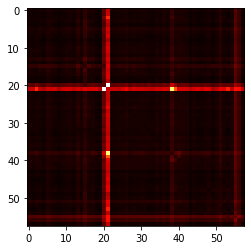

In [68]:
plt.imshow(hm['Ltilde'],cmap='hot')

In [69]:
L = hm['Ltilde'].shape[0]
cached_grad = np.zeros_like(hm['Ltilde'])
for i in range(L):
    for j in range(L):
        if i == j:
            cached_grad[i,j] = 0.5 * hm['Ltilde'][i,j]
        else:
            cached_grad[i,j] = 0.25 * (hm['Ltilde'][i,j]-hm['Ltilde'][i,i]-hm['Ltilde'][j,j])

In [70]:
cached_grad

array([[ 4.11324436e-06,  8.01635906e-07,  3.74064257e-07, ...,
         1.90833816e-07, -5.82549546e-08,  1.39370968e-08],
       [ 8.01635906e-07, -3.38943937e-06,  3.68784094e-06, ...,
        -1.63593722e-06, -1.32054993e-06, -8.19891284e-08],
       [ 3.74064257e-07,  3.68784094e-06, -2.38365465e-06, ...,
        -1.48320032e-06, -2.39680958e-07, -1.61733624e-07],
       ...,
       [ 1.90833816e-07, -1.63593722e-06, -1.48320032e-06, ...,
         1.25698825e-04,  4.74548506e-06, -4.17436240e-07],
       [-5.82549546e-08, -1.32054993e-06, -2.39680958e-07, ...,
         4.74548506e-06,  6.75085539e-05, -4.71663952e-08],
       [ 1.39370968e-08, -8.19891284e-08, -1.61733624e-07, ...,
        -4.17436240e-07, -4.71663952e-08, -7.30753527e-07]])

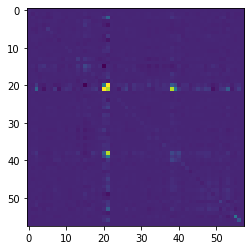

In [71]:
# cached_grad[cached_grad<0]=0
plt.imshow(cached_grad)

### Define a naive cost function: model size

In [72]:
layer_size = np.array([0 for i in range(L)])
for l in hm['layer_index']:
    layer_size[hm['layer_index'][l]] = torch.numel(layers_to_quant[l][0].weight)

In [73]:
layer_size

array([  432,  2304,  2304,  2304,  2304,  2304,  2304,  2304,  2304,
        2304,  2304,  2304,  2304,  2304,  2304,  2304,  2304,  2304,
        2304,  4608,  9216,   512,  9216,  9216,  9216,  9216,  9216,
        9216,  9216,  9216,  9216,  9216,  9216,  9216,  9216,  9216,
        9216,  9216, 18432, 36864,  2048, 36864, 36864, 36864, 36864,
       36864, 36864, 36864, 36864, 36864, 36864, 36864, 36864, 36864,
       36864, 36864, 36864,   640])

In [74]:
# initialize random variable v
# use recitfied sigmoid h(v) to represent alpha
# freg is 1-(1-2h(v))**beta, annealing beta to 

if not isinstance(cached_grad,torch.Tensor):
    cached_grad = torch.Tensor(cached_grad)

layer_size_tensor = torch.Tensor(layer_size)

def lossfunc(v,beta,lambda1,lambda2,printInfo=False,naive=False):
    alpha = (torch.sigmoid(v) * 1.2 - 0.1).clamp(0,1)
    if not naive:
        
        outer_alpha = torch.outer(alpha,alpha)
        netloss = torch.sum(outer_alpha * cached_grad)
    else:
        netloss = torch.sum(torch.diagonal(cached_grad) * alpha)
            
    regloss = torch.sum(1-(torch.abs(1-2*alpha))**beta)
    regloss *= lambda1
    
    
    closs = torch.sum(layer_size_tensor * alpha)
    closs *= -lambda2
    
    totloss = netloss + regloss + closs
    
    if printInfo:
        print(f'netloss {netloss.item():.4f} regloss {regloss.item():.4f}(beta={beta:.4f}) closs{closs.item():.4f}')
        print('alpha:\n',alpha)
        
    return totloss    
    

In [75]:
def optimize(n_iteration,lr,beta,lambda1,lambda2,naive=False):
    
    v = torch.nn.Parameter(torch.randn(L))
    optim = torch.optim.Adam([v,],lr=lr)
    bs = np.linspace(beta[0],beta[1],n_iteration)
    
    for i in range(n_iteration):
        if i==0 or (i+1) % 1000 == 0:
            printInfo = True
            print(f'Iter {i+1}')
        else:
            printInfo = False
            
        optim.zero_grad()
        loss = lossfunc(v,bs[i],lambda1,lambda2,printInfo=printInfo,naive=naive)
        loss.backward()
        optim.step()
    
    return v

def evaluate_decision(v,printInfo=False):
    v = v.detach()
    v[v>0] = 1
    v[v<0] = 0
    
    decision = []
    for layer in hm['layer_index']:
        if v[hm['layer_index'][layer]] > 0:
            decision.append(layer)
    
    
    #ploss = perturb_loss(decision,ref_metric,eval_data=test,printInfo=printInfo)
    with torch.no_grad():
        # perturb layers
        for n in decision:
            layers_to_quant[n][2].weight.data = layers_to_quant[n][1].weight.data
        # do evaluation
        res = evaluate(test,torch_perturb_model)
        # recover layers
        for n in decision:
            layers_to_quant[n][2].weight.data = layers_to_quant[n][0].weight.data
    
    orig_size = 0
    reduced_size = 0
    for i in range(L):
        orig_size += layer_size[i] * 8
        reduced_size += layer_size[i] * 8 if v[i] == 0 else layer_size[i] * 4
    if printInfo:
        print('result of quantizing the following layers')
        print(decision)
        print(res)
        print(f'8-bit model size {orig_size/8/1024/1024:.2f} MB')
        print(f'MP model size {reduced_size/8/1024/1024:.2f} MB') 
    
    return res,reduced_size/8/1024/1024

In [96]:
v = optimize(n_iteration=5000,lr=1e-3,beta=[20,2],lambda1=1e-3,lambda2=1e-10,naive=False)

Iter 1
netloss 0.0011 regloss 0.0574(beta=20.0000) closs-0.0000
alpha:
 tensor([0.7705, 0.5056, 0.2373, 0.3427, 0.3849, 0.7674, 0.8258, 0.9818, 0.8583,
        0.7414, 0.5981, 0.3822, 0.6369, 0.8984, 0.3253, 0.3034, 0.5596, 0.1050,
        0.4693, 0.8691, 0.0479, 0.1702, 0.6358, 0.3143, 0.4314, 0.4671, 0.8574,
        0.1276, 0.2705, 0.6387, 0.4048, 0.7487, 0.4734, 0.7103, 0.4648, 0.2567,
        0.6305, 0.4109, 0.8191, 0.6536, 0.8003, 0.5569, 0.4653, 0.3442, 0.6120,
        0.6946, 0.6114, 0.1143, 0.6467, 0.4062, 0.3557, 0.8464, 0.2644, 0.7328,
        0.6682, 0.5226, 0.2426, 0.8718], grad_fn=<ClampBackward1>)
Iter 1000
netloss 0.0003 regloss 0.0386(beta=16.4029) closs-0.0000
alpha:
 tensor([0.5016, 0.2521, 0.0000, 0.0293, 0.0000, 0.5096, 0.5604, 1.0000, 1.0000,
        1.0000, 0.3468, 0.1141, 0.3379, 1.0000, 0.5692, 0.0193, 0.3151, 0.0000,
        0.2566, 1.0000, 0.0000, 0.0000, 0.3605, 0.5572, 0.1877, 0.2414, 0.5926,
        0.0000, 0.0000, 0.3864, 0.1739, 0.4747, 0.6368, 1.0000, 0.

In [97]:
evaluate_decision(v)

({'mean_acc': 0.9422,
  'qtl_acc': 0.9422,
  'mean_loss': 0.26982091218233106,
  'qtl_loss': 0.26982091218233106,
  'test time': 1.1926729679107666,
  'acc_list': array([0.9422]),
  'loss_list': array([0.26982091])},
 0.7601165771484375)

In [78]:
v = optimize(n_iteration=10000,lr=1e-3,beta=[20,2],lambda1=1e-3,lambda2=1e-8,naive=True)

Iter 1
netloss 0.0006 regloss 0.0548(beta=20.0000) closs-0.0041
alpha:
 tensor([0.2278, 0.9049, 1.0000, 0.7836, 0.8772, 0.7584, 0.3519, 0.4411, 0.6942,
        0.2246, 1.0000, 0.1022, 0.1906, 0.5500, 0.5939, 0.7666, 0.2659, 0.6288,
        0.8629, 0.5711, 0.2937, 0.8842, 0.1297, 0.7101, 0.4565, 0.5482, 0.2073,
        0.8282, 0.4063, 0.3413, 0.1321, 0.1778, 0.5024, 0.4680, 0.9397, 0.7864,
        0.3184, 0.9128, 0.3044, 0.0000, 0.8247, 0.4193, 0.4134, 0.4460, 0.4508,
        0.6068, 0.8501, 0.7872, 0.6893, 0.1971, 0.1991, 0.4869, 0.1261, 0.2849,
        0.7435, 0.8028, 0.5413, 0.0939], grad_fn=<ClampBackward1>)
Iter 1000
netloss 0.0006 regloss 0.0327(beta=18.2016) closs-0.0060
alpha:
 tensor([0.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.6464, 0.7218, 1.0000,
        0.5190, 1.0000, 0.0000, 0.4852, 0.2734, 0.8599, 0.4714, 0.5630, 0.9615,
        1.0000, 0.8200, 0.0000, 0.5832, 0.0000, 1.0000, 0.7340, 0.8018, 0.4994,
        1.0000, 0.6938, 0.6373, 0.0000, 0.4671, 0.7686, 0.7428, 1.

In [79]:
evaluate_decision(v)

({'mean_acc': 0.9131,
  'qtl_acc': 0.9131,
  'mean_loss': 0.3778444938361645,
  'qtl_loss': 0.3778444938361645,
  'test time': 1.205996036529541,
  'acc_list': array([0.9131]),
  'loss_list': array([0.37784449])},
 0.4408416748046875)

## Pareto-Frontier of FeintLady vs Inter-Layer Dependency Unaware Optimization (Naive)

In [98]:
# fix lambda1 to 1e-3
# search lambda2 from 1e-5 to 1e-10
# each HP (lambda2) try 5 runs

lambda2s = np.logspace(-5,-10,50)
sample_size = 5
naive_loss,naive_size = [],[]
feint_loss,feint_size = [],[]

for lambda2 in lambda2s:
    print('lambda2:',lambda2)
    for repeat in range(sample_size):
        v = optimize(n_iteration=5000,lr=1e-3,beta=[20,2],lambda1=1e-3,lambda2=lambda2,naive=True)
        perf,size = evaluate_decision(v)
        naive_loss.append(perf)
        naive_size.append(size)

        v = optimize(n_iteration=5000,lr=1e-3,beta=[20,2],lambda1=1e-3,lambda2=lambda2,naive=False)
        perf,size = evaluate_decision(v)
        feint_loss.append(perf)
        feint_size.append(size)

lambda2: 1e-05
Iter 1
netloss 0.0006 regloss 0.0545(beta=20.0000) closs-3.4972
alpha:
 tensor([0.7286, 0.7992, 0.3389, 0.5269, 0.2040, 0.0787, 0.4542, 0.4271, 0.6793,
        0.6911, 0.6096, 0.7167, 0.3354, 0.9706, 0.9152, 0.4736, 0.2279, 0.7810,
        0.0000, 0.3196, 0.6604, 0.8499, 0.6715, 0.8112, 0.1029, 0.4817, 0.1703,
        0.5151, 0.3387, 0.0557, 0.3840, 0.2835, 0.4168, 0.5243, 0.5744, 0.3212,
        0.3360, 0.4604, 0.6810, 0.0000, 0.8374, 0.8013, 0.6667, 0.3840, 0.8676,
        0.0000, 0.2181, 0.1311, 0.6452, 0.1385, 0.7500, 0.1192, 0.2220, 0.5959,
        0.3914, 0.5293, 0.2162, 0.5290], grad_fn=<ClampBackward1>)
Iter 1000
netloss 0.0008 regloss 0.0495(beta=16.4029) closs-5.3954
alpha:
 tensor([0.9214, 0.9590, 0.6352, 0.7861, 0.4949, 0.3247, 0.7323, 0.7109, 0.8859,
        0.8931, 0.8421, 0.9086, 0.6320, 1.0000, 1.0000, 0.7472, 0.5226, 0.9476,
        0.0000, 0.6172, 0.8740, 1.0000, 0.8809, 0.9619, 0.3598, 0.7533, 0.4535,
        0.7778, 0.6350, 0.2846, 0.6752, 0.5818, 0.7

Iter 2000
netloss 0.0008 regloss 0.0384(beta=12.8022) closs-7.6989
alpha:
 tensor([0.8249, 1.0000, 0.9400, 0.6445, 0.6521, 0.8277, 0.6585, 1.0000, 1.0000,
        0.9061, 0.8464, 0.8752, 0.9568, 1.0000, 0.6696, 0.6971, 1.0000, 1.0000,
        0.9087, 0.8275, 1.0000, 0.8352, 0.9170, 0.9813, 0.8050, 0.9231, 1.0000,
        0.8142, 0.7379, 0.8045, 0.7993, 0.9194, 1.0000, 0.8299, 0.6406, 0.8970,
        0.7393, 1.0000, 0.7580, 0.8805, 1.0000, 0.8744, 0.8237, 1.0000, 0.9018,
        0.9667, 0.9914, 0.8848, 1.0000, 0.9304, 0.8244, 0.9584, 0.8536, 0.9654,
        1.0000, 0.9836, 0.7929, 1.0000], grad_fn=<ClampBackward1>)
Iter 3000
netloss 0.0010 regloss 0.0172(beta=9.2014) closs-8.3207
alpha:
 tensor([0.9939, 1.0000, 1.0000, 0.8617, 0.8655, 0.9592, 0.8687, 1.0000, 1.0000,
        1.0000, 0.9703, 0.9879, 1.0000, 1.0000, 0.8742, 0.8881, 1.0000, 1.0000,
        1.0000, 0.9547, 1.0000, 0.9981, 1.0000, 1.0000, 0.9408, 1.0000, 1.0000,
        0.9455, 0.9066, 0.9405, 0.9378, 1.0000, 1.0000, 0.9538, 

Iter 5000
netloss 0.0010 regloss 0.0000(beta=2.0000) closs-8.4920
alpha:
 tensor([1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.], grad_fn=<ClampBackward1>)
Iter 1
netloss 0.0019 regloss 0.0550(beta=20.0000) closs-3.7934
alpha:
 tensor([0.7545, 0.2060, 0.4750, 0.8722, 0.8637, 0.5694, 0.4928, 0.2468, 0.1329,
        0.7416, 1.0000, 0.5881, 0.5005, 0.4495, 0.4392, 1.0000, 0.5056, 0.5626,
        0.6654, 0.4990, 0.2896, 0.9417, 0.4129, 0.5779, 0.7012, 0.1406, 0.5618,
        0.3170, 0.3628, 0.4393, 0.8766, 0.2763, 0.7674, 0.3395, 0.8590, 0.2623,
        0.3290, 0.1825, 0.2135, 0.5083, 0.8844, 0.9877, 0.2436, 0.5790, 0.1150,
        0.4289, 0.6548, 0.7583, 0.2530, 0.0335, 0.4269, 0.1162, 0.3977, 0.2146,
        0.4957, 0.8108, 0.4447, 0.7468], grad_fn=<ClampBackward1>)
Iter 1000
netlos

Iter 2000
netloss 0.0055 regloss 0.0411(beta=12.8022) closs-7.5834
alpha:
 tensor([0.9490, 0.8540, 0.8841, 0.8416, 0.8059, 0.9090, 0.7178, 0.7073, 0.8865,
        0.9644, 0.9573, 0.8653, 1.0000, 0.8677, 0.7053, 0.6415, 0.0000, 0.7053,
        0.8907, 0.9224, 0.9478, 1.0000, 0.7256, 1.0000, 1.0000, 0.9135, 0.9300,
        0.9255, 0.7922, 0.9787, 0.8677, 0.9359, 0.9502, 0.8799, 0.9809, 0.8929,
        1.0000, 0.8602, 0.9847, 0.8907, 1.0000, 0.8148, 0.9348, 1.0000, 1.0000,
        0.8929, 0.5550, 1.0000, 0.9644, 0.9464, 0.8254, 0.9615, 1.0000, 0.9483,
        0.6694, 0.9069, 0.7768, 0.7359], grad_fn=<ClampBackward1>)
Iter 3000
netloss 0.0061 regloss 0.0151(beta=9.2014) closs-8.2561
alpha:
 tensor([1.0000, 0.9750, 0.9936, 0.9674, 0.9466, 1.0000, 0.8988, 0.8933, 0.9950,
        1.0000, 1.0000, 0.9819, 1.0000, 0.9833, 0.8923, 0.8600, 0.0000, 0.8923,
        0.9976, 1.0000, 1.0000, 1.0000, 0.9005, 1.0000, 1.0000, 0.9994, 1.0000,
        1.0000, 0.9341, 1.0000, 0.9740, 1.0000, 1.0000, 0.9808, 

Iter 5000
netloss 0.0063 regloss 0.0000(beta=2.0000) closs-8.5150
alpha:
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.], grad_fn=<ClampBackward1>)
lambda2: 7.906043210907702e-06
Iter 1
netloss 0.0004 regloss 0.0570(beta=20.0000) closs-3.0573
alpha:
 tensor([0.3888, 0.7426, 0.7169, 0.3346, 0.2873, 0.1037, 0.2385, 0.8439, 0.7261,
        0.0537, 0.4916, 0.6070, 0.2398, 0.2068, 0.2593, 0.0908, 0.5525, 0.3939,
        0.2306, 0.6719, 0.3255, 0.5918, 0.4398, 0.5061, 0.5974, 0.5930, 0.2698,
        0.4265, 0.9601, 0.7028, 0.8236, 0.8887, 0.0378, 0.0230, 0.9159, 0.2715,
        0.4224, 0.8510, 0.1540, 0.4635, 0.7154, 0.6786, 0.3991, 0.3704, 0.1004,
        0.3951, 0.6782, 0.4676, 0.1977, 0.4658, 0.6576, 0.7861, 0.6865, 0.1359,
        0.7149, 0.1291, 0.2384, 0.1475], grad_fn=<Cl

Iter 1000
netloss 0.0007 regloss 0.0519(beta=16.4029) closs-5.3028
alpha:
 tensor([1.0000, 0.3905, 0.8988, 0.7904, 0.7828, 0.8377, 0.9573, 0.7243, 0.4220,
        0.7920, 0.5767, 0.6355, 0.8006, 0.6238, 0.6600, 0.4794, 0.9757, 0.7995,
        0.6199, 0.7045, 0.4724, 0.6175, 0.8033, 0.6721, 0.8417, 0.9988, 0.6908,
        0.6621, 0.3695, 0.5005, 0.2794, 0.9443, 0.8236, 0.3314, 0.8846, 0.7972,
        0.7779, 0.2275, 1.0000, 0.8967, 0.4905, 0.8595, 0.7885, 0.9212, 0.8732,
        0.8241, 0.7573, 0.3693, 0.6136, 0.8096, 1.0000, 0.8762, 0.8475, 0.8159,
        1.0000, 0.9465, 0.7779, 0.8604], grad_fn=<ClampBackward1>)
Iter 2000
netloss 0.0009 regloss 0.0382(beta=12.8022) closs-6.2203
alpha:
 tensor([1.0000, 0.7023, 1.0000, 0.9402, 0.9356, 0.9711, 1.0000, 0.9010, 0.7232,
        0.9412, 0.8173, 0.8507, 0.9466, 0.8441, 0.8646, 0.7595, 1.0000, 0.9460,
        0.8419, 0.8890, 0.7551, 0.8416, 0.9432, 0.8708, 0.9649, 1.0000, 0.8812,
        0.8653, 0.6878, 0.7723, 0.6212, 1.0000, 0.9546, 0.6607,

Iter 4000
netloss 0.0010 regloss 0.0008(beta=5.6007) closs-6.7170
alpha:
 tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 0.9960, 1.0000, 1.0000, 1.0000, 0.9778, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 0.9943, 1.0000, 1.0000, 0.9968, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 0.9783, 1.0000, 1.0000, 1.0000, 1.0000, 0.9739, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000], grad_fn=<ClampBackward1>)
Iter 5000
netloss 0.0010 regloss 0.0000(beta=2.0000) closs-6.7320
alpha:
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.], grad_fn=<ClampBackward1>)
Iter 1
netloss

Iter 1000
netloss 0.0031 regloss 0.0523(beta=16.4029) closs-5.0067
alpha:
 tensor([0.7784, 0.9037, 0.7368, 0.6535, 0.9203, 0.7148, 0.8125, 0.4974, 0.6940,
        0.7183, 0.0000, 0.9420, 0.4246, 0.6723, 0.3047, 0.5475, 0.6666, 0.7048,
        0.7355, 0.5634, 0.9170, 0.5467, 0.2694, 0.7960, 0.7891, 0.0000, 1.0000,
        0.9515, 0.5606, 0.7256, 0.9783, 0.5474, 0.8735, 0.4971, 0.2682, 0.5828,
        0.5093, 0.6586, 0.8175, 0.7919, 0.6745, 0.8141, 0.9855, 0.8255, 0.6112,
        0.8319, 0.4344, 0.6396, 0.8699, 0.8264, 0.8845, 0.6831, 0.9124, 1.0000,
        0.5967, 0.5428, 0.9292, 0.4171], grad_fn=<ClampBackward1>)
Iter 2000
netloss 0.0047 regloss 0.0400(beta=12.8022) closs-6.0276
alpha:
 tensor([0.9563, 1.0000, 0.9079, 0.8608, 1.0000, 0.8955, 0.9543, 0.7703, 0.8838,
        0.8976, 0.0000, 1.0000, 0.7248, 0.8713, 0.6422, 0.8000, 0.8682, 0.8898,
        0.9074, 0.8095, 1.0000, 0.7542, 0.6133, 0.9392, 0.9353, 0.0000, 1.0000,
        1.0000, 0.8078, 0.9003, 1.0000, 0.8002, 0.9833, 0.7703,

Iter 4000
netloss 0.0063 regloss 0.0007(beta=5.6007) closs-6.7157
alpha:
 tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 0.9973, 0.9987, 0.9989, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 0.9864, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 0.9478, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000], grad_fn=<ClampBackward1>)
Iter 5000
netloss 0.0063 regloss 0.0000(beta=2.0000) closs-6.7320
alpha:
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.], grad_fn=<ClampBackward1>)
lambda2: 6.250

Iter 1000
netloss 0.0008 regloss 0.0462(beta=16.4029) closs-4.0742
alpha:
 tensor([0.3972, 0.9778, 0.9755, 0.4924, 0.4150, 1.0000, 0.7051, 0.7634, 0.9322,
        1.0000, 0.4660, 1.0000, 0.7436, 0.9848, 0.5364, 1.0000, 0.7874, 0.9527,
        0.8085, 0.7882, 0.6180, 0.8495, 0.7858, 0.7135, 0.5053, 0.9725, 0.7444,
        0.7380, 0.8158, 0.6132, 0.9698, 0.8298, 0.9457, 0.9760, 0.9283, 0.7833,
        1.0000, 0.4492, 0.9702, 0.9234, 1.0000, 0.9888, 0.3933, 0.4759, 0.6880,
        0.5443, 0.8145, 0.8509, 0.9094, 0.6690, 0.7586, 0.9680, 0.8406, 0.8673,
        0.7904, 0.8784, 0.3917, 1.0000], grad_fn=<ClampBackward1>)
Iter 2000
netloss 0.0009 regloss 0.0304(beta=12.8022) closs-4.8564
alpha:
 tensor([0.7071, 1.0000, 1.0000, 0.7674, 0.7185, 1.0000, 0.8904, 0.9248, 1.0000,
        1.0000, 0.7512, 1.0000, 0.9129, 1.0000, 0.7938, 1.0000, 0.9398, 1.0000,
        0.9537, 0.9368, 0.8407, 1.0000, 0.9338, 0.8937, 0.7753, 1.0000, 0.9108,
        0.9072, 0.9508, 0.8380, 1.0000, 0.9588, 1.0000, 1.0000,

Iter 4000
netloss 0.0010 regloss 0.0009(beta=5.6007) closs-5.2958
alpha:
 tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 0.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9886, 1.0000, 1.0000, 0.9940,
        0.9744, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 0.9823, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        0.9755, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000], grad_fn=<ClampBackward1>)
Iter 5000
netloss 0.0010 regloss 0.0000(beta=2.0000) closs-5.3080
alpha:
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.], grad_fn=<ClampBackward1>)
Iter 1
netloss

Iter 1000
netloss 0.0031 regloss 0.0505(beta=16.4029) closs-3.6244
alpha:
 tensor([0.8651, 0.6423, 0.9881, 0.9393, 0.6972, 0.8672, 0.8798, 0.3669, 0.7470,
        1.0000, 0.8889, 0.3106, 0.0000, 0.6367, 0.9394, 0.9693, 0.6817, 0.5087,
        0.6323, 0.9421, 0.9607, 0.6179, 0.8187, 0.8108, 0.4189, 0.6804, 0.7526,
        0.8139, 0.5748, 0.5495, 0.7186, 0.3265, 0.6424, 0.5574, 0.9337, 0.7817,
        0.8895, 0.7653, 0.5693, 0.6220, 0.6319, 0.4816, 0.6634, 0.5927, 0.6066,
        0.6433, 0.6321, 0.3577, 0.8758, 0.8150, 1.0000, 0.3605, 0.3979, 0.9860,
        0.4855, 0.9827, 0.9780, 0.0000], grad_fn=<ClampBackward1>)
Iter 2000
netloss 0.0046 regloss 0.0369(beta=12.8022) closs-4.5886
alpha:
 tensor([1.0000, 0.8546, 1.0000, 1.0000, 0.8859, 0.9965, 1.0000, 0.6859, 0.9149,
        1.0000, 1.0000, 0.6467, 0.0000, 0.8513, 1.0000, 1.0000, 0.8770, 0.7770,
        0.8489, 1.0000, 1.0000, 0.7494, 0.9524, 0.9479, 0.7211, 0.8754, 0.9153,
        0.9497, 0.8160, 0.8014, 0.8966, 0.6570, 0.8543, 0.8061,

Iter 4000
netloss 0.0058 regloss 0.0008(beta=5.6007) closs-5.2824
alpha:
 tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 0.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9978, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9677,
        1.0000, 1.0000, 1.0000, 1.0000, 0.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 0.9821, 1.0000, 1.0000, 0.9709, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000], grad_fn=<ClampBackward1>)
Iter 5000
netloss 0.0058 regloss 0.0000(beta=2.0000) closs-5.2952
alpha:
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.], grad_fn=<ClampBackward1>)
lambda2: 4.941

Iter 1000
netloss 0.0007 regloss 0.0484(beta=16.4029) closs-3.2146
alpha:
 tensor([0.7423, 0.9491, 0.8675, 0.6551, 1.0000, 1.0000, 0.5683, 0.9444, 1.0000,
        0.8761, 0.6458, 0.7454, 1.0000, 0.7503, 0.9043, 0.6424, 0.5125, 0.7734,
        1.0000, 0.8111, 0.7322, 0.8268, 0.7542, 0.9606, 0.9971, 0.6277, 0.2387,
        1.0000, 0.7685, 0.8168, 0.8166, 0.8347, 0.6202, 0.6759, 0.8233, 0.7238,
        0.7875, 0.8961, 0.4686, 0.7417, 0.5483, 0.7304, 0.6213, 0.9500, 0.7471,
        0.8842, 0.5855, 1.0000, 0.9746, 0.8507, 0.9029, 0.6370, 0.9085, 0.7388,
        0.9185, 0.3706, 0.4857, 0.9615], grad_fn=<ClampBackward1>)
Iter 2000
netloss 0.0009 regloss 0.0320(beta=12.8022) closs-3.8400
alpha:
 tensor([0.9346, 1.0000, 1.0000, 0.8621, 1.0000, 1.0000, 0.8125, 1.0000, 1.0000,
        1.0000, 0.8568, 0.9149, 1.0000, 0.9179, 1.0000, 0.8549, 0.7796, 0.9325,
        1.0000, 0.9518, 0.9042, 1.0000, 0.9165, 1.0000, 1.0000, 0.8462, 0.5914,
        1.0000, 0.9245, 0.9520, 0.9519, 0.9625, 0.8419, 0.8730,

Iter 4000
netloss 0.0010 regloss 0.0009(beta=5.6007) closs-4.1517
alpha:
 tensor([1.0000, 1.0000, 1.0000, 0.9963, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9822, 1.0000, 0.9960,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.0000, 0.9850, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 0.9976, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 0.9531, 1.0000, 1.0000], grad_fn=<ClampBackward1>)
Iter 5000
netloss 0.0010 regloss 0.0000(beta=2.0000) closs-4.1623
alpha:
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.], grad_fn=<ClampBackward1>)
Iter 1
netloss

Iter 1000
netloss 0.0036 regloss 0.0501(beta=16.4029) closs-3.1081
alpha:
 tensor([0.6241, 1.0000, 1.0000, 0.9134, 0.6312, 1.0000, 1.0000, 0.3769, 0.8023,
        0.7915, 0.5232, 0.8062, 0.9571, 0.8833, 0.7383, 0.9633, 0.7632, 0.6111,
        0.5218, 0.5781, 0.8196, 0.7319, 0.6448, 0.6606, 0.6231, 0.2298, 0.9738,
        0.9845, 0.6493, 0.8179, 0.3775, 0.4758, 0.7367, 0.8623, 0.8255, 0.8696,
        0.7870, 0.9381, 0.7854, 0.4371, 0.7755, 0.2529, 0.7290, 0.9211, 0.9284,
        0.8884, 0.4688, 0.9049, 0.6587, 0.3350, 0.8081, 0.7541, 0.9987, 0.8407,
        0.8369, 0.9189, 0.8755, 1.0000], grad_fn=<ClampBackward1>)
Iter 2000
netloss 0.0040 regloss 0.0348(beta=12.8022) closs-3.7785
alpha:
 tensor([0.8463, 1.0000, 1.0000, 1.0000, 0.8485, 1.0000, 1.0000, 0.6930, 0.9519,
        0.9446, 0.7859, 0.9547, 1.0000, 1.0000, 0.9105, 1.0000, 0.9260, 0.8368,
        0.7851, 0.8180, 0.9536, 0.4781, 0.8557, 0.8645, 0.8435, 0.5860, 1.0000,
        1.0000, 0.8582, 0.9526, 0.6933, 0.7572, 0.9067, 0.9791,

Iter 4000
netloss 0.0032 regloss 0.0004(beta=5.6007) closs-4.1924
alpha:
 tensor([1.0000, 1.0000, 1.0000, 1.0000, 0.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9896,
        1.0000, 1.0000, 1.0000, 0.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9776,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 0.9974, 1.0000], grad_fn=<ClampBackward1>)
Iter 5000
netloss 0.0032 regloss 0.0000(beta=2.0000) closs-4.1940
alpha:
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.], grad_fn=<ClampBackward1>)
lambda2: 3.906

Iter 1000
netloss 0.0007 regloss 0.0522(beta=16.4029) closs-2.5346
alpha:
 tensor([0.3806, 0.5539, 0.9209, 0.8922, 0.8763, 0.5046, 0.8626, 0.7605, 0.5472,
        0.7011, 0.6854, 0.7780, 0.5709, 0.9211, 0.9567, 0.8755, 0.5739, 0.4885,
        0.5381, 0.8472, 0.9901, 0.3992, 0.8967, 0.9175, 0.8956, 0.5674, 0.2847,
        0.4249, 0.7164, 0.9822, 0.5427, 0.9296, 0.8393, 0.8713, 0.5766, 0.5198,
        0.7653, 0.8356, 0.5642, 0.9551, 1.0000, 0.6414, 0.9107, 0.6992, 0.5889,
        0.9937, 0.8673, 0.5700, 0.3619, 0.8226, 0.9792, 0.9341, 0.2603, 0.9219,
        0.8981, 0.7967, 0.9742, 0.9914], grad_fn=<ClampBackward1>)
Iter 2000
netloss 0.0008 regloss 0.0314(beta=12.8022) closs-3.0223
alpha:
 tensor([0.6971, 0.8041, 1.0000, 1.0000, 1.0000, 0.7749, 1.0000, 0.9259, 0.8002,
        0.8891, 0.8799, 0.9376, 0.8140, 1.0000, 1.0000, 1.0000, 0.8157, 0.7651,
        0.7948, 0.9778, 1.0000, 0.7088, 1.0000, 1.0000, 1.0000, 0.8118, 0.6262,
        0.7250, 0.8957, 1.0000, 0.7975, 1.0000, 0.9664, 0.9864,

Iter 4000
netloss 0.0009 regloss 0.0011(beta=5.6007) closs-3.1572
alpha:
 tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.0000, 1.0000, 1.0000,
        1.0000, 0.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 0.9929, 1.0000, 1.0000, 1.0000, 0.9644, 1.0000, 1.0000, 1.0000,
        0.9823, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 0.9706, 1.0000, 1.0000, 0.9766, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 0.0000, 1.0000], grad_fn=<ClampBackward1>)
Iter 5000
netloss 0.0009 regloss 0.0000(beta=2.0000) closs-3.1647
alpha:
 tensor([1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 0., 1.], grad_fn=<ClampBackward1>)
Iter 1
netloss

Iter 1000
netloss 0.0026 regloss 0.0515(beta=16.4029) closs-2.5612
alpha:
 tensor([0.5674, 0.9530, 0.9273, 0.8256, 0.7568, 0.7397, 0.8083, 0.8850, 0.7330,
        0.9244, 0.7241, 0.8142, 0.3144, 0.9470, 0.7378, 0.4674, 0.7815, 0.4940,
        0.8104, 1.0000, 0.5971, 0.2858, 0.9355, 0.5575, 1.0000, 0.9604, 0.7854,
        0.8188, 0.8784, 0.2408, 0.8068, 0.8153, 1.0000, 0.7964, 0.8160, 0.3507,
        0.8042, 0.8480, 0.9004, 0.9768, 0.7712, 1.0000, 0.8319, 0.7741, 1.0000,
        0.6701, 0.4177, 0.6356, 0.8332, 0.5833, 0.6929, 0.7844, 0.9225, 0.5693,
        0.8860, 0.8176, 0.6386, 0.8289], grad_fn=<ClampBackward1>)
Iter 2000
netloss 0.0027 regloss 0.0337(beta=12.8022) closs-3.0437
alpha:
 tensor([0.8122, 1.0000, 1.0000, 0.9732, 0.9233, 0.9125, 0.9596, 1.0000, 0.9082,
        1.0000, 0.9029, 0.9643, 0.6510, 1.0000, 0.9113, 0.7516, 0.9399, 0.7681,
        0.9614, 1.0000, 0.8293, 0.0000, 1.0000, 0.8061, 1.0000, 1.0000, 0.9345,
        0.9540, 0.9910, 0.5972, 0.9470, 0.9520, 1.0000, 0.9409,

Iter 4000
netloss 0.0032 regloss 0.0007(beta=5.6007) closs-3.3165
alpha:
 tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 0.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 0.9942, 1.0000, 0.9859, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        0.9480, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 0.9994, 1.0000, 1.0000], grad_fn=<ClampBackward1>)
Iter 5000
netloss 0.0033 regloss 0.0000(beta=2.0000) closs-3.3248
alpha:
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.], grad_fn=<ClampBackward1>)
lambda2: 3.088

Iter 1000
netloss 0.0007 regloss 0.0513(beta=16.4029) closs-1.9100
alpha:
 tensor([0.9024, 0.8354, 0.8172, 0.7861, 0.6270, 0.8906, 0.4698, 0.8365, 0.8139,
        0.7204, 0.4730, 1.0000, 0.8516, 0.7275, 0.5394, 0.8546, 1.0000, 0.6587,
        0.5389, 0.8283, 0.7455, 0.7826, 0.5026, 0.4556, 0.9599, 0.9178, 0.9888,
        0.9041, 0.8173, 1.0000, 0.6865, 0.3409, 0.8564, 0.5041, 0.9628, 0.0000,
        1.0000, 0.6031, 0.7744, 0.9156, 0.8011, 0.6965, 0.7887, 0.8823, 0.7002,
        0.6935, 0.9593, 0.8940, 0.8733, 0.5905, 0.6097, 0.6510, 0.6081, 0.5783,
        0.5610, 0.7965, 0.5071, 0.5616], grad_fn=<ClampBackward1>)
Iter 2000
netloss 0.0009 regloss 0.0337(beta=12.8022) closs-2.3438
alpha:
 tensor([1.0000, 0.9876, 0.9716, 0.9465, 0.8464, 1.0000, 0.7536, 0.9886, 0.9687,
        0.9016, 0.7555, 1.0000, 1.0000, 0.9062, 0.7956, 1.0000, 1.0000, 0.8648,
        0.7953, 0.9676, 0.9123, 1.0000, 0.7736, 0.7447, 1.0000, 1.0000, 1.0000,
        1.0000, 0.9543, 1.0000, 0.8791, 0.6677, 0.9789, 0.7745,

Iter 4000
netloss 0.0010 regloss 0.0011(beta=5.6007) closs-2.6115
alpha:
 tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 0.0000, 0.9869, 0.9630, 0.9612, 1.0000,
        0.9831, 1.0000, 1.0000, 1.0000, 0.9971, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000], grad_fn=<ClampBackward1>)
Iter 5000
netloss 0.0010 regloss 0.0000(beta=2.0000) closs-2.6238
alpha:
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.], grad_fn=<ClampBackward1>)
Iter 1
netloss

Iter 1000
netloss 0.0020 regloss 0.0513(beta=16.4029) closs-1.7562
alpha:
 tensor([1.0000, 0.4539, 0.9031, 0.7114, 0.6368, 0.7609, 0.9248, 0.7749, 0.6919,
        0.8940, 0.5145, 0.8918, 0.6908, 0.0000, 0.9098, 0.8258, 0.4990, 0.8691,
        0.6844, 1.0000, 0.7038, 0.2904, 0.6724, 0.8640, 0.6667, 1.0000, 0.6127,
        0.6868, 0.9177, 1.0000, 0.5283, 0.8944, 1.0000, 0.6501, 0.7947, 0.2837,
        0.4711, 0.5477, 0.5719, 0.9232, 0.6868, 0.6924, 0.8294, 0.8819, 0.8072,
        0.4754, 0.5722, 0.2779, 0.2292, 0.8448, 0.5305, 0.6178, 0.9717, 0.3694,
        0.5504, 0.8375, 0.6693, 0.8447], grad_fn=<ClampBackward1>)
Iter 2000
netloss 0.0024 regloss 0.0358(beta=12.8022) closs-2.2561
alpha:
 tensor([1.0000, 0.7434, 1.0000, 0.8959, 0.8519, 0.9281, 1.0000, 0.9381, 0.8841,
        1.0000, 0.7808, 1.0000, 0.8835, 0.0000, 1.0000, 0.9791, 0.7712, 1.0000,
        0.8800, 1.0000, 0.8892, 0.0000, 0.8712, 0.9839, 0.8680, 1.0000, 0.8377,
        0.8793, 1.0000, 1.0000, 0.7889, 1.0000, 1.0000, 0.8588,

Iter 4000
netloss 0.0032 regloss 0.0012(beta=5.6007) closs-2.6167
alpha:
 tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 0.9991, 1.0000, 0.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 0.9566, 1.0000, 1.0000, 1.0000, 0.9552, 1.0000, 1.0000,
        1.0000, 0.9726, 1.0000, 0.9895, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000], grad_fn=<ClampBackward1>)
Iter 5000
netloss 0.0033 regloss 0.0000(beta=2.0000) closs-2.6286
alpha:
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.], grad_fn=<ClampBackward1>)
lambda2: 2.442

Iter 1000
netloss 0.0007 regloss 0.0476(beta=16.4029) closs-1.4061
alpha:
 tensor([0.9325, 0.5578, 0.6108, 0.8793, 0.3248, 0.5569, 0.8542, 0.6928, 1.0000,
        0.6541, 0.4698, 1.0000, 0.8867, 0.9202, 0.8685, 0.7370, 1.0000, 0.9351,
        0.5465, 0.8711, 0.5741, 0.5678, 0.6004, 0.9783, 0.4896, 0.0000, 0.7891,
        0.8666, 0.8863, 0.9487, 0.7628, 0.7935, 0.8283, 0.3996, 1.0000, 0.7220,
        0.3493, 0.5737, 0.9668, 0.5023, 1.0000, 0.7096, 0.7198, 0.8757, 0.6896,
        0.3140, 0.7808, 0.6867, 1.0000, 0.3107, 0.0000, 0.9064, 0.5106, 0.5886,
        1.0000, 0.9255, 0.6865, 0.6705], grad_fn=<ClampBackward1>)
Iter 2000
netloss 0.0009 regloss 0.0321(beta=12.8022) closs-1.7388
alpha:
 tensor([1.0000, 0.8064, 0.8373, 1.0000, 0.6616, 0.8059, 1.0000, 0.8856, 1.0000,
        0.8624, 0.7536, 1.0000, 1.0000, 1.0000, 1.0000, 0.9141, 1.0000, 1.0000,
        0.7998, 1.0000, 0.8158, 0.8137, 0.8308, 1.0000, 0.7657, 0.0000, 0.9384,
        0.9884, 1.0000, 1.0000, 0.9228, 0.9410, 0.9627, 0.7083,

Iter 4000
netloss 0.0010 regloss 0.0001(beta=5.6007) closs-2.0562
alpha:
 tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9978, 1.0000,
        0.9947, 1.0000, 1.0000, 1.0000], grad_fn=<ClampBackward1>)
Iter 5000
netloss 0.0010 regloss 0.0000(beta=2.0000) closs-2.0569
alpha:
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.], grad_fn=<ClampBackward1>)
Iter 1
netloss

Iter 1000
netloss 0.0022 regloss 0.0448(beta=16.4029) closs-1.5315
alpha:
 tensor([0.6365, 0.6186, 0.9637, 0.7806, 0.8250, 0.8602, 0.6831, 0.8234, 1.0000,
        0.8645, 0.8007, 0.7554, 0.4095, 0.9980, 0.8000, 0.8252, 0.5410, 0.7952,
        0.9398, 0.6814, 1.0000, 0.0000, 0.9375, 0.9754, 0.5704, 0.8377, 0.6602,
        0.8391, 0.9824, 1.0000, 0.7641, 0.7287, 0.8568, 0.9019, 0.8293, 0.9841,
        0.7450, 1.0000, 0.9806, 0.8135, 1.0000, 0.6338, 0.5063, 0.6642, 0.7020,
        0.9024, 0.3787, 0.9794, 0.0000, 0.8278, 0.6848, 0.8873, 0.6703, 0.7482,
        1.0000, 0.4172, 1.0000, 0.6903], grad_fn=<ClampBackward1>)
Iter 2000
netloss 0.0027 regloss 0.0287(beta=12.8022) closs-1.8161
alpha:
 tensor([0.8574, 0.8416, 1.0000, 0.9460, 0.9852, 1.0000, 0.8796, 0.9842, 1.0000,
        1.0000, 0.9631, 0.9269, 0.7150, 1.0000, 0.9623, 0.9854, 0.7962, 0.9585,
        1.0000, 0.8771, 1.0000, 0.0000, 1.0000, 1.0000, 0.8135, 0.9689, 0.8645,
        0.9698, 1.0000, 1.0000, 0.9235, 0.9031, 0.9817, 1.0000,

Iter 4000
netloss 0.0032 regloss 0.0013(beta=5.6007) closs-2.0675
alpha:
 tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 0.0000, 0.9849, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 0.9930, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9947,
        0.9803, 1.0000, 1.0000, 0.9623, 0.9501, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000], grad_fn=<ClampBackward1>)
Iter 5000
netloss 0.0033 regloss 0.0000(beta=2.0000) closs-2.0782
alpha:
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.], grad_fn=<ClampBackward1>)
lambda2: 1.930

Iter 1
netloss 0.0004 regloss 0.0564(beta=20.0000) closs-0.8940
alpha:
 tensor([0.3685, 0.2609, 0.1691, 0.5712, 0.2793, 0.1100, 0.6551, 0.8305, 0.8204,
        0.6804, 0.0458, 0.5882, 0.5358, 0.3856, 0.4422, 0.5123, 0.4049, 0.3819,
        0.7840, 0.7918, 0.9380, 0.4864, 0.0922, 0.6786, 0.1141, 0.1813, 0.0493,
        0.8159, 0.8259, 0.6147, 0.2792, 0.2961, 0.7906, 0.7017, 0.6063, 0.2307,
        0.2943, 0.7479, 0.3459, 0.8603, 0.4676, 0.4591, 0.7249, 0.4299, 0.1363,
        1.0000, 0.9542, 0.4183, 0.7989, 0.6495, 0.9066, 0.4159, 0.8987, 0.1927,
        0.2844, 0.0646, 0.4497, 0.8470], grad_fn=<ClampBackward1>)
Iter 1000
netloss 0.0007 regloss 0.0462(beta=16.4029) closs-1.2391
alpha:
 tensor([0.6618, 0.5585, 0.4521, 0.8168, 0.5776, 0.3742, 0.8718, 1.0000, 1.0000,
        0.8882, 0.0000, 0.8282, 0.7924, 0.6766, 0.7230, 0.7758, 0.6928, 0.6734,
        0.9672, 0.9618, 1.0000, 0.7568, 0.3453, 0.8855, 0.3771, 0.4674, 0.2879,
        0.9718, 0.9788, 0.8454, 0.5775, 0.5945, 0.9549, 0.8997, 0.

Iter 3000
netloss 0.0010 regloss 0.0093(beta=9.2014) closs-1.6130
alpha:
 tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 0.9155, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        0.9306, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.8928, 1.0000, 0.9420,
        1.0000, 0.9693, 0.9842, 1.0000, 1.0000, 1.0000, 0.9123, 1.0000, 1.0000,
        0.9312, 0.8528, 0.9900, 1.0000, 1.0000, 0.8362, 1.0000, 1.0000, 1.0000,
        0.9752, 1.0000, 1.0000, 0.9880, 1.0000, 0.9996, 1.0000, 0.9360, 1.0000,
        0.9887, 0.9838, 1.0000, 1.0000], grad_fn=<ClampBackward1>)
Iter 4000
netloss 0.0010 regloss 0.0006(beta=5.6007) closs-1.6407
alpha:
 tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9986, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1

Iter 1
netloss 0.0024 regloss 0.0573(beta=20.0000) closs-0.8287
alpha:
 tensor([0.5521, 0.3791, 0.7514, 0.4484, 0.7656, 0.4018, 0.1193, 0.6968, 0.1839,
        0.5184, 0.7780, 0.2387, 0.7238, 0.2954, 0.3863, 0.3718, 0.6179, 0.2524,
        0.2727, 0.2446, 0.4024, 0.9087, 0.3562, 0.5520, 0.9772, 0.7114, 0.1804,
        0.5986, 0.0395, 0.4541, 0.2100, 0.4604, 0.1347, 0.2246, 0.1000, 0.3371,
        0.7047, 0.1801, 0.8091, 0.3502, 0.3680, 0.7166, 0.4847, 0.5449, 0.6137,
        0.3259, 0.5847, 0.6185, 0.7426, 0.6752, 0.6845, 0.2393, 0.7623, 0.6481,
        0.6558, 0.0981, 0.2395, 0.9354], grad_fn=<ClampBackward1>)
Iter 1000
netloss 0.0031 regloss 0.0548(beta=16.4029) closs-1.2230
alpha:
 tensor([0.8034, 0.6708, 0.9394, 0.7276, 0.9502, 0.6900, 0.3862, 0.8990, 0.4705,
        0.7802, 0.9619, 0.5346, 0.9176, 0.5932, 0.6771, 0.6642, 0.8476, 0.5491,
        0.5710, 0.5409, 0.6908, 0.5988, 0.6509, 0.8036, 1.0000, 0.9056, 0.4663,
        0.8350, 0.2795, 0.7322, 0.5020, 0.7371, 0.4062, 0.5188, 0.

Iter 3000
netloss 0.0031 regloss 0.0095(beta=9.2014) closs-1.6084
alpha:
 tensor([0.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.8842, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 0.8817, 0.9767, 1.0000, 0.9939, 1.0000,
        1.0000, 1.0000, 0.9053, 0.0000, 0.9804, 1.0000, 1.0000, 1.0000, 0.9168,
        1.0000, 0.9659, 1.0000, 0.9693, 0.9988, 1.0000, 1.0000, 0.9588, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 0.9948, 1.0000, 0.8842, 0.8617, 1.0000,
        0.9672, 0.9545, 1.0000, 0.9904, 1.0000, 1.0000, 0.9882, 0.9728, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000], grad_fn=<ClampBackward1>)
Iter 4000
netloss 0.0032 regloss 0.0005(beta=5.6007) closs-1.6389
alpha:
 tensor([0.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 0.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1

Iter 5000
netloss 0.0033 regloss 0.0000(beta=2.0000) closs-1.2990
alpha:
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.], grad_fn=<ClampBackward1>)
Iter 1
netloss 0.0004 regloss 0.0556(beta=20.0000) closs-0.5513
alpha:
 tensor([0.1699, 0.2028, 0.8578, 0.6176, 0.6586, 0.8944, 0.2210, 0.1420, 0.5673,
        0.7046, 0.7015, 0.0562, 0.3424, 0.2366, 0.4685, 0.5876, 0.4829, 0.7192,
        0.0000, 0.6867, 0.5531, 0.4702, 0.6512, 0.3556, 0.4950, 0.2948, 0.3255,
        0.7570, 0.1654, 0.5567, 0.9480, 0.4725, 0.6159, 0.6210, 0.5163, 0.9197,
        0.4556, 0.2530, 0.2994, 0.8170, 0.6004, 0.0625, 0.4495, 0.0944, 0.1528,
        0.7959, 0.7781, 0.6395, 0.1825, 0.2527, 0.0000, 0.3000, 0.5364, 0.7668,
        0.6497, 0.0586, 0.2027, 0.7606], grad_fn=<ClampBackward1>)
Iter 1000
netlos

Iter 2000
netloss 0.0008 regloss 0.0341(beta=12.8022) closs-1.1588
alpha:
 tensor([0.0000, 0.9766, 0.8570, 1.0000, 1.0000, 1.0000, 1.0000, 0.8923, 0.6856,
        0.8135, 0.7585, 0.9033, 0.9756, 0.9049, 1.0000, 1.0000, 0.9342, 0.8564,
        1.0000, 1.0000, 1.0000, 0.7457, 0.9303, 1.0000, 0.7856, 0.8439, 1.0000,
        0.8243, 0.8637, 0.9610, 1.0000, 0.6599, 1.0000, 1.0000, 0.7975, 0.8406,
        0.9154, 1.0000, 0.8822, 0.9821, 0.7648, 0.7090, 0.7585, 0.8072, 1.0000,
        0.7817, 0.7795, 0.8947, 1.0000, 0.9668, 0.8679, 0.8444, 1.0000, 1.0000,
        0.9010, 0.8742, 0.9011, 0.9746], grad_fn=<ClampBackward1>)
Iter 3000
netloss 0.0010 regloss 0.0115(beta=9.2014) closs-1.2658
alpha:
 tensor([0.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.8945,
        0.9932, 0.9473, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9390, 0.9754, 1.0000,
        0.9627, 0.9884, 1.0000, 1.0000, 0.8704, 1.0000, 1.0000, 

Iter 5000
netloss 0.0010 regloss 0.0000(beta=2.0000) closs-1.2998
alpha:
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.], grad_fn=<ClampBackward1>)
Iter 1
netloss 0.0013 regloss 0.0564(beta=20.0000) closs-0.5874
alpha:
 tensor([0.1552, 0.8763, 0.9594, 0.6334, 0.6298, 0.4226, 0.3031, 0.0024, 0.8771,
        0.4460, 0.0650, 0.5271, 0.8251, 0.3556, 0.1700, 0.2928, 0.4724, 0.5365,
        0.1775, 0.4396, 0.2299, 0.6710, 0.4996, 0.1259, 0.9050, 0.2917, 0.2518,
        0.8486, 0.9732, 0.7339, 0.5011, 0.6100, 0.6229, 0.2559, 0.0905, 0.4911,
        0.7153, 0.3481, 0.3276, 0.4561, 0.4402, 0.6763, 0.8706, 0.5650, 0.2384,
        0.5242, 0.2726, 0.5286, 0.2030, 0.3539, 0.1818, 0.0696, 0.3047, 0.2351,
        0.7849, 0.7530, 0.4948, 0.6953], grad_fn=<ClampBackward1>)
Iter 1000
netlos

Iter 2000
netloss 0.0034 regloss 0.0333(beta=12.8022) closs-1.1875
alpha:
 tensor([1.0000, 1.0000, 0.8269, 0.8838, 0.0000, 0.9324, 0.8112, 1.0000, 0.9617,
        0.9184, 0.9093, 0.8722, 0.8549, 0.9025, 1.0000, 0.8392, 0.8531, 1.0000,
        0.7644, 0.8096, 1.0000, 0.2211, 0.9957, 1.0000, 0.6900, 0.9571, 1.0000,
        0.6824, 0.9372, 0.9887, 0.9005, 1.0000, 0.9565, 0.8856, 1.0000, 0.9043,
        1.0000, 1.0000, 1.0000, 0.8672, 0.9476, 0.6922, 1.0000, 0.9513, 0.9497,
        1.0000, 0.8824, 1.0000, 0.7122, 0.9974, 0.9470, 1.0000, 0.8647, 0.8113,
        0.8510, 0.9857, 0.9768, 0.7929], grad_fn=<ClampBackward1>)
Iter 3000
netloss 0.0032 regloss 0.0071(beta=9.2014) closs-1.2707
alpha:
 tensor([1.0000, 1.0000, 1.0000, 1.0000, 0.0000, 1.0000, 0.9913, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        0.9529, 0.9662, 1.0000, 0.0054, 1.0000, 1.0000, 0.8858, 1.0000, 1.0000,
        0.8819, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 

Iter 4000
netloss 0.0032 regloss 0.0002(beta=5.6007) closs-1.0144
alpha:
 tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 0.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 0.0000, 1.0000, 0.9912, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 0.9881, 0.0000], grad_fn=<ClampBackward1>)
Iter 5000
netloss 0.0032 regloss 0.0000(beta=2.0000) closs-1.0151
alpha:
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 0.], grad_fn=<ClampBackward1>)
Iter 1
netloss

Iter 1000
netloss 0.0007 regloss 0.0529(beta=16.4029) closs-0.7725
alpha:
 tensor([1.0000, 0.6975, 0.9500, 0.7716, 0.4442, 0.6980, 0.7677, 0.7810, 0.8032,
        0.9174, 0.9094, 0.4179, 0.5550, 0.0000, 0.6007, 0.5414, 0.4618, 0.6749,
        0.3736, 1.0000, 0.8970, 0.6799, 1.0000, 0.6762, 0.8169, 0.9512, 0.7154,
        0.8074, 0.6078, 0.8821, 0.9101, 0.9399, 0.7947, 0.4964, 0.7552, 0.8896,
        0.9333, 0.7870, 0.8235, 0.8244, 0.5830, 0.8944, 0.9065, 0.7897, 0.5159,
        0.7706, 0.7859, 0.8500, 0.6991, 0.7874, 0.3065, 0.9641, 0.8421, 0.8418,
        0.6449, 0.4953, 0.6682, 0.7530], grad_fn=<ClampBackward1>)
Iter 2000
netloss 0.0009 regloss 0.0339(beta=12.8022) closs-0.9362
alpha:
 tensor([1.0000, 0.8928, 1.0000, 0.9561, 0.7375, 0.8933, 0.9521, 0.9661, 0.9908,
        1.0000, 1.0000, 0.7206, 0.8050, 0.0000, 0.8320, 0.7970, 0.7486, 0.8776,
        0.6918, 1.0000, 1.0000, 0.9566, 1.0000, 0.8742, 0.9628, 1.0000, 0.8970,
        0.9559, 0.8352, 1.0000, 1.0000, 1.0000, 0.9469, 0.7699,

Iter 4000
netloss 0.0010 regloss 0.0000(beta=5.6007) closs-1.0276
alpha:
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.], grad_fn=<ClampBackward1>)
Iter 5000
netloss 0.0010 regloss 0.0000(beta=2.0000) closs-1.0276
alpha:
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.], grad_fn=<ClampBackward1>)
Iter 1
netloss 0.0016 regloss 0.0561(beta=20.0000) closs-0.4987
alpha:
 tensor([0.0826, 0.7850, 0.7550, 0.6735, 0.7369, 0.4210, 0.6163, 0.7294, 0.8010,
        0.4525, 0.7748, 0.5624, 0.5343, 0.9029, 0.0182, 0.6772, 0.8690, 0.6721,
        0.2678, 0.1918, 0.2114, 0.7541

Iter 2000
netloss 0.0026 regloss 0.0315(beta=12.8022) closs-0.9190
alpha:
 tensor([1.0000, 1.0000, 1.0000, 1.0000, 0.7545, 1.0000, 0.8757, 0.9879, 0.7593,
        1.0000, 0.9742, 1.0000, 0.9237, 1.0000, 1.0000, 0.8299, 1.0000, 1.0000,
        0.9519, 1.0000, 0.7716, 0.0000, 0.9879, 0.6956, 1.0000, 0.7605, 1.0000,
        0.7114, 0.7282, 0.7981, 1.0000, 1.0000, 0.7342, 0.8888, 0.6994, 0.9138,
        0.6551, 0.9534, 0.8362, 0.8599, 0.8832, 0.8444, 0.8609, 0.8821, 0.9020,
        0.8923, 0.9535, 0.7544, 1.0000, 0.9585, 1.0000, 1.0000, 0.9864, 0.8615,
        0.7081, 1.0000, 0.9328, 1.0000], grad_fn=<ClampBackward1>)
Iter 3000
netloss 0.0031 regloss 0.0129(beta=9.2014) closs-1.0020
alpha:
 tensor([1.0000, 1.0000, 1.0000, 1.0000, 0.9526, 1.0000, 1.0000, 1.0000, 0.9568,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 0.9325, 0.0000, 1.0000, 0.8898, 1.0000, 0.9263, 1.0000,
        0.8984, 0.9076, 0.9495, 1.0000, 1.0000, 0.9111, 1.0000, 

Iter 4000
netloss 0.0033 regloss 0.0007(beta=5.6007) closs-0.8001
alpha:
 tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 0.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 0.9941, 1.0000, 0.9640, 1.0000, 1.0000, 0.9736,
        1.0000, 1.0000, 0.9986, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 0.0000], grad_fn=<ClampBackward1>)
Iter 5000
netloss 0.0033 regloss 0.0000(beta=2.0000) closs-0.8025
alpha:
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 0.], grad_fn=<ClampBackward1>)
Iter 1
netloss

Iter 1000
netloss 0.0008 regloss 0.0498(beta=16.4029) closs-0.5943
alpha:
 tensor([0.0000, 0.7962, 0.8533, 0.7780, 0.9333, 0.6102, 0.4876, 0.8468, 0.6829,
        0.5238, 0.8450, 0.9748, 1.0000, 0.6408, 0.7463, 0.9464, 0.7448, 0.9260,
        0.5917, 0.5716, 1.0000, 0.7818, 0.6389, 0.7513, 0.3286, 0.3068, 0.9303,
        1.0000, 0.6627, 0.7641, 0.7931, 0.7496, 0.5548, 0.9279, 0.8794, 0.6226,
        0.7800, 0.7999, 0.5235, 0.8377, 0.7520, 0.9256, 1.0000, 0.7014, 0.7689,
        0.6298, 0.3136, 0.6746, 0.9370, 0.4004, 0.9310, 0.6357, 0.7544, 0.8227,
        0.6115, 1.0000, 0.5565, 1.0000], grad_fn=<ClampBackward1>)
Iter 2000
netloss 0.0009 regloss 0.0328(beta=12.8022) closs-0.7271
alpha:
 tensor([0.0000, 0.9942, 1.0000, 0.9731, 1.0000, 0.8381, 0.7646, 1.0000, 0.8847,
        0.7865, 1.0000, 1.0000, 1.0000, 0.8569, 0.9378, 1.0000, 0.9363, 1.0000,
        0.8269, 0.8146, 1.0000, 1.0000, 0.8531, 0.9200, 0.6603, 0.6483, 1.0000,
        1.0000, 0.8668, 0.9284, 0.9486, 0.9190, 0.8046, 1.0000,

Iter 4000
netloss 0.0010 regloss 0.0010(beta=5.6007) closs-0.8067
alpha:
 tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        0.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9645, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9706,
        1.0000, 1.0000, 0.9645, 1.0000], grad_fn=<ClampBackward1>)
Iter 5000
netloss 0.0010 regloss 0.0000(beta=2.0000) closs-0.8102
alpha:
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.], grad_fn=<ClampBackward1>)
Iter 1
netloss

Iter 1000
netloss 0.0034 regloss 0.0468(beta=16.4029) closs-0.5998
alpha:
 tensor([1.0000, 0.7315, 0.8070, 1.0000, 0.9121, 0.6559, 0.6381, 0.7352, 0.5415,
        0.8076, 0.8341, 0.6861, 0.8486, 0.8852, 0.7306, 0.9081, 0.6108, 1.0000,
        0.3850, 0.6703, 0.7110, 0.5317, 0.4955, 1.0000, 0.8739, 0.7638, 0.7758,
        0.7412, 0.7442, 0.9094, 0.8427, 0.9253, 0.0000, 0.8303, 0.8002, 0.6977,
        1.0000, 1.0000, 1.0000, 1.0000, 0.8575, 1.0000, 0.4261, 0.3067, 0.7095,
        0.7768, 0.6271, 1.0000, 0.7706, 0.5946, 0.7095, 0.8932, 0.7726, 0.6346,
        0.6511, 0.6138, 0.7670, 0.8268], grad_fn=<ClampBackward1>)
Iter 2000
netloss 0.0034 regloss 0.0307(beta=12.8022) closs-0.7250
alpha:
 tensor([1.0000, 0.9238, 1.0000, 1.0000, 1.0000, 0.8657, 0.8547, 0.9280, 0.7967,
        1.0000, 1.0000, 0.8873, 1.0000, 1.0000, 0.9224, 1.0000, 0.8375, 1.0000,
        0.7003, 0.8725, 0.8970, 0.2372, 0.7692, 1.0000, 1.0000, 0.9283, 0.9364,
        0.9136, 0.9154, 1.0000, 0.9883, 1.0000, 0.0000, 0.9776,

Iter 3000
netloss 0.0024 regloss 0.0092(beta=9.2014) closs-0.5856
alpha:
 tensor([1.0000, 1.0000, 1.0000, 1.0000, 0.9950, 0.9712, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9962, 1.0000,
        1.0000, 1.0000, 1.0000, 0.0000, 0.9231, 1.0000, 0.9623, 1.0000, 0.9350,
        1.0000, 1.0000, 1.0000, 0.9680, 0.9361, 0.9938, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 0.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9594, 1.0000,
        0.0000, 0.9633, 0.9839, 0.9840, 0.9282, 1.0000, 0.9524, 0.9222, 1.0000,
        0.9908, 0.9177, 0.9474, 1.0000], grad_fn=<ClampBackward1>)
Iter 4000
netloss 0.0024 regloss 0.0000(beta=5.6007) closs-0.6002
alpha:
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.], grad_fn=<ClampBackward1>)
Iter 5000
netl

Iter 1000
netloss 0.0006 regloss 0.0451(beta=16.4029) closs-0.5218
alpha:
 tensor([1.0000, 0.7607, 0.4843, 1.0000, 0.5448, 0.9059, 0.6742, 0.9645, 0.8428,
        0.8438, 0.5966, 0.5628, 1.0000, 0.0000, 0.6304, 0.9136, 1.0000, 0.4425,
        0.6382, 0.8690, 0.7237, 0.4650, 0.3841, 1.0000, 0.9236, 0.5276, 0.8462,
        0.7097, 1.0000, 0.8378, 0.6752, 0.5144, 0.6529, 0.8270, 0.6902, 1.0000,
        0.7330, 0.8218, 0.4686, 0.7939, 0.6962, 0.5719, 0.8426, 0.6127, 0.9877,
        0.6382, 0.9324, 0.9303, 0.9908, 1.0000, 1.0000, 0.9792, 0.9678, 0.8819,
        0.7861, 0.7463, 0.6722, 0.8207], grad_fn=<ClampBackward1>)
Iter 2000
netloss 0.0008 regloss 0.0285(beta=12.8022) closs-0.5999
alpha:
 tensor([1.0000, 0.9633, 0.7626, 1.0000, 0.7992, 1.0000, 0.8806, 1.0000, 1.0000,
        1.0000, 0.8302, 0.8099, 1.0000, 0.0000, 0.8511, 1.0000, 1.0000, 0.7364,
        0.8561, 1.0000, 0.9040, 0.7544, 0.6981, 1.0000, 1.0000, 0.7886, 0.9982,
        0.8952, 1.0000, 0.9905, 0.8745, 0.7807, 0.8614, 0.9808,

Iter 4000
netloss 0.0006 regloss 0.0000(beta=5.6007) closs-0.6419
alpha:
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.], grad_fn=<ClampBackward1>)
Iter 5000
netloss 0.0006 regloss 0.0000(beta=2.0000) closs-0.6419
alpha:
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.], grad_fn=<ClampBackward1>)
Iter 1
netloss 0.0016 regloss 0.0577(beta=20.0000) closs-0.3599
alpha:
 tensor([0.6668, 0.7270, 0.3373, 0.9203, 0.1047, 0.1314, 0.1245, 0.3438, 0.1373,
        0.8642, 0.2042, 0.0470, 0.5869, 0.5878, 0.2777, 0.7688, 0.6011, 0.4599,
        0.1157, 0.3350, 0.5590, 0.4308

Iter 2000
netloss 0.0047 regloss 0.0283(beta=12.8022) closs-0.5561
alpha:
 tensor([1.0000, 0.8373, 1.0000, 0.8773, 1.0000, 1.0000, 0.9769, 0.7519, 0.8318,
        1.0000, 1.0000, 1.0000, 1.0000, 0.9618, 1.0000, 1.0000, 1.0000, 1.0000,
        0.9551, 0.9934, 0.6780, 1.0000, 1.0000, 0.8551, 0.8382, 0.8354, 0.8763,
        0.9698, 0.9814, 0.0000, 0.0000, 0.7267, 1.0000, 0.9297, 0.9823, 0.8508,
        0.9532, 1.0000, 0.6520, 0.9875, 1.0000, 1.0000, 0.8966, 1.0000, 1.0000,
        0.8885, 0.8879, 0.6467, 1.0000, 0.7915, 1.0000, 0.8735, 0.8608, 0.6899,
        0.9708, 0.6423, 0.8721, 0.8171], grad_fn=<ClampBackward1>)
Iter 3000
netloss 0.0057 regloss 0.0082(beta=9.2014) closs-0.6103
alpha:
 tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9765, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 0.8808, 1.0000, 1.0000, 1.0000, 0.9876, 0.9858, 1.0000,
        1.0000, 1.0000, 0.0000, 0.0000, 0.9111, 1.0000, 1.0000, 

Iter 4000
netloss 0.0030 regloss 0.0000(beta=5.6007) closs-0.4773
alpha:
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 0., 1.], grad_fn=<ClampBackward1>)
Iter 5000
netloss 0.0030 regloss 0.0000(beta=2.0000) closs-0.4773
alpha:
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 0., 1.], grad_fn=<ClampBackward1>)
Iter 1
netloss 0.0005 regloss 0.0549(beta=20.0000) closs-0.2927
alpha:
 tensor([0.5184, 0.4892, 0.1876, 0.8757, 0.2524, 0.8666, 0.3346, 0.8391, 0.3800,
        0.0000, 0.5721, 0.0809, 0.6815, 0.8296, 0.5823, 0.5899, 0.1980, 0.5705,
        0.2952, 0.2317, 0.5063, 0.4204

Iter 2000
netloss 0.0005 regloss 0.0303(beta=12.8022) closs-0.4484
alpha:
 tensor([1.0000, 0.8064, 1.0000, 0.7611, 1.0000, 0.9948, 1.0000, 1.0000, 0.8827,
        0.7888, 1.0000, 0.6956, 0.9122, 0.8668, 0.7057, 0.8667, 0.7745, 1.0000,
        0.7354, 0.7438, 0.7117, 0.0000, 1.0000, 0.8355, 1.0000, 1.0000, 0.8140,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.0000, 0.6616, 0.9655, 0.8978,
        0.8789, 1.0000, 1.0000, 0.9164, 0.9399, 1.0000, 0.8099, 0.7001, 1.0000,
        0.8904, 0.9416, 0.8137, 0.6643, 1.0000, 1.0000, 0.8385, 0.7927, 1.0000,
        1.0000, 0.6977, 0.9823, 0.7739], grad_fn=<ClampBackward1>)
Iter 3000
netloss 0.0006 regloss 0.0101(beta=9.2014) closs-0.4883
alpha:
 tensor([1.0000, 1.0000, 1.0000, 0.9940, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 0.9309, 1.0000, 1.0000, 0.9397, 1.0000, 1.0000, 1.0000,
        0.9691, 0.9436, 0.9051, 0.0000, 1.0000, 0.9933, 1.0000, 1.0000, 0.9767,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.0000, 0.8761, 

Iter 5000
netloss 0.0006 regloss 0.0000(beta=2.0000) closs-0.4800
alpha:
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
        1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.], grad_fn=<ClampBackward1>)
Iter 1
netloss 0.0018 regloss 0.0553(beta=20.0000) closs-0.2440
alpha:
 tensor([0.4676, 0.6126, 0.3338, 0.5670, 0.2959, 0.6804, 0.5803, 0.5134, 0.3739,
        0.1987, 0.6457, 0.6559, 0.3681, 0.6956, 0.1859, 0.3553, 0.2416, 0.3020,
        0.3700, 0.1896, 0.4443, 0.7900, 0.0000, 0.6921, 0.7704, 0.1562, 1.0000,
        0.4835, 0.9360, 0.2900, 0.0896, 0.3138, 0.2900, 0.8370, 0.7321, 0.8179,
        0.1395, 0.9038, 0.0116, 0.7407, 0.6783, 0.5051, 0.7082, 0.4631, 0.3554,
        0.2394, 0.6916, 0.1039, 0.8500, 0.1574, 0.4103, 0.7591, 0.1568, 0.8682,
        0.4315, 0.4460, 0.4047, 0.2023], grad_fn=<ClampBackward1>)
Iter 1000
netlos

Iter 2000
netloss 0.0032 regloss 0.0275(beta=12.8022) closs-0.4563
alpha:
 tensor([1.0000, 1.0000, 1.0000, 0.7848, 0.8163, 1.0000, 1.0000, 1.0000, 1.0000,
        0.6992, 1.0000, 0.7471, 0.9013, 1.0000, 0.7243, 1.0000, 1.0000, 0.7158,
        1.0000, 1.0000, 0.8059, 0.1858, 0.9442, 1.0000, 0.8854, 1.0000, 0.0000,
        0.8456, 0.9272, 1.0000, 1.0000, 0.8728, 0.8646, 0.6990, 0.9843, 1.0000,
        0.6724, 0.9675, 1.0000, 1.0000, 1.0000, 1.0000, 0.7052, 0.7854, 0.8523,
        1.0000, 0.8709, 1.0000, 0.9496, 1.0000, 0.9199, 0.8558, 0.9701, 0.8813,
        0.8061, 0.8073, 1.0000, 1.0000], grad_fn=<ClampBackward1>)
Iter 3000
netloss 0.0031 regloss 0.0083(beta=9.2014) closs-0.4928
alpha:
 tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        0.9345, 1.0000, 0.9822, 1.0000, 1.0000, 0.9577, 1.0000, 1.0000, 0.9551,
        1.0000, 1.0000, 0.9774, 0.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.8969, 

Iter 5000
netloss 0.0032 regloss 0.0000(beta=2.0000) closs-0.3991
alpha:
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.], grad_fn=<ClampBackward1>)
Iter 1
netloss 0.0005 regloss 0.0569(beta=20.0000) closs-0.2099
alpha:
 tensor([0.4415, 0.1484, 0.6100, 0.6637, 0.2875, 0.5320, 0.7559, 0.5974, 0.8234,
        0.3072, 0.6425, 0.7047, 0.1382, 0.4641, 0.8887, 0.0151, 0.3311, 0.7451,
        0.7367, 0.5455, 0.9647, 0.4218, 0.6480, 0.7319, 0.7200, 0.6663, 0.1425,
        0.5332, 0.5848, 0.6473, 0.3198, 0.7024, 0.5408, 0.8825, 0.4132, 0.4571,
        0.2965, 0.2918, 0.3560, 0.2098, 0.4564, 0.2030, 0.7749, 0.0866, 0.4049,
        0.5965, 0.9374, 0.5436, 0.4519, 0.9611, 0.3933, 0.4219, 0.6813, 0.7729,
        0.0992, 0.6405, 0.6388, 0.3608], grad_fn=<ClampBackward1>)
Iter 1000
netlos

Iter 2000
netloss 0.0006 regloss 0.0240(beta=12.8022) closs-0.3654
alpha:
 tensor([0.8921, 1.0000, 1.0000, 1.0000, 1.0000, 0.8632, 1.0000, 1.0000, 0.8085,
        1.0000, 0.8547, 1.0000, 1.0000, 0.8744, 0.9031, 0.8611, 0.8597, 1.0000,
        1.0000, 1.0000, 0.9488, 0.0000, 1.0000, 0.0000, 0.9778, 0.9312, 1.0000,
        1.0000, 0.9013, 1.0000, 1.0000, 0.8968, 1.0000, 0.6889, 1.0000, 1.0000,
        1.0000, 0.7878, 0.8955, 0.6982, 1.0000, 0.9462, 0.8761, 1.0000, 0.7282,
        1.0000, 0.9547, 0.8532, 1.0000, 1.0000, 0.7604, 1.0000, 0.9486, 0.8492,
        1.0000, 0.9072, 1.0000, 0.9917], grad_fn=<ClampBackward1>)
Iter 3000
netloss 0.0006 regloss 0.0048(beta=9.2014) closs-0.3904
alpha:
 tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 0.0000, 1.0000, 0.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.8936, 

Iter 5000
netloss 0.0006 regloss 0.0000(beta=2.0000) closs-0.4001
alpha:
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
        1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.], grad_fn=<ClampBackward1>)
Iter 1
netloss 0.0020 regloss 0.0543(beta=20.0000) closs-0.2110
alpha:
 tensor([0.4358, 0.5291, 0.3771, 0.5041, 0.5126, 0.0268, 0.1429, 0.7393, 0.7788,
        0.4929, 0.6476, 0.0000, 0.7642, 0.5169, 0.1604, 0.7530, 0.6152, 0.9473,
        0.3452, 0.3138, 0.2504, 0.9290, 0.5657, 0.7923, 0.6787, 0.3572, 0.7303,
        0.6771, 0.3667, 0.6731, 0.9117, 1.0000, 0.6291, 0.3906, 0.7368, 0.5641,
        0.5477, 1.0000, 0.0787, 0.9537, 0.5285, 0.3587, 0.3529, 0.4195, 0.6582,
        0.5286, 0.6172, 0.8793, 0.3871, 0.3978, 0.6234, 0.5714, 0.1213, 0.4883,
        0.5642, 0.3737, 0.4366, 0.5835], grad_fn=<ClampBackward1>)
Iter 1000
netlos

Iter 2000
netloss 0.0029 regloss 0.0271(beta=12.8022) closs-0.3339
alpha:
 tensor([0.7247, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.7191, 0.8644,
        1.0000, 0.8191, 1.0000, 1.0000, 0.7838, 1.0000, 0.9805, 0.7672, 1.0000,
        0.9446, 0.8400, 1.0000, 0.2523, 0.8166, 1.0000, 0.0000, 0.8409, 0.8625,
        1.0000, 0.8774, 1.0000, 0.8519, 1.0000, 0.7998, 1.0000, 0.0000, 1.0000,
        1.0000, 0.7869, 0.8325, 0.8598, 0.7620, 1.0000, 1.0000, 1.0000, 1.0000,
        0.9624, 0.9204, 0.0000, 0.8094, 1.0000, 0.9571, 0.8682, 0.9656, 0.8397,
        0.9595, 0.0000, 0.9672, 0.7273], grad_fn=<ClampBackward1>)
Iter 3000
netloss 0.0029 regloss 0.0039(beta=9.2014) closs-0.3554
alpha:
 tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9719, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 0.0375, 0.9871, 1.0000, 0.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9737, 1.0000, 

Iter 1
netloss 0.0004 regloss 0.0579(beta=20.0000) closs-0.1393
alpha:
 tensor([0.6735, 0.4454, 0.5543, 0.3201, 0.3255, 0.2157, 0.3545, 0.8339, 0.4438,
        0.5045, 0.5466, 0.6550, 0.4189, 0.6034, 0.3291, 0.3696, 0.2454, 0.1317,
        0.4319, 0.3948, 0.2643, 0.4509, 0.6887, 0.8816, 0.7020, 0.3232, 0.5872,
        0.1717, 0.5355, 0.3261, 0.4403, 0.3748, 0.7120, 0.1168, 0.2078, 0.4853,
        0.7547, 0.5292, 0.2390, 0.1864, 0.8881, 0.8989, 0.4705, 0.6519, 0.2139,
        0.3354, 0.4443, 0.3166, 0.5487, 0.7365, 0.3966, 0.5874, 0.5418, 0.0706,
        0.5249, 0.3493, 0.1054, 0.8347], grad_fn=<ClampBackward1>)
Iter 1000
netloss 0.0005 regloss 0.0525(beta=16.4029) closs-0.2202
alpha:
 tensor([0.9484, 0.7255, 0.8055, 0.6177, 0.6227, 0.5087, 0.6493, 1.0000, 0.7242,
        0.7701, 0.8001, 0.8766, 0.7043, 0.8393, 0.6261, 0.6627, 0.5419, 0.4083,
        0.7147, 0.6843, 0.5621, 0.1972, 0.8944, 1.0000, 0.9037, 0.6206, 0.8276,
        0.4555, 0.7922, 0.6233, 0.7215, 0.6673, 0.9108, 0.3838, 0.

Iter 3000
netloss 0.0006 regloss 0.0102(beta=9.2014) closs-0.3040
alpha:
 tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9900, 1.0000, 1.0000,
        1.0000, 0.9843, 1.0000, 0.0000, 0.9141, 0.9465, 1.0000, 1.0000, 0.9503,
        0.8891, 1.0000, 1.0000, 1.0000, 0.9036, 1.0000, 0.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 0.9799, 1.0000, 0.9946, 1.0000, 1.0000,
        0.9241, 0.9331, 1.0000, 0.8627, 0.9619, 1.0000, 0.8853, 0.9005, 1.0000,
        1.0000, 1.0000, 0.9317, 1.0000], grad_fn=<ClampBackward1>)
Iter 4000
netloss 0.0006 regloss 0.0002(beta=5.6007) closs-0.3136
alpha:
 tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 0.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.0000, 1

Iter 1
netloss 0.0011 regloss 0.0566(beta=20.0000) closs-0.1655
alpha:
 tensor([0.1180, 0.5745, 0.3852, 0.9721, 0.6582, 0.5254, 0.1590, 0.2784, 0.3738,
        0.8600, 0.6093, 0.4227, 0.1978, 0.7442, 0.4481, 0.4096, 0.3116, 0.2155,
        0.7030, 0.5137, 0.6260, 0.2838, 0.5324, 0.0000, 0.4717, 0.1378, 0.6255,
        0.3076, 0.7062, 0.3195, 0.6261, 0.4446, 0.8787, 0.8981, 0.7700, 0.5566,
        0.5799, 0.1173, 0.0921, 0.6086, 0.4621, 0.8038, 0.9129, 0.4209, 0.1310,
        0.8381, 0.7995, 0.3709, 0.7503, 0.3044, 0.6706, 0.8730, 0.3275, 0.3942,
        0.0906, 0.5200, 0.3782, 0.4767], grad_fn=<ClampBackward1>)
Iter 1000
netloss 0.0018 regloss 0.0476(beta=16.4029) closs-0.2376
alpha:
 tensor([0.0000, 0.8185, 0.6764, 1.0000, 0.8782, 0.7845, 0.4396, 0.5751, 0.6658,
        1.0000, 0.8429, 0.7071, 0.4870, 0.9793, 0.7274, 0.6936, 0.6080, 0.5057,
        0.9225, 0.7762, 0.8532, 0.0604, 0.7899, 0.0000, 0.7454, 0.4111, 0.8526,
        0.6057, 0.9065, 0.6169, 0.8531, 0.7247, 1.0000, 1.0000, 0.

Iter 3000
netloss 0.0032 regloss 0.0052(beta=9.2014) closs-0.3074
alpha:
 tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 0.0000, 1.0000, 1.0000, 1.0000, 0.9989, 1.0000,
        1.0000, 1.0000, 0.9506, 1.0000, 0.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 0.9941, 1.0000, 1.0000, 0.9668, 1.0000, 1.0000,
        0.9453, 0.9233, 0.8901, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        0.8919, 1.0000, 0.9350, 1.0000], grad_fn=<ClampBackward1>)
Iter 4000
netloss 0.0032 regloss 0.0000(beta=5.6007) closs-0.3138
alpha:
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.], grad_fn=<ClampBackward1>)
Iter 5000
netl

Iter 1000
netloss 0.0006 regloss 0.0412(beta=16.4029) closs-0.1899
alpha:
 tensor([1.0000, 0.4185, 0.5429, 0.7144, 0.7897, 0.8262, 1.0000, 0.7002, 0.7114,
        0.7512, 0.6774, 0.9663, 1.0000, 0.7429, 0.5802, 0.6935, 0.5318, 1.0000,
        0.8951, 0.5451, 0.9405, 0.1129, 0.4011, 1.0000, 0.7408, 0.6826, 0.5252,
        0.5873, 0.8356, 1.0000, 0.9523, 1.0000, 1.0000, 0.3979, 0.0000, 0.9941,
        0.9496, 0.5744, 0.7433, 0.7664, 1.0000, 0.6178, 0.9195, 0.9221, 0.6267,
        0.7338, 0.8407, 0.6208, 1.0000, 0.9158, 0.0000, 0.8135, 0.6594, 1.0000,
        0.7047, 1.0000, 0.8249, 1.0000], grad_fn=<ClampBackward1>)
Iter 2000
netloss 0.0006 regloss 0.0253(beta=12.8022) closs-0.2215
alpha:
 tensor([1.0000, 0.7217, 0.7988, 0.9525, 1.0000, 1.0000, 1.0000, 0.9309, 0.9470,
        1.0000, 0.9018, 1.0000, 1.0000, 0.9952, 0.8223, 0.9253, 0.7920, 1.0000,
        1.0000, 0.7995, 1.0000, 0.0000, 0.7097, 1.0000, 0.9271, 0.8828, 0.7873,
        0.8241, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.7076,

Iter 4000
netloss 0.0006 regloss 0.0000(beta=5.6007) closs-0.2494
alpha:
 tensor([1.0000, 1.0000, 1.0000, 1.0000, 0.0000, 1.0000, 0.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 0.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 0.9983, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000], grad_fn=<ClampBackward1>)
Iter 5000
netloss 0.0006 regloss 0.0000(beta=2.0000) closs-0.2494
alpha:
 tensor([1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.], grad_fn=<ClampBackward1>)
Iter 1
netloss

Iter 1000
netloss 0.0021 regloss 0.0453(beta=16.4029) closs-0.1896
alpha:
 tensor([0.7400, 0.0000, 1.0000, 0.9079, 0.8247, 0.6109, 0.7437, 0.8831, 0.0000,
        0.9344, 0.6412, 1.0000, 0.8632, 0.6259, 0.6827, 0.6382, 0.5131, 0.7619,
        0.0000, 0.8120, 0.7989, 0.0918, 0.3516, 0.5325, 0.6591, 1.0000, 0.6026,
        0.8630, 0.5633, 0.6135, 0.7352, 0.3624, 0.8009, 1.0000, 0.6100, 0.6755,
        1.0000, 1.0000, 0.9480, 0.5344, 1.0000, 0.8015, 1.0000, 0.7001, 0.4934,
        0.8456, 0.9531, 0.6085, 1.0000, 0.7947, 0.8904, 0.6647, 0.7838, 0.6054,
        0.9377, 0.7191, 0.7016, 0.5506], grad_fn=<ClampBackward1>)
Iter 2000
netloss 0.0027 regloss 0.0275(beta=12.8022) closs-0.2278
alpha:
 tensor([1.0000, 0.0000, 1.0000, 1.0000, 1.0000, 0.8393, 0.9933, 1.0000, 0.0000,
        1.0000, 0.8657, 1.0000, 1.0000, 0.8491, 0.9068, 0.8565, 0.7758, 1.0000,
        0.0000, 1.0000, 1.0000, 0.0000, 0.6795, 0.7917, 0.8668, 1.0000, 0.8325,
        1.0000, 0.8091, 0.8395, 0.9223, 0.6846, 0.9898, 1.0000,

Iter 4000
netloss 0.0032 regloss 0.0000(beta=5.6007) closs-0.2474
alpha:
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
        1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.], grad_fn=<ClampBackward1>)
Iter 5000
netloss 0.0032 regloss 0.0000(beta=2.0000) closs-0.2474
alpha:
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
        1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.], grad_fn=<ClampBackward1>)
lambda2: 2.329951810515372e-07
Iter 1
netloss 0.0005 regloss 0.0540(beta=20.0000) closs-0.1011
alpha:
 tensor([0.4234, 0.8213, 0.7712, 0.2027, 0.6664, 0.0599, 0.6870, 0.8396, 0.2654,
        0.0589, 0.3361, 0.6784, 0.6163, 0.2973, 0.4834, 0.6108, 0.8321, 0.8201,
       

Iter 2000
netloss 0.0006 regloss 0.0234(beta=12.8022) closs-0.1775
alpha:
 tensor([1.0000, 0.9052, 0.8285, 1.0000, 1.0000, 0.0000, 0.9484, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.7557, 0.7510, 1.0000, 1.0000,
        0.9276, 0.7396, 1.0000, 0.0000, 1.0000, 0.9976, 1.0000, 1.0000, 0.6892,
        0.9464, 0.7798, 0.9286, 0.9183, 0.8695, 1.0000, 1.0000, 1.0000, 0.7303,
        0.9352, 0.6970, 0.8512, 0.8246, 0.8851, 0.8191, 0.0000, 0.9157, 0.9818,
        1.0000, 0.9711, 1.0000, 1.0000, 1.0000, 0.9208, 0.9409, 1.0000, 1.0000,
        0.8137, 1.0000, 1.0000, 1.0000], grad_fn=<ClampBackward1>)
Iter 3000
netloss 0.0006 regloss 0.0041(beta=9.2014) closs-0.1878
alpha:
 tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 0.9874, 1.0000, 0.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9087,
        1.0000, 0.9873, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 

Iter 1
netloss 0.0012 regloss 0.0546(beta=20.0000) closs-0.0900
alpha:
 tensor([0.3598, 0.9418, 0.2584, 0.5493, 0.5086, 0.7746, 0.4506, 0.8639, 0.4006,
        0.4984, 0.3282, 0.6089, 0.8791, 0.3383, 0.0647, 0.1668, 0.0181, 0.0094,
        0.5937, 0.1955, 0.2890, 0.6668, 0.1075, 0.5680, 0.7189, 0.0000, 0.4950,
        0.6260, 0.2404, 0.5127, 0.1346, 0.3715, 0.5254, 0.6033, 0.4518, 0.0747,
        0.4580, 0.7203, 0.1979, 0.7392, 0.1698, 0.1253, 0.7965, 0.5925, 0.2175,
        0.0860, 0.4492, 0.3043, 0.5693, 0.6845, 0.8030, 0.3486, 0.1814, 0.3760,
        0.7890, 0.3147, 0.6922, 1.0000], grad_fn=<ClampBackward1>)
Iter 1000
netloss 0.0019 regloss 0.0478(beta=16.4029) closs-0.1381
alpha:
 tensor([0.6483, 1.0000, 0.5582, 0.8010, 0.7721, 1.0000, 0.7287, 1.0000, 0.6880,
        0.7663, 0.6248, 0.8439, 1.0000, 0.6309, 0.0000, 0.4488, 0.0000, 0.0000,
        0.8338, 0.4834, 0.5887, 0.3489, 0.3756, 0.8147, 0.9202, 0.0000, 0.7628,
        0.8535, 0.5358, 0.7760, 0.4075, 0.6640, 0.7848, 0.8384, 0.

Iter 3000
netloss 0.0029 regloss 0.0059(beta=9.2014) closs-0.1801
alpha:
 tensor([1.0000, 0.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 0.9949, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 0.9390, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 0.9666, 1.0000, 0.9510, 1.0000, 1.0000, 0.9132,
        0.9715, 1.0000, 1.0000, 0.9055, 1.0000, 1.0000, 1.0000, 0.0000, 0.8801,
        0.9917, 1.0000, 0.8832, 1.0000], grad_fn=<ClampBackward1>)
Iter 4000
netloss 0.0030 regloss 0.0000(beta=5.6007) closs-0.1849
alpha:
 tensor([1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
        1., 1., 1., 1.], grad_fn=<ClampBackward1>)
Iter 5000
netl

Iter 1000
netloss 0.0005 regloss 0.0436(beta=16.4029) closs-0.1123
alpha:
 tensor([1.0000, 0.6590, 0.6950, 0.7621, 0.6131, 0.7637, 1.0000, 0.9862, 1.0000,
        1.0000, 0.7771, 0.8617, 0.5560, 1.0000, 0.9169, 1.0000, 0.7592, 0.8149,
        0.8052, 1.0000, 0.6711, 0.0000, 0.4135, 1.0000, 0.6435, 0.8014, 0.7638,
        0.3752, 1.0000, 0.5275, 0.8309, 0.4267, 0.6592, 1.0000, 0.7693, 0.9288,
        0.9522, 0.9232, 0.8192, 0.5399, 0.5405, 0.6003, 0.7626, 0.8296, 0.5161,
        1.0000, 0.8269, 0.9689, 0.7781, 0.7137, 0.5763, 0.5547, 0.7024, 0.5363,
        0.5369, 0.8537, 0.5423, 1.0000], grad_fn=<ClampBackward1>)
Iter 2000
netloss 0.0006 regloss 0.0249(beta=12.8022) closs-0.1406
alpha:
 tensor([1.0000, 0.8963, 0.9521, 1.0000, 0.8489, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 0.8080, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 0.8794, 0.0000, 0.7179, 1.0000, 0.8597, 1.0000, 0.9687,
        0.6940, 1.0000, 0.7888, 1.0000, 0.7264, 0.8702, 1.0000,

Iter 4000
netloss 0.0006 regloss 0.0000(beta=5.6007) closs-0.1555
alpha:
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
        1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.], grad_fn=<ClampBackward1>)
Iter 5000
netloss 0.0006 regloss 0.0000(beta=2.0000) closs-0.1555
alpha:
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
        1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.], grad_fn=<ClampBackward1>)
Iter 1
netloss 0.0018 regloss 0.0555(beta=20.0000) closs-0.0788
alpha:
 tensor([0.5674, 0.7595, 0.0782, 0.8857, 0.7233, 0.4728, 0.7623, 0.6872, 0.5592,
        0.7242, 0.6464, 0.5178, 0.3082, 0.0658, 0.7183, 0.1201, 0.8999, 0.5927,
        0.3065, 0.3556, 0.5642, 0.4573

Iter 2000
netloss 0.0026 regloss 0.0297(beta=12.8022) closs-0.1366
alpha:
 tensor([1.0000, 1.0000, 1.0000, 0.8156, 0.8633, 1.0000, 0.9022, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 0.9156, 0.7390, 1.0000, 0.8191, 1.0000, 0.8752,
        0.9029, 0.7541, 0.9650, 0.0000, 0.8286, 0.8323, 1.0000, 1.0000, 0.9781,
        1.0000, 0.0000, 0.0000, 1.0000, 1.0000, 0.9738, 1.0000, 0.8402, 0.7836,
        0.7614, 0.8349, 1.0000, 0.8802, 0.8197, 1.0000, 1.0000, 1.0000, 0.6575,
        0.8556, 0.9296, 0.7170, 0.7810, 1.0000, 0.9040, 0.9189, 0.7757, 1.0000,
        0.7089, 0.9063, 0.9080, 0.7888], grad_fn=<ClampBackward1>)
Iter 3000
netloss 0.0031 regloss 0.0042(beta=9.2014) closs-0.1504
alpha:
 tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 0.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 0.0000, 0.0000, 1.0000, 1.0000, 1.0000, 1.0000, 

Iter 1
netloss 0.0004 regloss 0.0570(beta=20.0000) closs-0.0713
alpha:
 tensor([0.5232, 0.5065, 0.6738, 0.1873, 0.3064, 0.4098, 0.3235, 0.3536, 0.7590,
        0.8704, 0.2629, 0.4148, 0.7451, 0.5540, 0.3508, 0.5426, 0.1048, 0.5375,
        0.3642, 0.6009, 0.2196, 0.5835, 0.7198, 0.0000, 0.3252, 0.6031, 0.6239,
        0.3752, 0.1221, 0.2165, 0.8363, 0.4643, 0.6577, 0.1796, 0.2063, 0.7557,
        0.4094, 0.1693, 0.2159, 0.7551, 0.6903, 0.7718, 0.4308, 0.8988, 0.2095,
        0.2621, 0.1705, 0.4309, 0.6662, 0.2529, 0.1354, 0.1724, 0.6102, 0.7056,
        0.6595, 0.2273, 0.6669, 0.4618], grad_fn=<ClampBackward1>)
Iter 1000
netloss 0.0005 regloss 0.0501(beta=16.4029) closs-0.1095
alpha:
 tensor([0.7842, 0.7716, 0.9045, 0.4753, 0.6045, 0.6968, 0.6209, 0.6485, 1.0000,
        1.0000, 0.5606, 0.7010, 1.0000, 0.8055, 0.6460, 0.7975, 0.0000, 0.7938,
        0.6579, 0.8375, 0.5132, 0.2977, 0.9249, 0.0000, 0.6224, 0.8384, 0.8523,
        0.6676, 0.3935, 0.5096, 1.0000, 0.7401, 0.8754, 0.4655, 0.

Iter 3000
netloss 0.0006 regloss 0.0074(beta=9.2014) closs-0.1202
alpha:
 tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 0.0000, 1.0000, 1.0000, 1.0000, 0.9684, 1.0000,
        0.9409, 1.0000, 1.0000, 0.9895, 1.0000, 1.0000, 1.0000, 0.9884, 1.0000,
        1.0000, 1.0000, 1.0000, 0.9533, 1.0000, 0.8781, 1.0000, 1.0000, 0.9976,
        0.8802, 1.0000, 1.0000, 1.0000, 0.9322, 1.0000, 1.0000, 0.8958, 1.0000,
        0.8953, 1.0000, 0.8937, 1.0000], grad_fn=<ClampBackward1>)
Iter 4000
netloss 0.0006 regloss 0.0000(beta=5.6007) closs-0.1239
alpha:
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.], grad_fn=<ClampBackward1>)
Iter 5000
netl

Iter 1000
netloss 0.0026 regloss 0.0442(beta=16.4029) closs-0.0930
alpha:
 tensor([1.0000, 0.4303, 0.8714, 0.6491, 1.0000, 0.8374, 1.0000, 0.6821, 1.0000,
        1.0000, 0.6831, 0.7639, 0.7035, 0.7778, 0.4827, 0.4216, 1.0000, 0.4240,
        0.7018, 1.0000, 0.6576, 0.4985, 0.5915, 1.0000, 0.9256, 0.4897, 0.7949,
        0.9298, 0.3760, 1.0000, 0.6579, 0.7250, 0.5317, 0.8826, 0.4893, 0.4966,
        0.7968, 0.7414, 0.5405, 0.7733, 0.7494, 1.0000, 0.4512, 0.8690, 0.7819,
        0.6880, 0.7939, 0.0000, 0.9401, 0.9974, 0.4675, 0.8943, 0.7046, 0.9707,
        0.7123, 0.9458, 1.0000, 0.7055], grad_fn=<ClampBackward1>)
Iter 2000
netloss 0.0031 regloss 0.0254(beta=12.8022) closs-0.1100
alpha:
 tensor([1.0000, 0.7232, 1.0000, 0.8893, 1.0000, 1.0000, 1.0000, 0.9659, 1.0000,
        1.0000, 0.9602, 1.0000, 0.9799, 1.0000, 0.7608, 0.7161, 1.0000, 0.7105,
        0.9898, 1.0000, 0.9216, 0.2033, 0.8273, 1.0000, 1.0000, 0.7649, 1.0000,
        1.0000, 0.6944, 1.0000, 0.8705, 0.9316, 0.7908, 1.0000,

Iter 4000
netloss 0.0029 regloss 0.0000(beta=5.6007) closs-0.1236
alpha:
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.], grad_fn=<ClampBackward1>)
Iter 5000
netloss 0.0029 regloss 0.0000(beta=2.0000) closs-0.1236
alpha:
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.], grad_fn=<ClampBackward1>)
Iter 1
netloss 0.0005 regloss 0.0557(beta=20.0000) closs-0.0686
alpha:
 tensor([0.4521, 0.6477, 0.4586, 1.0000, 0.0375, 0.5424, 0.1133, 0.6620, 0.6844,
        0.8209, 0.2970, 0.2847, 0.6373, 0.8537, 0.5718, 0.5434, 0.5902, 0.2981,
        0.6248, 0.6884, 0.4303, 0.4901

Iter 2000
netloss 0.0009 regloss 0.0244(beta=12.8022) closs-0.1109
alpha:
 tensor([1.0000, 0.9689, 0.0000, 0.0000, 1.0000, 1.0000, 0.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 0.8197, 0.9826, 0.8342, 1.0000, 0.0000,
        0.8040, 1.0000, 1.0000, 1.0000, 0.8759, 1.0000, 0.8536, 0.8432, 1.0000,
        0.8780, 1.0000, 1.0000, 0.6983, 1.0000, 1.0000, 0.6959, 0.6962, 1.0000,
        0.8697, 0.8113, 0.9199, 0.8614, 0.9074, 1.0000, 0.8562, 0.8219, 1.0000,
        1.0000, 0.8777, 0.6829, 0.8570, 0.7827, 1.0000, 1.0000, 0.9233, 0.8788,
        1.0000, 1.0000, 0.7986, 1.0000], grad_fn=<ClampBackward1>)
Iter 3000
netloss 0.0010 regloss 0.0044(beta=9.2014) closs-0.1213
alpha:
 tensor([1.0000, 1.0000, 0.0000, 0.0000, 1.0000, 1.0000, 0.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 0.9351, 1.0000, 1.0000, 0.9319, 

Iter 1
netloss 0.0012 regloss 0.0537(beta=20.0000) closs-0.0494
alpha:
 tensor([0.2655, 0.6904, 0.6570, 0.6435, 0.7065, 0.2693, 0.0444, 0.8919, 0.8154,
        0.8383, 0.7633, 0.4168, 0.7828, 0.3720, 0.1058, 0.5150, 0.4893, 0.0000,
        0.8951, 0.3535, 0.4609, 0.4058, 0.4843, 0.3280, 1.0000, 0.2307, 0.3317,
        1.0000, 0.7024, 0.9070, 0.7622, 1.0000, 0.5555, 0.6415, 0.7431, 0.2568,
        0.6599, 0.5451, 0.4494, 0.1795, 0.0879, 0.7990, 0.3111, 0.7739, 0.5061,
        0.4702, 0.7492, 0.1132, 0.2760, 0.5355, 0.5526, 0.4436, 0.0715, 0.7542,
        0.4833, 0.8133, 0.2559, 0.4726], grad_fn=<ClampBackward1>)
Iter 1000
netloss 0.0018 regloss 0.0400(beta=16.4029) closs-0.0727
alpha:
 tensor([0.5488, 0.9582, 0.9376, 0.8773, 0.9722, 0.5636, 0.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 0.7017, 1.0000, 0.6552, 0.0000, 0.7718, 0.7549, 0.0000,
        1.0000, 0.6462, 0.7359, 0.1544, 0.7549, 0.6251, 1.0000, 0.5251, 0.6273,
        1.0000, 0.9168, 1.0000, 0.9923, 1.0000, 0.8058, 0.8654, 0.

Iter 3000
netloss 0.0027 regloss 0.0043(beta=9.2014) closs-0.0942
alpha:
 tensor([1.0000, 1.0000, 0.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 0.0000, 0.9494, 1.0000, 1.0000, 0.9671, 1.0000,
        1.0000, 1.0000, 0.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9535, 0.0000,
        1.0000, 1.0000, 1.0000, 0.9498, 0.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 0.9605, 1.0000, 0.9395, 1.0000, 0.9155, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000], grad_fn=<ClampBackward1>)
Iter 4000
netloss 0.0027 regloss 0.0000(beta=5.6007) closs-0.0954
alpha:
 tensor([1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0.,
        1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.], grad_fn=<ClampBackward1>)
Iter 5000
netl

Iter 1000
netloss 0.0008 regloss 0.0426(beta=16.4029) closs-0.0766
alpha:
 tensor([0.0000, 0.8246, 1.0000, 0.5091, 0.7205, 0.7101, 0.8294, 1.0000, 0.9398,
        0.6203, 0.7567, 1.0000, 0.4852, 0.8998, 0.8250, 1.0000, 1.0000, 0.5324,
        0.7897, 0.5591, 0.8386, 1.0000, 0.4433, 0.3827, 0.5786, 0.4058, 0.9708,
        0.7453, 0.8056, 0.5177, 0.9748, 0.9191, 0.7492, 0.0000, 1.0000, 0.5519,
        0.7696, 0.8758, 0.9217, 0.3639, 0.7949, 0.6431, 0.9942, 1.0000, 0.6707,
        0.8640, 0.9965, 0.7452, 0.9834, 0.7059, 1.0000, 0.8378, 0.7551, 0.9057,
        0.8740, 0.5962, 0.7177, 1.0000], grad_fn=<ClampBackward1>)
Iter 2000
netloss 0.0009 regloss 0.0196(beta=12.8022) closs-0.0903
alpha:
 tensor([0.0000, 1.0000, 1.0000, 0.7788, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        0.8655, 1.0000, 1.0000, 0.7637, 1.0000, 1.0000, 1.0000, 1.0000, 0.7939,
        1.0000, 0.8094, 1.0000, 1.0000, 0.7370, 0.7009, 0.8201, 0.7133, 1.0000,
        0.9699, 1.0000, 0.7831, 1.0000, 1.0000, 0.9752, 0.0000,

Iter 4000
netloss 0.0006 regloss 0.0000(beta=5.6007) closs-0.0959
alpha:
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.], grad_fn=<ClampBackward1>)
Iter 5000
netloss 0.0006 regloss 0.0000(beta=2.0000) closs-0.0959
alpha:
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.], grad_fn=<ClampBackward1>)
Iter 1
netloss 0.0021 regloss 0.0565(beta=20.0000) closs-0.0544
alpha:
 tensor([0.4873, 0.8932, 0.0746, 0.2976, 0.2490, 0.0536, 0.5146, 0.1547, 0.3301,
        0.3967, 0.5600, 0.2026, 0.6006, 0.8399, 0.7642, 0.5570, 0.9352, 0.6071,
        0.3848, 0.5505, 0.7267, 0.5458

Iter 2000
netloss 0.0025 regloss 0.0232(beta=12.8022) closs-0.0673
alpha:
 tensor([0.8810, 0.7265, 0.9522, 0.7883, 0.7875, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 0.7312, 1.0000, 1.0000, 0.7883, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 0.0000, 0.8542, 0.7183, 1.0000, 0.9697, 0.9351,
        0.7706, 1.0000, 1.0000, 1.0000, 0.0000, 0.0000, 1.0000, 1.0000, 0.8063,
        0.9730, 0.8382, 1.0000, 1.0000, 0.0000, 0.8021, 0.9226, 1.0000, 0.7082,
        0.8062, 0.6910, 1.0000, 0.8054, 1.0000, 1.0000, 0.9464, 0.7531, 1.0000,
        0.7817, 0.6721, 1.0000, 1.0000], grad_fn=<ClampBackward1>)
Iter 3000
netloss 0.0028 regloss 0.0046(beta=9.2014) closs-0.0742
alpha:
 tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 0.0000, 1.0000, 0.9817, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 0.0000, 0.0000, 1.0000, 

Iter 1
netloss 0.0004 regloss 0.0565(beta=20.0000) closs-0.0405
alpha:
 tensor([0.1121, 0.2898, 0.7173, 0.3744, 0.6351, 0.4583, 0.5579, 0.8777, 0.6791,
        0.4338, 0.6522, 0.6242, 0.4442, 0.7588, 0.5345, 0.4853, 0.4417, 0.5631,
        0.5316, 0.6506, 0.5951, 0.2140, 0.3551, 0.5406, 0.7223, 0.7895, 0.7539,
        0.4983, 0.7762, 0.6038, 0.6630, 0.4103, 0.0220, 0.7775, 0.8336, 0.5789,
        0.5850, 0.5175, 0.8136, 0.3184, 0.3783, 0.8987, 0.4301, 0.5847, 0.1010,
        0.4798, 0.5265, 0.5852, 0.7212, 0.2667, 0.5275, 0.5345, 0.7561, 0.4439,
        1.0000, 0.1551, 0.0890, 0.1555], grad_fn=<ClampBackward1>)
Iter 1000
netloss 0.0004 regloss 0.0437(beta=16.4029) closs-0.0585
alpha:
 tensor([0.0000, 0.5882, 0.9983, 0.6668, 0.8733, 0.7354, 0.8088, 1.0000, 0.9413,
        0.7163, 0.8973, 0.8626, 0.7245, 1.0000, 0.7919, 0.7560, 0.7225, 0.8126,
        0.7898, 0.8790, 0.8337, 0.0000, 0.6499, 0.7959, 0.9477, 1.0000, 0.9910,
        0.7656, 1.0000, 0.8395, 0.8831, 0.6972, 0.0000, 1.0000, 1.

Iter 3000
netloss 0.0006 regloss 0.0040(beta=9.2014) closs-0.0743
alpha:
 tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000, 0.9939,
        0.9834, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 0.8902, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 0.8922, 1.0000, 1.0000, 1.0000, 1.0000, 0.9153,
        0.9459, 1.0000, 0.9776, 1.0000], grad_fn=<ClampBackward1>)
Iter 4000
netloss 0.0006 regloss 0.0000(beta=5.6007) closs-0.0756
alpha:
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
        1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.], grad_fn=<ClampBackward1>)
Iter 5000
netl

Iter 1000
netloss 0.0023 regloss 0.0382(beta=16.4029) closs-0.0605
alpha:
 tensor([0.7769, 0.0000, 1.0000, 0.8933, 0.7938, 0.0000, 0.7746, 0.4415, 0.7909,
        0.8046, 1.0000, 1.0000, 0.5216, 1.0000, 0.6965, 0.9383, 1.0000, 0.0000,
        0.7689, 0.7608, 0.0000, 0.5813, 0.4979, 0.7303, 0.8149, 0.4648, 1.0000,
        0.7626, 0.8160, 0.7486, 0.5012, 0.3897, 1.0000, 0.9847, 0.6534, 0.8728,
        0.6449, 0.4758, 0.6283, 0.8815, 0.0000, 0.6637, 0.7255, 0.5553, 1.0000,
        1.0000, 0.5003, 0.9163, 1.0000, 0.4768, 1.0000, 1.0000, 0.7511, 0.7903,
        0.8439, 0.8612, 1.0000, 1.0000], grad_fn=<ClampBackward1>)
Iter 2000
netloss 0.0023 regloss 0.0182(beta=12.8022) closs-0.0709
alpha:
 tensor([1.0000, 0.0000, 1.0000, 1.0000, 1.0000, 0.0000, 1.0000, 0.7308, 1.0000,
        1.0000, 1.0000, 1.0000, 0.7828, 1.0000, 0.9943, 1.0000, 1.0000, 0.0000,
        1.0000, 1.0000, 0.0000, 0.2772, 0.7698, 0.9626, 1.0000, 0.7504, 1.0000,
        1.0000, 1.0000, 0.9897, 0.7723, 0.7037, 1.0000, 1.0000,

Iter 4000
netloss 0.0021 regloss 0.0000(beta=5.6007) closs-0.0583
alpha:
 tensor([1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1.,
        1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.], grad_fn=<ClampBackward1>)
Iter 5000
netloss 0.0021 regloss 0.0000(beta=2.0000) closs-0.0583
alpha:
 tensor([1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1.,
        1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.], grad_fn=<ClampBackward1>)
Iter 1
netloss 0.0005 regloss 0.0577(beta=20.0000) closs-0.0303
alpha:
 tensor([0.4196, 0.4383, 0.2453, 0.3906, 0.2286, 0.0744, 0.7173, 0.7690, 0.1582,
        0.1954, 0.5888, 0.3284, 0.3777, 0.7573, 0.6123, 0.4973, 0.6393, 0.4530,
        0.6065, 0.7786, 0.6949, 0.3276

Iter 2000
netloss 0.0006 regloss 0.0253(beta=12.8022) closs-0.0534
alpha:
 tensor([1.0000, 1.0000, 1.0000, 0.9995, 1.0000, 0.7401, 0.7920, 1.0000, 0.0000,
        1.0000, 0.9516, 1.0000, 1.0000, 0.0000, 1.0000, 1.0000, 0.7372, 1.0000,
        0.8879, 1.0000, 1.0000, 0.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.7340,
        0.7946, 0.9621, 1.0000, 0.8116, 0.0000, 0.9338, 0.8499, 1.0000, 0.9058,
        1.0000, 0.7574, 0.8999, 1.0000, 1.0000, 0.7116, 0.6831, 0.9357, 1.0000,
        0.9128, 0.6817, 0.7561, 0.7448, 0.9102, 1.0000, 0.8849, 1.0000, 0.9088,
        0.8127, 0.8921, 1.0000, 0.9454], grad_fn=<ClampBackward1>)
Iter 3000
netloss 0.0006 regloss 0.0038(beta=9.2014) closs-0.0592
alpha:
 tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 0.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 0.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 0.0000, 1.0000, 1.0000, 

Iter 1
netloss 0.0021 regloss 0.0555(beta=20.0000) closs-0.0291
alpha:
 tensor([0.4234, 0.3423, 0.3838, 0.6906, 0.8514, 0.8160, 0.7553, 0.3350, 0.9203,
        0.6486, 0.5398, 0.3446, 0.5219, 0.0311, 0.8585, 0.8003, 0.4122, 0.8740,
        0.5891, 0.0994, 0.7113, 0.8237, 0.6903, 0.3313, 0.6059, 0.4572, 0.9754,
        0.9463, 0.6718, 0.0167, 0.1894, 0.4932, 0.8334, 0.6905, 0.4874, 0.0819,
        0.9170, 0.1368, 0.3574, 0.1742, 0.8232, 0.9588, 0.3456, 0.3193, 0.0000,
        0.4851, 0.5034, 0.5487, 0.6072, 0.6204, 0.2175, 0.4605, 0.2911, 0.3738,
        0.7056, 0.8885, 0.2398, 0.3332], grad_fn=<ClampBackward1>)
Iter 1000
netloss 0.0022 regloss 0.0394(beta=16.4029) closs-0.0422
alpha:
 tensor([0.6826, 0.6329, 0.1808, 0.9762, 1.0000, 1.0000, 1.0000, 0.6156, 1.0000,
        0.9023, 0.7962, 0.6442, 0.7817, 0.0000, 1.0000, 1.0000, 0.6868, 1.0000,
        0.8400, 0.0000, 0.4491, 0.5378, 0.9132, 0.6286, 0.8402, 0.7346, 1.0000,
        1.0000, 0.8957, 0.0000, 0.4773, 0.7611, 1.0000, 0.9131, 0.

Iter 3000
netloss 0.0026 regloss 0.0023(beta=9.2014) closs-0.0578
alpha:
 tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 0.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 0.4996, 0.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 0.9382, 1.0000, 0.9535, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 0.0000, 1.0000, 1.0000], grad_fn=<ClampBackward1>)
Iter 4000
netloss 0.0026 regloss 0.0010(beta=5.6007) closs-0.0581
alpha:
 tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 0.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 0.4852, 0.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1

Iter 5000
netloss 0.0020 regloss 0.0000(beta=2.0000) closs-0.0467
alpha:
 tensor([1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        0., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.], grad_fn=<ClampBackward1>)
Iter 1
netloss 0.0004 regloss 0.0553(beta=20.0000) closs-0.0285
alpha:
 tensor([0.4441, 0.2857, 0.4559, 0.3320, 0.2533, 0.4807, 0.2847, 0.5957, 0.5479,
        0.1982, 0.4458, 0.6350, 1.0000, 0.0901, 0.4469, 0.0000, 0.2664, 0.3092,
        0.5500, 0.8344, 0.5807, 0.0863, 0.4649, 0.9736, 0.7594, 0.1516, 0.5983,
        0.2378, 0.4337, 0.6489, 0.8447, 0.6329, 0.3111, 0.6157, 0.3542, 0.6015,
        0.9186, 0.4567, 0.6096, 0.8551, 0.2989, 0.8234, 0.3625, 0.8050, 0.9379,
        0.3028, 0.2840, 0.7345, 0.8898, 0.1611, 0.1358, 0.4781, 0.9198, 0.6001,
        0.4000, 0.9557, 0.6511, 0.5908], grad_fn=<ClampBackward1>)
Iter 1000
netlos

Iter 2000
netloss 0.0006 regloss 0.0165(beta=12.8022) closs-0.0409
alpha:
 tensor([0.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.7601,
        1.0000, 1.0000, 0.9282, 1.0000, 1.0000, 1.0000, 0.0000, 1.0000, 1.0000,
        0.7507, 0.8591, 1.0000, 0.0679, 1.0000, 1.0000, 0.9814, 1.0000, 0.0000,
        1.0000, 0.7161, 0.9127, 0.8076, 0.9796, 1.0000, 0.8408, 1.0000, 1.0000,
        1.0000, 0.8835, 0.7329, 1.0000, 1.0000, 1.0000, 1.0000, 0.9619, 1.0000,
        0.0000, 0.9655, 1.0000, 0.8998, 1.0000, 1.0000, 0.7793, 0.0000, 1.0000,
        0.8067, 1.0000, 0.7285, 1.0000], grad_fn=<ClampBackward1>)
Iter 3000
netloss 0.0006 regloss 0.0011(beta=9.2014) closs-0.0434
alpha:
 tensor([0.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 0.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 

Iter 1
netloss 0.0011 regloss 0.0559(beta=20.0000) closs-0.0249
alpha:
 tensor([0.8895, 0.7386, 0.5641, 0.1939, 0.4143, 0.0103, 0.9704, 0.7550, 0.7458,
        0.5008, 0.8438, 0.0000, 0.5938, 0.4999, 0.9053, 0.6906, 0.3996, 0.7273,
        0.8533, 0.2846, 0.1803, 0.2736, 0.6533, 0.9454, 0.2288, 0.1271, 0.5041,
        0.8029, 0.2463, 0.5592, 0.8357, 0.2713, 0.3771, 0.3372, 0.1454, 0.7378,
        0.5375, 0.5976, 0.4194, 0.1734, 0.4018, 0.4671, 0.6236, 0.7133, 0.2806,
        0.5797, 0.5110, 0.7984, 0.5269, 0.1651, 0.5224, 0.6443, 0.5030, 0.6866,
        0.1953, 0.8109, 0.7177, 0.5333], grad_fn=<ClampBackward1>)
Iter 1000
netloss 0.0016 regloss 0.0409(beta=16.4029) closs-0.0366
alpha:
 tensor([1.0000, 1.0000, 0.8262, 0.4793, 0.6979, 0.0000, 1.0000, 1.0000, 1.0000,
        0.7689, 1.0000, 0.0000, 0.8359, 0.7376, 1.0000, 0.7039, 0.6854, 1.0000,
        1.0000, 0.5777, 0.3683, 0.0508, 0.8787, 1.0000, 0.5201, 0.4087, 0.7682,
        1.0000, 0.5401, 0.8083, 1.0000, 0.5674, 0.6676, 0.6333, 0.

Iter 3000
netloss 0.0017 regloss 0.0017(beta=9.2014) closs-0.0443
alpha:
 tensor([1.0000, 1.0000, 0.5827, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 0.0000, 0.0000, 1.0000, 1.0000, 1.0000, 0.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 0.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 0.9646, 0.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 0.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 0.9841, 1.0000, 1.0000], grad_fn=<ClampBackward1>)
Iter 4000
netloss 0.0017 regloss 0.0000(beta=5.6007) closs-0.0445
alpha:
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
        1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
        1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.], grad_fn=<ClampBackward1>)
Iter 5000
netl

Iter 1000
netloss 0.0005 regloss 0.0437(beta=16.4029) closs-0.0293
alpha:
 tensor([0.7846, 0.6132, 1.0000, 0.7043, 0.5506, 0.8381, 0.0000, 0.9961, 0.7444,
        0.6737, 0.6889, 0.7683, 0.4643, 0.5585, 0.5844, 0.7597, 0.5080, 0.7946,
        0.5749, 0.8058, 0.5782, 0.0000, 1.0000, 0.7432, 1.0000, 0.9253, 1.0000,
        1.0000, 0.8283, 0.8531, 0.8510, 1.0000, 0.5686, 0.7728, 1.0000, 0.7208,
        0.4351, 0.0000, 1.0000, 0.7811, 0.4967, 1.0000, 0.6191, 0.7579, 0.5708,
        0.6399, 0.8628, 0.8633, 0.5480, 0.8556, 0.6658, 0.9645, 1.0000, 0.5951,
        0.6058, 0.8614, 0.7929, 0.6361], grad_fn=<ClampBackward1>)
Iter 2000
netloss 0.0006 regloss 0.0189(beta=12.8022) closs-0.0354
alpha:
 tensor([1.0000, 0.9012, 1.0000, 1.0000, 0.8127, 1.0000, 0.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 0.7515, 0.8269, 0.8523, 1.0000, 0.7806, 1.0000,
        0.8376, 1.0000, 0.8256, 0.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.8165, 1.0000,

Iter 5000
netloss 0.0006 regloss 0.0000(beta=2.0000) closs-0.0372
alpha:
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.], grad_fn=<ClampBackward1>)
Iter 1
netloss 0.0014 regloss 0.0543(beta=20.0000) closs-0.0191
alpha:
 tensor([0.7941, 0.3141, 0.4916, 0.8293, 0.9386, 0.5934, 0.1403, 0.6752, 0.7281,
        0.5653, 0.6754, 0.7975, 0.6180, 0.7802, 0.4974, 0.8367, 0.5790, 0.0948,
        0.1651, 0.3524, 0.4553, 0.3762, 0.9764, 0.9202, 0.1784, 0.4300, 0.2921,
        0.9630, 0.2197, 0.6756, 0.3811, 0.5682, 0.7809, 0.2004, 0.1065, 0.5802,
        0.0000, 0.7387, 0.5506, 0.6217, 0.5116, 0.8061, 0.8206, 0.7938, 0.7934,
        0.2660, 0.2589, 0.4017, 0.6544, 0.2177, 0.5523, 0.0000, 0.8957, 0.1859,
        0.1295, 0.6357, 0.3483, 0.0000], grad_fn=<ClampBackward1>)
Iter 1000
netlos

Iter 2000
netloss 0.0013 regloss 0.0226(beta=12.8022) closs-0.0311
alpha:
 tensor([0.7590, 1.0000, 0.0000, 1.0000, 1.0000, 0.7454, 1.0000, 0.0000, 0.9877,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.0000, 0.9065, 0.0000,
        1.0000, 1.0000, 0.2910, 0.1584, 0.9848, 0.8935, 1.0000, 1.0000, 1.0000,
        0.0000, 1.0000, 0.8146, 0.0000, 0.7543, 0.8222, 1.0000, 1.0000, 0.7753,
        0.7789, 0.9317, 0.0000, 0.9300, 0.1106, 0.8318, 1.0000, 1.0000, 1.0000,
        0.0000, 0.8444, 0.7848, 0.9743, 1.0000, 0.7023, 0.8635, 0.7664, 1.0000,
        1.0000, 0.7735, 0.9886, 0.9403], grad_fn=<ClampBackward1>)
Iter 3000
netloss 0.0013 regloss 0.0016(beta=9.2014) closs-0.0339
alpha:
 tensor([1.0000, 1.0000, 0.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.0000, 1.0000, 0.0000,
        1.0000, 1.0000, 0.0528, 0.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        0.0000, 1.0000, 1.0000, 0.0000, 1.0000, 1.0000, 1.0000, 

lambda2: 3.556480306223129e-08
Iter 1
netloss 0.0006 regloss 0.0555(beta=20.0000) closs-0.0150
alpha:
 tensor([0.2540, 0.2817, 0.7160, 0.0292, 0.2953, 0.3752, 0.5325, 0.2078, 0.2732,
        0.2649, 0.8811, 0.7788, 0.4164, 0.4505, 0.2756, 0.3891, 0.6637, 0.5722,
        0.3804, 0.4687, 0.3644, 0.9099, 0.7408, 0.4140, 0.9000, 0.7615, 0.1524,
        0.1454, 0.4635, 0.9173, 0.7242, 0.2650, 0.4142, 0.4756, 0.0603, 0.7782,
        0.3065, 0.0565, 0.5101, 0.7655, 0.3378, 0.6623, 0.4161, 0.1303, 0.4393,
        0.0017, 0.7359, 0.7798, 0.6193, 0.3749, 0.1075, 0.4802, 0.6565, 0.7840,
        0.4397, 1.0000, 0.2066, 0.1246], grad_fn=<ClampBackward1>)
Iter 1000
netloss 0.0008 regloss 0.0390(beta=16.4029) closs-0.0218
alpha:
 tensor([0.5504, 0.5799, 1.0000, 0.0000, 0.5935, 0.6675, 0.7912, 0.5000, 0.5712,
        0.5626, 1.0000, 1.0000, 0.7022, 0.7294, 0.5737, 0.6793, 0.9691, 0.8229,
        0.6720, 0.7435, 0.6581, 1.0000, 1.0000, 0.7003, 1.0000, 1.0000, 0.4356,
        0.4287, 0.7395, 1.0000, 0.9

Iter 3000
netloss 0.0006 regloss 0.0002(beta=9.2014) closs-0.0288
alpha:
 tensor([1.0000, 0.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 0.0000, 1.0000, 0.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 0.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        0.9908, 1.0000, 1.0000, 1.0000], grad_fn=<ClampBackward1>)
Iter 4000
netloss 0.0006 regloss 0.0000(beta=5.6007) closs-0.0288
alpha:
 tensor([1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
        1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
        1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.], grad_fn=<ClampBackward1>)
Iter 5000
netl

Iter 1000
netloss 0.0015 regloss 0.0337(beta=16.4029) closs-0.0190
alpha:
 tensor([0.4613, 0.7891, 0.2538, 1.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.5039,
        1.0000, 0.9036, 0.5326, 0.0000, 0.5526, 0.9975, 0.4486, 0.9641, 0.0000,
        0.7959, 0.8624, 0.4841, 0.0000, 0.4930, 0.5124, 1.0000, 0.0000, 0.5868,
        0.5380, 1.0000, 0.5919, 1.0000, 0.5829, 0.8454, 0.0000, 0.5381, 0.5775,
        0.0000, 0.7094, 1.0000, 0.8758, 1.0000, 0.5516, 0.0000, 1.0000, 1.0000,
        0.0000, 0.7979, 0.6249, 0.8695, 0.6595, 0.4179, 0.9241, 1.0000, 0.0000,
        0.6805, 0.6607, 0.7077, 0.5016], grad_fn=<ClampBackward1>)
Iter 2000
netloss 0.0016 regloss 0.0215(beta=12.8022) closs-0.0226
alpha:
 tensor([0.3074, 1.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.7754,
        1.0000, 1.0000, 0.8082, 0.0000, 0.6170, 1.0000, 0.0379, 1.0000, 0.0000,
        1.0000, 1.0000, 0.2199, 0.0000, 0.7643, 0.7802, 1.0000, 0.0000, 0.8375,
        0.7968, 1.0000, 0.8352, 1.0000, 0.8240, 1.0000, 0.0000,

Iter 4000
netloss 0.0025 regloss 0.0000(beta=5.6007) closs-0.0280
alpha:
 tensor([0., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0.,
        1., 1., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.], grad_fn=<ClampBackward1>)
Iter 5000
netloss 0.0025 regloss 0.0000(beta=2.0000) closs-0.0280
alpha:
 tensor([0., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0.,
        1., 1., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.], grad_fn=<ClampBackward1>)
Iter 1
netloss 0.0004 regloss 0.0568(beta=20.0000) closs-0.0149
alpha:
 tensor([0.2501, 0.9562, 0.1977, 0.7231, 0.5339, 0.2293, 0.4855, 0.0698, 0.2486,
        0.5309, 0.7618, 0.0401, 0.4566, 0.5543, 0.1490, 0.8244, 0.2770, 0.3959,
        0.5390, 0.3538, 0.5891, 0.4595

Iter 3000
netloss 0.0006 regloss 0.0009(beta=9.2014) closs-0.0235
alpha:
 tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        0.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 0.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        0.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9984, 0.9828,
        1.0000, 1.0000, 1.0000, 0.9587, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000], grad_fn=<ClampBackward1>)
Iter 4000
netloss 0.0006 regloss 0.0000(beta=5.6007) closs-0.0235
alpha:
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1.,
        1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.], grad_fn=<ClampBackward1>)
Iter 5000
netl

Iter 1000
netloss 0.0015 regloss 0.0362(beta=16.4029) closs-0.0163
alpha:
 tensor([0.0000, 0.9991, 0.0000, 1.0000, 1.0000, 0.6992, 0.9899, 0.2439, 0.7749,
        0.4625, 1.0000, 0.9418, 0.0000, 0.5801, 1.0000, 0.5568, 0.4392, 0.3747,
        1.0000, 0.7989, 0.2186, 0.4199, 0.7841, 0.9981, 1.0000, 0.7994, 0.4545,
        0.6690, 1.0000, 1.0000, 0.8929, 1.0000, 0.7220, 0.6403, 0.0000, 0.8686,
        0.8188, 0.0000, 0.2757, 0.9025, 0.0000, 0.0000, 0.8649, 0.6845, 0.7095,
        0.7243, 0.4908, 0.5457, 1.0000, 0.6003, 1.0000, 0.3977, 0.8739, 0.6168,
        0.7515, 0.6215, 1.0000, 0.7647], grad_fn=<ClampBackward1>)
Iter 2000
netloss 0.0013 regloss 0.0186(beta=12.8022) closs-0.0197
alpha:
 tensor([0.0000, 1.0000, 0.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.0000, 1.0000,
        0.7493, 1.0000, 1.0000, 0.0000, 0.5575, 1.0000, 0.2843, 0.5207, 0.0748,
        1.0000, 1.0000, 0.0000, 0.2009, 1.0000, 1.0000, 1.0000, 1.0000, 0.7585,
        0.9405, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.8851,

Iter 4000
netloss 0.0021 regloss 0.0000(beta=5.6007) closs-0.0201
alpha:
 tensor([1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0.,
        0., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1.,
        1., 1., 1., 1.], grad_fn=<ClampBackward1>)
Iter 5000
netloss 0.0021 regloss 0.0000(beta=2.0000) closs-0.0201
alpha:
 tensor([1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0.,
        0., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1.,
        1., 1., 1., 1.], grad_fn=<ClampBackward1>)
Iter 1
netloss 0.0005 regloss 0.0545(beta=20.0000) closs-0.0115
alpha:
 tensor([0.0526, 0.1725, 0.8325, 0.4177, 0.4000, 0.7206, 1.0000, 0.2767, 0.3219,
        0.5627, 0.7521, 0.4545, 0.3978, 0.4751, 0.3124, 0.8423, 0.6249, 0.6491,
        0.4618, 0.0281, 0.2703, 0.4560

Iter 3000
netloss 0.0009 regloss 0.0013(beta=9.2014) closs-0.0225
alpha:
 tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 0.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.0000, 1.0000, 1.0000,
        1.0000, 0.9540, 1.0000, 1.0000, 1.0000, 1.0000, 0.9910, 1.0000, 1.0000,
        1.0000, 1.0000, 0.9577, 1.0000], grad_fn=<ClampBackward1>)
Iter 4000
netloss 0.0009 regloss 0.0000(beta=5.6007) closs-0.0226
alpha:
 tensor([1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.], grad_fn=<ClampBackward1>)
Iter 5000
netl

Iter 2000
netloss 0.0012 regloss 0.0157(beta=12.8022) closs-0.0156
alpha:
 tensor([1.0000, 0.0000, 0.2719, 1.0000, 1.0000, 0.7141, 1.0000, 0.0379, 0.8896,
        1.0000, 0.9577, 1.0000, 1.0000, 0.0000, 1.0000, 0.2471, 0.0000, 0.0000,
        1.0000, 1.0000, 0.0000, 0.0000, 1.0000, 1.0000, 1.0000, 0.0000, 1.0000,
        0.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 0.0000, 0.7172, 1.0000, 0.0000, 1.0000, 0.8891, 1.0000, 0.8174,
        0.9621, 1.0000, 1.0000, 1.0000, 0.8964, 0.7095, 0.8533, 0.8904, 0.8171,
        0.8577, 0.8675, 0.0000, 1.0000], grad_fn=<ClampBackward1>)
Iter 3000
netloss 0.0014 regloss 0.0003(beta=9.2014) closs-0.0169
alpha:
 tensor([1.0000, 0.0000, 0.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
        1.0000, 1.0000, 0.0000, 0.0000, 1.0000, 1.0000, 1.0000, 0.0000, 1.0000,
        0.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 

Iter 1
netloss 0.0005 regloss 0.0570(beta=20.0000) closs-0.0093
alpha:
 tensor([0.5732, 0.9197, 0.1881, 0.5408, 0.5563, 0.3341, 0.7232, 0.2287, 0.6807,
        0.4127, 0.1515, 0.1245, 0.2780, 0.3800, 0.3455, 0.7939, 0.4517, 0.1777,
        0.6682, 0.0994, 0.3897, 0.5731, 0.4290, 0.1640, 0.1903, 0.5828, 0.7412,
        0.0465, 0.9921, 0.4343, 0.1070, 0.2070, 0.4695, 0.6498, 0.6813, 0.4665,
        0.8501, 0.5033, 0.4860, 0.4946, 0.6084, 0.3891, 0.7828, 0.3818, 0.4463,
        0.7189, 0.2267, 0.6052, 0.4175, 0.7990, 0.1435, 0.5911, 0.9157, 0.5634,
        0.1226, 0.8375, 0.1871, 0.3616], grad_fn=<ClampBackward1>)
Iter 1000
netloss 0.0006 regloss 0.0421(beta=16.4029) closs-0.0138
alpha:
 tensor([0.9134, 1.0000, 0.4793, 0.7984, 0.8105, 0.6305, 1.0000, 0.5235, 0.9973,
        0.6991, 0.4684, 0.0000, 0.5761, 0.6714, 0.6411, 1.0000, 0.7303, 0.4717,
        0.9846, 0.0000, 0.6800, 0.2893, 0.7124, 0.4497, 0.4793, 0.8272, 1.0000,
        0.0000, 1.0000, 0.7167, 0.0000, 0.4988, 0.7441, 0.8931, 0.

Iter 3000
netloss 0.0006 regloss 0.0003(beta=9.2014) closs-0.0185
alpha:
 tensor([1.0000, 0.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 0.0000, 1.0000, 0.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 0.9809, 0.0000], grad_fn=<ClampBackward1>)
Iter 4000
netloss 0.0006 regloss 0.0000(beta=5.6007) closs-0.0185
alpha:
 tensor([1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 0., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 0.], grad_fn=<ClampBackward1>)
Iter 5000
netl

Iter 1000
netloss 0.0015 regloss 0.0368(beta=16.4029) closs-0.0134
alpha:
 tensor([0.0217, 0.6594, 1.0000, 0.6243, 0.6847, 0.5067, 1.0000, 0.2291, 0.6196,
        0.5982, 0.8635, 0.8314, 0.0000, 0.6187, 1.0000, 0.1820, 1.0000, 0.3830,
        0.8111, 1.0000, 0.2432, 0.2974, 1.0000, 0.7811, 0.9884, 0.5605, 1.0000,
        1.0000, 0.6355, 0.7944, 1.0000, 0.7670, 1.0000, 0.6046, 1.0000, 0.7795,
        1.0000, 0.8543, 0.0000, 0.7889, 0.4456, 0.8977, 0.4584, 0.5667, 0.7940,
        0.9059, 1.0000, 1.0000, 0.8728, 0.7256, 0.7638, 0.7473, 0.0000, 0.7892,
        0.0000, 0.6092, 1.0000, 1.0000], grad_fn=<ClampBackward1>)
Iter 2000
netloss 0.0013 regloss 0.0129(beta=12.8022) closs-0.0158
alpha:
 tensor([0.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.6838, 1.0000, 0.0000, 0.9321,
        0.9254, 1.0000, 1.0000, 0.0000, 0.7255, 1.0000, 0.0000, 1.0000, 0.0371,
        1.0000, 1.0000, 0.0000, 0.1079, 1.0000, 1.0000, 1.0000, 0.8219, 1.0000,
        1.0000, 0.9441, 1.0000, 1.0000, 1.0000, 1.0000, 0.8516,

Iter 5000
netloss 0.0010 regloss 0.0000(beta=2.0000) closs-0.0128
alpha:
 tensor([0., 0., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0.,
        1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0.,
        1., 1., 1., 1.], grad_fn=<ClampBackward1>)
Iter 1
netloss 0.0003 regloss 0.0555(beta=20.0000) closs-0.0069
alpha:
 tensor([0.0368, 0.3333, 0.3440, 0.9093, 0.2419, 0.2011, 0.7887, 0.1924, 0.1337,
        0.6782, 0.3307, 0.8517, 0.5569, 0.3383, 0.6371, 0.4706, 0.2670, 0.0617,
        0.7353, 0.0000, 0.0984, 0.3766, 0.7354, 0.8129, 0.6780, 0.1489, 0.2832,
        0.7116, 0.1781, 0.3962, 0.5445, 0.5796, 0.4557, 0.7972, 0.5390, 0.3189,
        0.0790, 0.0463, 0.3051, 0.1764, 0.2418, 0.2458, 0.2085, 0.8851, 0.6885,
        0.5257, 0.3456, 0.2598, 0.5845, 0.7582, 0.5923, 0.7625, 0.7758, 0.2272,
        0.9232, 0.0000, 0.1958, 0.5943], grad_fn=<ClampBackward1>)
Iter 1000
netlos

Iter 2000
netloss 0.0004 regloss 0.0118(beta=12.8022) closs-0.0138
alpha:
 tensor([0.9201, 1.0000, 1.0000, 0.9860, 1.0000, 1.0000, 0.0000, 1.0000, 1.0000,
        1.0000, 0.7614, 1.0000, 1.0000, 1.0000, 1.0000, 0.0000, 1.0000, 0.7885,
        1.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.7417, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 0.0000, 1.0000, 1.0000, 0.8475, 1.0000, 0.8012,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9808,
        0.7522, 0.8184, 0.8348, 1.0000, 1.0000, 1.0000, 0.8918, 1.0000, 1.0000,
        0.7529, 1.0000, 1.0000, 0.9857], grad_fn=<ClampBackward1>)
Iter 3000
netloss 0.0004 regloss 0.0000(beta=9.2014) closs-0.0146
alpha:
 tensor([1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
        1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.], grad_fn=<ClampBackward1>)
Iter 4000
net

Iter 1000
netloss 0.0012 regloss 0.0404(beta=16.4029) closs-0.0103
alpha:
 tensor([0.4637, 0.6933, 1.0000, 0.7162, 0.0000, 0.7872, 0.9027, 0.0000, 0.4598,
        0.6355, 0.7899, 1.0000, 1.0000, 0.7142, 0.5342, 0.0000, 0.6196, 0.0000,
        0.9599, 0.8844, 0.0851, 0.1432, 0.5723, 0.6981, 1.0000, 0.9492, 0.7856,
        0.7251, 0.7563, 0.0000, 0.0000, 0.8903, 0.8490, 0.7554, 0.7309, 0.7181,
        1.0000, 0.7418, 0.3502, 0.8004, 0.0000, 0.4457, 0.0000, 0.6562, 0.8244,
        0.5819, 0.8637, 1.0000, 0.6517, 1.0000, 0.8606, 0.7257, 0.7111, 0.6845,
        0.4692, 0.8142, 1.0000, 0.0000], grad_fn=<ClampBackward1>)
Iter 2000
netloss 0.0013 regloss 0.0124(beta=12.8022) closs-0.0126
alpha:
 tensor([0.0271, 1.0000, 1.0000, 1.0000, 0.0000, 1.0000, 1.0000, 0.0000, 0.7378,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.7951, 0.0000, 0.7608, 0.0000,
        1.0000, 1.0000, 0.0000, 0.0000, 0.8183, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 0.0000, 0.0000, 1.0000, 1.0000, 1.0000,

Iter 5000
netloss 0.0013 regloss 0.0001(beta=2.0000) closs-0.0133
alpha:
 tensor([0.0000, 0.0000, 0.0000, 1.0000, 1.0000, 0.0324, 1.0000, 0.0000, 1.0000,
        0.0000, 0.0000, 1.0000, 1.0000, 0.0059, 1.0000, 0.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 0.0000, 0.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 0.0000, 0.0000, 1.0000, 1.0000, 1.0000, 0.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000], grad_fn=<ClampBackward1>)
lambda2: 1.389495494373136e-08
Iter 1
netloss 0.0003 regloss 0.0572(beta=20.0000) closs-0.0061
alpha:
 tensor([0.7425, 0.5985, 0.9665, 0.4959, 0.4374, 0.4257, 0.6679, 0.1381, 0.4273,
        0.3666, 0.8589, 0.6698, 0.1362, 0.8355, 0.4873, 0.3390, 0.0837, 0.6555,
        0.9189, 0.7705, 0.0594, 0.3583, 0.4891, 0.1309, 0.1819, 0.3408, 0.4475,
        0.8363, 0.3577, 0.9264, 0.42

Iter 2000
netloss 0.0005 regloss 0.0154(beta=12.8022) closs-0.0109
alpha:
 tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9800, 1.0000, 0.7795, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.0000, 0.0000, 1.0000,
        0.0000, 0.7841, 0.0000, 0.2226, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 0.8012, 1.0000, 0.7567, 1.0000, 0.9262, 0.8240,
        1.0000, 1.0000, 1.0000, 0.9939, 0.8656, 0.7245, 0.9810, 0.8839, 1.0000,
        0.9736, 1.0000, 1.0000, 0.8887, 1.0000, 1.0000, 0.8521, 0.9933, 1.0000,
        1.0000, 0.7322, 0.8144, 1.0000], grad_fn=<ClampBackward1>)
Iter 3000
netloss 0.0005 regloss 0.0000(beta=9.2014) closs-0.0116
alpha:
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1.,
        0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.], grad_fn=<ClampBackward1>)
Iter 4000
net

Iter 1000
netloss 0.0016 regloss 0.0315(beta=16.4029) closs-0.0078
alpha:
 tensor([0.3243, 0.0000, 0.2571, 0.6946, 1.0000, 1.0000, 0.9813, 0.0000, 1.0000,
        0.6284, 0.0664, 0.7728, 0.0000, 1.0000, 0.9134, 0.0193, 0.4409, 0.0000,
        0.6061, 0.8263, 0.1002, 0.2778, 0.4923, 1.0000, 0.6264, 0.8354, 1.0000,
        0.6421, 0.0000, 1.0000, 1.0000, 0.6752, 0.0000, 0.7493, 0.6099, 0.6639,
        0.7323, 0.0000, 1.0000, 1.0000, 0.4240, 0.0000, 0.5750, 0.9572, 0.6158,
        0.0000, 1.0000, 0.8598, 1.0000, 0.6687, 1.0000, 0.8353, 1.0000, 0.4963,
        0.0000, 0.7868, 0.7044, 0.0000], grad_fn=<ClampBackward1>)
Iter 2000
netloss 0.0015 regloss 0.0113(beta=12.8022) closs-0.0091
alpha:
 tensor([0.0000, 0.0000, 0.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.0000, 1.0000,
        0.9967, 0.0000, 1.0000, 0.0000, 1.0000, 1.0000, 0.0000, 0.6429, 0.0000,
        1.0000, 1.0000, 0.0000, 0.0925, 0.7570, 1.0000, 0.9080, 1.0000, 1.0000,
        0.9371, 0.0000, 1.0000, 1.0000, 1.0000, 0.0000, 1.0000,

Iter 1
netloss 0.0004 regloss 0.0571(beta=20.0000) closs-0.0050
alpha:
 tensor([0.7450, 0.8876, 0.4200, 0.5826, 0.3388, 0.5028, 0.8629, 0.0988, 0.9491,
        0.8339, 0.1222, 0.5905, 0.3310, 0.9257, 0.3286, 0.3847, 0.9259, 0.6196,
        0.8839, 0.3083, 0.8009, 0.1286, 0.1205, 0.2182, 0.5383, 0.1745, 0.2715,
        0.5126, 0.2403, 0.2130, 0.3676, 0.3199, 0.1167, 0.1144, 0.7671, 0.5039,
        0.5444, 0.3345, 0.5456, 0.2277, 0.7270, 0.6503, 0.6057, 0.0388, 0.2325,
        0.4669, 0.7098, 0.0750, 0.7843, 0.4722, 0.0219, 0.2563, 0.7057, 0.8054,
        0.1848, 0.4000, 0.4613, 0.8989], grad_fn=<ClampBackward1>)
Iter 1000
netloss 0.0004 regloss 0.0353(beta=16.4029) closs-0.0073
alpha:
 tensor([1.0000, 1.0000, 0.7050, 0.8502, 0.6349, 0.7703, 1.0000, 0.0000, 1.0000,
        1.0000, 0.0000, 0.8733, 0.6276, 1.0000, 0.6253, 0.0451, 1.0000, 0.9432,
        1.0000, 0.6062, 0.4880, 0.0000, 0.0000, 0.5117, 0.7950, 0.4625, 0.5695,
        0.7762, 0.5363, 0.5057, 0.6609, 0.6174, 0.0000, 0.0000, 1.

Iter 4000
netloss 0.0004 regloss 0.0000(beta=5.6007) closs-0.0085
alpha:
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 0.,
        0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
        0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.], grad_fn=<ClampBackward1>)
Iter 5000
netloss 0.0004 regloss 0.0000(beta=2.0000) closs-0.0085
alpha:
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 0.,
        0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
        0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.], grad_fn=<ClampBackward1>)
Iter 1
netloss 0.0029 regloss 0.0567(beta=20.0000) closs-0.0046
alpha:
 tensor([0.5829, 0.4317, 0.5370, 0.6539, 0.5988, 0.7805, 0.9374, 0.8352, 0.3041,
        0.1778, 0.0000, 0.4937, 0.2703, 0.6336, 0.4882, 0.4060, 0.5370, 0.3871,
        0.5892, 0.0622, 0.8951, 0.8616

Iter 3000
netloss 0.0012 regloss 0.0020(beta=9.2014) closs-0.0084
alpha:
 tensor([0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 0.7036, 1.0000, 0.0000, 0.6585, 0.0000,
        1.0000, 1.0000, 0.0000, 0.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 0.0000, 1.0000, 0.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        0.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000], grad_fn=<ClampBackward1>)
Iter 4000
netloss 0.0012 regloss 0.0000(beta=5.6007) closs-0.0085
alpha:
 tensor([0., 0., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0.,
        1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.], grad_fn=<ClampBackward1>)
Iter 5000
netl

Iter 1000
netloss 0.0005 regloss 0.0314(beta=16.4029) closs-0.0070
alpha:
 tensor([1.0000, 1.0000, 1.0000, 0.6725, 1.0000, 0.7490, 0.7713, 1.0000, 0.6199,
        1.0000, 1.0000, 0.5391, 1.0000, 0.0000, 0.0000, 0.4079, 1.0000, 1.0000,
        0.9913, 0.5333, 1.0000, 0.3293, 1.0000, 0.5034, 0.0000, 0.7666, 0.5534,
        0.0000, 1.0000, 0.0000, 1.0000, 0.8159, 0.5898, 0.7555, 0.7624, 0.5826,
        1.0000, 0.5254, 0.5006, 0.5991, 0.5991, 1.0000, 0.9496, 0.8731, 0.7254,
        0.8703, 0.8363, 1.0000, 0.9159, 0.7076, 0.9844, 0.6680, 1.0000, 1.0000,
        0.0000, 0.4452, 0.7809, 0.7823], grad_fn=<ClampBackward1>)
Iter 2000
netloss 0.0005 regloss 0.0130(beta=12.8022) closs-0.0082
alpha:
 tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9878,
        1.0000, 1.0000, 0.8712, 1.0000, 0.0000, 0.0000, 0.0311, 1.0000, 1.0000,
        1.0000, 0.8056, 1.0000, 0.0720, 1.0000, 0.7771, 0.0000, 1.0000, 0.8185,
        0.0000, 1.0000, 0.0000, 1.0000, 1.0000, 0.8614, 1.0000,

Iter 1
netloss 0.0025 regloss 0.0539(beta=20.0000) closs-0.0046
alpha:
 tensor([0.6586, 0.2587, 0.9120, 0.5421, 0.9265, 0.0668, 0.4813, 0.3264, 0.6914,
        0.5280, 0.6125, 0.4104, 0.5276, 0.5868, 0.9523, 0.5461, 0.7194, 0.0293,
        0.2366, 0.8145, 0.6624, 0.7286, 0.2526, 0.7425, 0.3721, 0.2090, 0.5952,
        0.0856, 0.2000, 0.6896, 0.4186, 0.6057, 0.5777, 0.3927, 0.2559, 0.4808,
        0.3387, 0.8133, 0.9976, 0.2806, 0.4128, 0.0955, 0.2987, 0.6396, 1.0000,
        0.0137, 0.7307, 0.4774, 0.4758, 0.3380, 0.5767, 0.7859, 0.1423, 1.0000,
        0.2167, 0.5729, 0.4502, 0.4220], grad_fn=<ClampBackward1>)
Iter 1000
netloss 0.0020 regloss 0.0358(beta=16.4029) closs-0.0062
alpha:
 tensor([0.3680, 0.0000, 1.0000, 0.9892, 1.0000, 0.0000, 0.7621, 0.0204, 1.0000,
        0.7877, 0.3821, 0.2594, 0.7796, 0.3590, 1.0000, 0.3008, 0.6474, 0.0000,
        0.0000, 1.0000, 0.3809, 0.4413, 0.5381, 1.0000, 0.6541, 0.5162, 0.4516,
        0.0000, 0.0000, 1.0000, 0.6986, 0.8435, 0.8059, 0.6763, 0.

Iter 3000
netloss 0.0011 regloss 0.0005(beta=9.2014) closs-0.0064
alpha:
 tensor([1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 0.0000, 1.0000, 1.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 1.0000, 0.0360, 0.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 0.0000, 1.0000, 0.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000], grad_fn=<ClampBackward1>)
Iter 4000
netloss 0.0011 regloss 0.0000(beta=5.6007) closs-0.0064
alpha:
 tensor([1., 0., 0., 0., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 0., 0.,
        0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1.,
        1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
        1., 1., 1., 1.], grad_fn=<ClampBackward1>)
Iter 5000
netl

Iter 2000
netloss 0.0004 regloss 0.0095(beta=12.8022) closs-0.0065
alpha:
 tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000,
        1.0000, 0.8886, 0.0000, 0.0000, 1.0000, 1.0000, 1.0000, 0.7605, 0.7660,
        0.0000, 1.0000, 0.0000, 0.9947, 0.9848, 1.0000, 1.0000, 1.0000, 0.8123,
        0.7925, 1.0000, 1.0000, 1.0000, 1.0000, 0.7504, 1.0000, 1.0000, 1.0000,
        1.0000, 0.9839, 0.0000, 1.0000, 1.0000, 1.0000, 0.9417, 1.0000, 1.0000,
        0.8312, 1.0000, 0.8320, 1.0000], grad_fn=<ClampBackward1>)
Iter 3000
netloss 0.0004 regloss 0.0000(beta=9.2014) closs-0.0068
alpha:
 tensor([1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0.,
        1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.], grad_fn=<ClampBackward1>)
Iter 4000
net

Iter 1000
netloss 0.0028 regloss 0.0353(beta=16.4029) closs-0.0056
alpha:
 tensor([0.4112, 0.0000, 0.0000, 0.9621, 0.8662, 0.3655, 0.9279, 0.5472, 0.8616,
        1.0000, 0.0000, 0.2430, 1.0000, 0.0000, 0.9153, 0.4821, 0.5931, 0.3201,
        0.0000, 0.7581, 0.5986, 1.0000, 0.8176, 1.0000, 1.0000, 0.0000, 0.5705,
        1.0000, 0.5523, 1.0000, 1.0000, 1.0000, 0.7536, 0.9160, 0.5750, 0.6198,
        0.5106, 1.0000, 0.4839, 0.4300, 0.0000, 0.7291, 1.0000, 1.0000, 0.7174,
        1.0000, 0.7696, 0.8726, 1.0000, 0.7544, 0.5410, 0.6367, 0.9528, 0.7077,
        0.8710, 0.4523, 1.0000, 0.7341], grad_fn=<ClampBackward1>)
Iter 2000
netloss 0.0022 regloss 0.0148(beta=12.8022) closs-0.0063
alpha:
 tensor([0.0675, 0.0000, 0.0000, 1.0000, 1.0000, 0.0369, 1.0000, 0.2568, 1.0000,
        1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.1870, 0.4741, 0.0041,
        0.0000, 1.0000, 0.3021, 1.0000, 1.0000, 1.0000, 1.0000, 0.0000, 0.3298,
        1.0000, 0.6181, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,

Iter 5000
netloss 0.0011 regloss 0.0000(beta=2.0000) closs-0.0067
alpha:
 tensor([0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0.,
        0., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
        1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.], grad_fn=<ClampBackward1>)
lambda2: 6.866488450042998e-09
Iter 1
netloss 0.0004 regloss 0.0563(beta=20.0000) closs-0.0030
alpha:
 tensor([0.5684, 0.6895, 0.4432, 0.4195, 0.3693, 0.9851, 0.7504, 0.8104, 0.7617,
        0.5810, 0.2609, 0.1194, 0.7267, 0.2278, 0.9107, 0.5038, 0.6358, 0.3817,
        0.5000, 0.5603, 0.0640, 0.4734, 0.8834, 0.8553, 0.6524, 0.2706, 0.8308,
        0.6608, 0.6400, 0.8713, 0.5056, 0.6310, 0.0000, 0.6286, 0.2463, 0.6877,
        0.4373, 0.2902, 0.5430, 0.3657, 0.8194, 0.8787, 0.3587, 0.1969, 0.6606,
        0.3271, 0.9446, 0.8430, 0.6635, 0.4340, 0.5372, 0.4741, 0.1759, 0.4290,
        0.6996, 0.1165, 0.3633, 0.6649], grad_fn=<Cl

Iter 3000
netloss 0.0004 regloss 0.0000(beta=9.2014) closs-0.0054
alpha:
 tensor([0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1.,
        1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.], grad_fn=<ClampBackward1>)
Iter 4000
netloss 0.0004 regloss 0.0000(beta=5.6007) closs-0.0054
alpha:
 tensor([0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1.,
        1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.], grad_fn=<ClampBackward1>)
Iter 5000
netloss 0.0004 regloss 0.0000(beta=2.0000) closs-0.0054
alpha:
 tensor([0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1.,
        1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 0., 1., 1., 

Iter 2000
netloss 0.0010 regloss 0.0163(beta=12.8022) closs-0.0049
alpha:
 tensor([0.0000, 0.0062, 0.2195, 0.5145, 1.0000, 0.0000, 0.9061, 0.0000, 1.0000,
        1.0000, 0.3948, 0.0000, 1.0000, 0.0000, 0.9735, 0.2677, 0.0000, 0.2500,
        0.0000, 0.0000, 0.0000, 0.1603, 1.0000, 0.7618, 1.0000, 1.0000, 0.6055,
        1.0000, 1.0000, 0.0000, 1.0000, 0.7924, 0.9527, 1.0000, 0.4352, 1.0000,
        1.0000, 1.0000, 0.1168, 0.0000, 0.0000, 0.7783, 0.9869, 1.0000, 0.9589,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 0.7735, 0.9943, 1.0000], grad_fn=<ClampBackward1>)
Iter 3000
netloss 0.0009 regloss 0.0013(beta=9.2014) closs-0.0051
alpha:
 tensor([0.0000, 0.0000, 0.0000, 0.9820, 1.0000, 0.0000, 1.0000, 0.0000, 1.0000,
        1.0000, 0.6187, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 0.0000, 1.0000, 1.0000, 1.0000, 1.0000, 

Iter 5000
netloss 0.0009 regloss 0.0000(beta=2.0000) closs-0.0051
alpha:
 tensor([0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0.,
        1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1.,
        1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 0., 1.], grad_fn=<ClampBackward1>)
Iter 1
netloss 0.0004 regloss 0.0566(beta=20.0000) closs-0.0031
alpha:
 tensor([0.6411, 0.4838, 0.2728, 0.4093, 0.4313, 0.7435, 0.1153, 0.1147, 0.7386,
        0.2628, 0.2901, 0.5072, 0.5859, 0.1463, 0.5832, 0.6200, 0.1760, 0.2895,
        0.6125, 0.7163, 0.6126, 0.2314, 0.2606, 0.9619, 0.5469, 0.2409, 0.1985,
        0.0000, 0.1613, 0.5805, 0.4978, 0.7655, 0.1663, 0.7509, 0.4166, 0.8995,
        0.3887, 0.0653, 0.3342, 0.8477, 0.8445, 0.4358, 0.4064, 0.8008, 0.5881,
        0.7193, 0.9297, 0.8888, 0.3791, 0.5491, 0.3355, 0.1390, 0.4225, 0.4118,
        0.3080, 0.8944, 0.6025, 0.8821], grad_fn=<ClampBackward1>)
Iter 1000
netlos

Iter 3000
netloss 0.0005 regloss 0.0000(beta=9.2014) closs-0.0044
alpha:
 tensor([0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 0.], grad_fn=<ClampBackward1>)
Iter 4000
netloss 0.0005 regloss 0.0000(beta=5.6007) closs-0.0044
alpha:
 tensor([0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 0.], grad_fn=<ClampBackward1>)
Iter 5000
netloss 0.0005 regloss 0.0000(beta=2.0000) closs-0.0044
alpha:
 tensor([0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
        1., 1., 1., 1., 1., 1., 1., 

Iter 1000
netloss 0.0007 regloss 0.0321(beta=16.4029) closs-0.0029
alpha:
 tensor([1.0000, 0.2047, 0.1596, 0.5569, 1.0000, 0.0123, 1.0000, 0.2891, 1.0000,
        1.0000, 0.5530, 0.4198, 1.0000, 0.1418, 0.7582, 0.0000, 0.6269, 0.4140,
        0.0000, 0.7216, 0.0000, 0.2521, 0.9521, 1.0000, 0.7358, 0.9952, 0.3242,
        1.0000, 0.0000, 0.9257, 0.6480, 1.0000, 1.0000, 1.0000, 0.0000, 0.0000,
        0.7086, 0.0000, 0.2180, 0.0000, 0.3905, 1.0000, 0.0000, 0.6651, 1.0000,
        0.7045, 0.6656, 0.5932, 0.5683, 0.8486, 0.5190, 1.0000, 0.6558, 1.0000,
        0.4681, 0.4232, 0.7629, 0.9225], grad_fn=<ClampBackward1>)
Iter 2000
netloss 0.0006 regloss 0.0154(beta=12.8022) closs-0.0035
alpha:
 tensor([1.0000, 0.0000, 0.0000, 0.6467, 1.0000, 0.0000, 1.0000, 0.0000, 1.0000,
        1.0000, 0.5106, 0.8042, 1.0000, 0.0000, 1.0000, 0.0000, 0.6799, 0.1635,
        0.0000, 0.3029, 0.0000, 0.0718, 1.0000, 1.0000, 1.0000, 1.0000, 0.5811,
        1.0000, 0.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,

Iter 4000
netloss 0.0009 regloss 0.0010(beta=5.6007) closs-0.0040
alpha:
 tensor([0.0000, 0.0000, 0.0000, 1.0000, 1.0000, 0.0000, 1.0000, 0.0000, 1.0000,
        1.0000, 0.7733, 1.0000, 1.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000,
        1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 1.0000, 1.0000, 0.0000, 0.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.0000, 1.0000,
        1.0000, 1.0000, 0.0000, 1.0000, 0.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 0.0000, 1.0000], grad_fn=<ClampBackward1>)
Iter 5000
netloss 0.0009 regloss 0.0000(beta=2.0000) closs-0.0040
alpha:
 tensor([0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0.,
        1., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
        1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 0., 1.], grad_fn=<ClampBackward1>)
Iter 1
netloss

Iter 2000
netloss 0.0004 regloss 0.0094(beta=12.8022) closs-0.0039
alpha:
 tensor([0.0000, 1.0000, 0.0000, 0.9873, 0.9696, 0.0000, 1.0000, 1.0000, 0.0000,
        1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000,
        0.0000, 0.9044, 0.0417, 0.0000, 1.0000, 1.0000, 1.0000, 0.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.0000, 1.0000,
        1.0000, 0.7969, 1.0000, 1.0000, 0.0000, 0.7324, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 0.7328, 0.8918, 0.0000, 1.0000, 1.0000, 0.7749, 0.7582,
        1.0000, 1.0000, 0.7760, 1.0000], grad_fn=<ClampBackward1>)
Iter 3000
netloss 0.0004 regloss 0.0000(beta=9.2014) closs-0.0041
alpha:
 tensor([0., 1., 0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1.,
        0., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
        1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
        1., 1., 1., 1.], grad_fn=<ClampBackward1>)
Iter 4000
net

Iter 1000
netloss 0.0009 regloss 0.0369(beta=16.4029) closs-0.0023
alpha:
 tensor([0.0000, 0.0000, 0.0744, 0.3741, 0.7703, 0.0073, 0.4453, 0.3869, 0.4554,
        0.5249, 0.3601, 0.0000, 0.6353, 0.5983, 1.0000, 0.2557, 0.2220, 0.5076,
        1.0000, 0.0000, 0.0738, 0.4049, 1.0000, 1.0000, 1.0000, 0.0000, 0.3988,
        0.0000, 0.5565, 0.6945, 0.5060, 1.0000, 0.9987, 0.7114, 0.0000, 1.0000,
        0.0000, 0.0000, 0.0448, 0.3641, 0.0000, 0.6112, 0.9007, 0.6217, 0.4813,
        0.8494, 0.7067, 0.6826, 1.0000, 0.5477, 1.0000, 0.8804, 0.6537, 0.4794,
        0.6489, 0.6472, 0.6106, 0.5622], grad_fn=<ClampBackward1>)
Iter 2000
netloss 0.0008 regloss 0.0208(beta=12.8022) closs-0.0028
alpha:
 tensor([0.0000, 0.0000, 0.0000, 0.4204, 1.0000, 0.0000, 0.7249, 0.1151, 0.6977,
        0.7907, 0.2763, 0.0000, 1.0000, 0.5010, 1.0000, 0.0000, 0.0000, 0.2642,
        1.0000, 0.0000, 0.0000, 0.2245, 1.0000, 1.0000, 1.0000, 0.0000, 0.3400,
        0.0000, 0.7258, 1.0000, 0.6711, 1.0000, 1.0000, 1.0000,

Iter 4000
netloss 0.0006 regloss 0.0015(beta=5.6007) closs-0.0029
alpha:
 tensor([0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000, 1.0000,
        1.0000, 0.0000, 0.0000, 1.0000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000,
        1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 1.0000, 1.0000, 0.0000,
        1.0000, 0.0000, 1.0000, 0.0000, 1.0000, 1.0000, 1.0000, 0.0000, 0.0000,
        1.0000, 1.0000, 0.0000, 0.4925, 0.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 0.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 0.9403, 1.0000, 1.0000], grad_fn=<ClampBackward1>)
Iter 5000
netloss 0.0007 regloss 0.0002(beta=2.0000) closs-0.0030
alpha:
 tensor([0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000, 1.0000,
        1.0000, 0.0000, 0.0000, 1.0000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000,
        1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 1.0000, 1.0000, 0.0000,
        1.0000, 0.0000, 1.0000, 0.0000, 1.0000, 1.0000, 1.0000, 0

Iter 1000
netloss 0.0003 regloss 0.0326(beta=16.4029) closs-0.0025
alpha:
 tensor([1.0000, 0.7872, 0.8009, 1.0000, 0.7559, 0.3432, 1.0000, 0.5555, 0.6942,
        1.0000, 1.0000, 1.0000, 0.4957, 0.0000, 0.7072, 0.2122, 0.0000, 0.7282,
        1.0000, 0.0000, 0.5323, 0.0000, 1.0000, 1.0000, 0.0000, 1.0000, 0.7347,
        0.8073, 0.7519, 0.7309, 0.6871, 0.8111, 1.0000, 0.8610, 0.6394, 0.7812,
        1.0000, 1.0000, 0.7536, 0.6824, 1.0000, 0.0000, 0.8187, 0.0000, 0.7781,
        1.0000, 0.6657, 0.9682, 0.8793, 0.7958, 0.4890, 0.4416, 1.0000, 0.8005,
        0.7414, 0.0000, 1.0000, 0.6693], grad_fn=<ClampBackward1>)
Iter 2000
netloss 0.0003 regloss 0.0054(beta=12.8022) closs-0.0030
alpha:
 tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.0000, 1.0000, 0.9411, 1.0000,
        1.0000, 1.0000, 1.0000, 0.8111, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000,
        1.0000, 0.0000, 0.2462, 0.0000, 1.0000, 1.0000, 0.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,

Iter 4000
netloss 0.0004 regloss 0.0000(beta=5.6007) closs-0.0034
alpha:
 tensor([0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1.,
        1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
        1., 1., 1., 1.], grad_fn=<ClampBackward1>)
Iter 5000
netloss 0.0004 regloss 0.0000(beta=2.0000) closs-0.0034
alpha:
 tensor([0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1.,
        1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
        1., 1., 1., 1.], grad_fn=<ClampBackward1>)
Iter 1
netloss 0.0019 regloss 0.0546(beta=20.0000) closs-0.0017
alpha:
 tensor([0.5060, 0.2067, 0.5683, 0.3433, 0.3521, 0.6517, 0.6218, 0.4339, 0.7668,
        0.5901, 0.4830, 0.2577, 0.3658, 0.7620, 0.5803, 0.7468, 0.6164, 0.5474,
        0.5201, 0.7777, 0.2829, 0.8411

Iter 2000
netloss 0.0009 regloss 0.0129(beta=12.8022) closs-0.0016
alpha:
 tensor([0.0000, 0.0000, 0.1503, 1.0000, 1.0000, 0.0000, 0.7108, 0.0000, 1.0000,
        1.0000, 0.0000, 1.0000, 0.0000, 0.1788, 1.0000, 0.0000, 0.4825, 0.2244,
        0.0000, 0.0000, 1.0000, 0.3536, 1.0000, 1.0000, 0.1449, 0.0000, 0.0000,
        1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0349, 0.9824, 0.0000, 0.0000,
        0.0000, 0.0000, 0.3699, 0.0000, 0.3389, 1.0000, 1.0000, 1.0000, 0.9965,
        1.0000, 0.0000, 0.0000, 0.0000, 0.9224, 1.0000, 1.0000, 1.0000, 0.0000,
        1.0000, 0.3917, 0.4681, 1.0000], grad_fn=<ClampBackward1>)
Iter 3000
netloss 0.0005 regloss 0.0053(beta=9.2014) closs-0.0016
alpha:
 tensor([0.0000, 0.0000, 0.0000, 1.0000, 1.0000, 0.0000, 1.0000, 0.0000, 1.0000,
        1.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.6470, 0.0000,
        0.0000, 0.0000, 1.0000, 0.1655, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000,
        1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 1.0000, 

Iter 5000
netloss 0.0003 regloss 0.0000(beta=2.0000) closs-0.0020
alpha:
 tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00,
        1.0000e+00, 3.3750e-04, 0.0000e+00, 1.0000e+00],
       grad_fn=<ClampBackward1>)
Iter 1
netloss 0.0004 regloss 0.0567(beta=20.0000) closs-0.0016
alpha:
 tensor([0.8703, 0.1168, 0.4617, 0.8301, 0.59

Iter 1000
netloss 0.0005 regloss 0.0361(beta=16.4029) closs-0.0022
alpha:
 tensor([0.4587, 1.0000, 0.7582, 0.7236, 0.0000, 0.4007, 0.9174, 0.9860, 0.8458,
        0.9969, 0.6701, 0.8116, 1.0000, 0.4175, 0.6605, 1.0000, 1.0000, 0.0000,
        1.0000, 0.7300, 0.4800, 0.3986, 1.0000, 0.6102, 0.6464, 0.9069, 0.8184,
        0.7860, 0.0000, 0.7080, 0.7230, 1.0000, 1.0000, 0.6907, 0.5187, 0.5070,
        1.0000, 0.7833, 0.5639, 1.0000, 1.0000, 0.7688, 0.5405, 0.6851, 0.9767,
        0.7712, 0.8767, 0.6883, 0.5013, 0.9940, 0.6979, 0.6291, 1.0000, 1.0000,
        0.8380, 0.0000, 1.0000, 1.0000], grad_fn=<ClampBackward1>)
Iter 2000
netloss 0.0004 regloss 0.0090(beta=12.8022) closs-0.0026
alpha:
 tensor([2.4042e-02, 1.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 9.7273e-04,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 3.7867e-02, 1.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00,
        1.0000e+00, 1.0000e+00, 2.1109e-01, 1.5775e-01, 1.0000e

Iter 4000
netloss 0.0003 regloss 0.0000(beta=5.6007) closs-0.0022
alpha:
 tensor([0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0.,
        1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
        0., 0., 1., 1.], grad_fn=<ClampBackward1>)
Iter 5000
netloss 0.0003 regloss 0.0000(beta=2.0000) closs-0.0022
alpha:
 tensor([0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0.,
        1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
        0., 0., 1., 1.], grad_fn=<ClampBackward1>)
Iter 1
netloss 0.0017 regloss 0.0568(beta=20.0000) closs-0.0013
alpha:
 tensor([0.1693, 0.4268, 0.4362, 0.0380, 0.4316, 0.8780, 0.5013, 0.3857, 0.0910,
        0.2082, 0.6367, 0.9525, 0.3674, 0.3054, 0.6113, 0.4922, 0.2870, 0.8357,
        0.4994, 0.3194, 0.0824, 0.7925

Iter 2000
netloss 0.0006 regloss 0.0111(beta=12.8022) closs-0.0014
alpha:
 tensor([0.0000, 0.0000, 1.0000, 0.2516, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        1.0000, 0.2887, 0.0000, 0.0000, 1.0000, 0.9413, 0.1868, 0.0000, 0.0554,
        0.0000, 0.0000, 0.1271, 0.2040, 1.0000, 0.0000, 1.0000, 0.0000, 1.0000,
        0.0000, 1.0000, 1.0000, 0.0000, 0.6256, 1.0000, 1.0000, 1.0000, 1.0000,
        0.0000, 0.0034, 0.0000, 0.0000, 1.0000, 0.9822, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 0.0000, 0.9974, 0.8585, 1.0000, 0.0000, 0.0000,
        1.0000, 0.3042, 0.4458, 1.0000], grad_fn=<ClampBackward1>)
Iter 3000
netloss 0.0004 regloss 0.0030(beta=9.2014) closs-0.0014
alpha:
 tensor([0.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000, 1.0000,
        0.0000, 1.0000, 1.0000, 0.0000, 0.4702, 1.0000, 1.0000, 

Iter 5000
netloss 0.0005 regloss 0.0000(beta=2.0000) closs-0.0017
alpha:
 tensor([0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 1.,
        1., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.], grad_fn=<ClampBackward1>)
Iter 1
netloss 0.0004 regloss 0.0564(beta=20.0000) closs-0.0013
alpha:
 tensor([0.3648, 0.3918, 0.6933, 0.0129, 0.1221, 0.9808, 0.6207, 0.5352, 0.5356,
        0.1163, 0.1589, 0.3578, 0.3576, 0.8355, 0.3016, 0.6194, 0.3070, 0.6704,
        0.6073, 0.2159, 0.1915, 0.2924, 0.6695, 0.0220, 0.0661, 0.7066, 0.4405,
        0.5513, 0.5086, 0.5468, 0.6812, 0.9155, 0.4099, 0.3817, 0.4926, 0.3344,
        0.3514, 0.8243, 0.2532, 0.6424, 0.3370, 0.2461, 0.5310, 0.7529, 0.4485,
        0.7204, 0.2733, 0.8469, 0.3967, 0.6387, 0.8464, 0.7261, 0.5415, 0.9332,
        0.6758, 0.6351, 0.3114, 0.7661], grad_fn=<ClampBackward1>)
Iter 1000
netlos

Iter 3000
netloss 0.0002 regloss 0.0000(beta=9.2014) closs-0.0020
alpha:
 tensor([0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0.,
        0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
        1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 0., 1., 1.], grad_fn=<ClampBackward1>)
Iter 4000
netloss 0.0002 regloss 0.0000(beta=5.6007) closs-0.0020
alpha:
 tensor([0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0.,
        0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
        1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 0., 1., 1.], grad_fn=<ClampBackward1>)
Iter 5000
netloss 0.0002 regloss 0.0000(beta=2.0000) closs-0.0020
alpha:
 tensor([0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0.,
        0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
        1., 1., 0., 1., 0., 1., 1., 

Iter 1000
netloss 0.0006 regloss 0.0319(beta=16.4029) closs-0.0012
alpha:
 tensor([0.2240, 0.1401, 0.0000, 1.0000, 0.0000, 1.0000, 0.0076, 0.2760, 0.9520,
        1.0000, 0.0000, 1.0000, 0.8057, 0.0000, 0.5748, 0.5923, 1.0000, 0.0000,
        0.0568, 0.1727, 0.0000, 0.2533, 0.7409, 0.9622, 0.0000, 0.0794, 1.0000,
        0.5174, 0.4686, 0.7900, 0.8957, 0.6766, 0.5608, 0.5991, 1.0000, 1.0000,
        0.4597, 0.2370, 0.2975, 0.0000, 0.0135, 0.5614, 0.6841, 0.0000, 0.9990,
        0.8115, 0.0000, 1.0000, 0.0000, 0.5159, 0.0000, 1.0000, 0.6072, 0.5731,
        1.0000, 0.3852, 0.5246, 0.8635], grad_fn=<ClampBackward1>)
Iter 2000
netloss 0.0004 regloss 0.0145(beta=12.8022) closs-0.0013
alpha:
 tensor([0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000,
        1.0000, 0.0000, 1.0000, 1.0000, 0.0000, 0.7798, 0.3977, 1.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0787, 1.0000, 1.0000, 0.0000, 0.0000, 1.0000,
        0.7815, 0.2865, 1.0000, 1.0000, 1.0000, 0.8558, 0.9317,

Iter 4000
netloss 0.0002 regloss 0.0040(beta=5.6007) closs-0.0011
alpha:
 tensor([0.0000, 0.0000, 0.0000, 0.1471, 1.0000, 1.0000, 0.0000, 0.0000, 1.0000,
        1.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 1.0000, 0.0000, 0.9764, 0.0000,
        1.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
        0.7964, 0.5839, 0.0000, 0.0000, 0.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 0.0000, 0.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.0000,
        1.0000, 0.0000, 0.5440, 1.0000], grad_fn=<ClampBackward1>)
Iter 5000
netloss 0.0003 regloss 0.0001(beta=2.0000) closs-0.0011
alpha:
 tensor([0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 1.0000, 0.0000, 0.0000, 1.0000,
        1.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 1.0000, 0.0000, 1.0000, 0.0000,
        1.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0

Iter 1000
netloss 0.0002 regloss 0.0337(beta=16.4029) closs-0.0012
alpha:
 tensor([1.0000, 0.6594, 1.0000, 0.6766, 0.7031, 0.0223, 0.3739, 0.0000, 0.5308,
        0.5387, 0.0000, 0.3135, 0.7302, 0.2822, 0.0000, 0.2931, 0.3150, 0.0000,
        0.9964, 0.5830, 0.2758, 0.2182, 0.9792, 0.7541, 0.9988, 1.0000, 0.0000,
        0.8932, 0.6971, 0.5869, 1.0000, 1.0000, 1.0000, 0.8063, 0.5163, 0.7126,
        0.0000, 0.8942, 0.0000, 0.8915, 0.0000, 0.5433, 0.6746, 0.9431, 1.0000,
        0.5840, 0.5336, 0.9953, 0.9744, 1.0000, 0.6568, 0.0000, 1.0000, 0.6866,
        0.7021, 0.1900, 0.0000, 1.0000], grad_fn=<ClampBackward1>)
Iter 2000
netloss 0.0001 regloss 0.0067(beta=12.8022) closs-0.0014
alpha:
 tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.8795,
        0.9615, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        1.0000, 0.9674, 0.0000, 0.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.0000,
        1.0000, 1.0000, 0.9746, 1.0000, 1.0000, 1.0000, 1.0000,

Iter 4000
netloss 0.0001 regloss 0.0000(beta=5.6007) closs-0.0014
alpha:
 tensor([0., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
        1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        0., 1., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 0., 0., 1.], grad_fn=<ClampBackward1>)
Iter 5000
netloss 0.0001 regloss 0.0000(beta=2.0000) closs-0.0014
alpha:
 tensor([0., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
        1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        0., 1., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 0., 0., 1.], grad_fn=<ClampBackward1>)
Iter 1
netloss 0.0014 regloss 0.0558(beta=20.0000) closs-0.0010
alpha:
 tensor([0.3254, 0.1525, 0.5619, 0.1941, 0.9747, 0.7041, 0.5929, 0.7588, 0.0951,
        0.4037, 0.4091, 0.7413, 0.3173, 0.4396, 0.5485, 0.8076, 0.0867, 0.9275,
        0.7490, 0.8972, 0.1829, 0.4169

Iter 2000
netloss 0.0002 regloss 0.0147(beta=12.8022) closs-0.0011
alpha:
 tensor([0.0000, 0.1490, 0.0000, 1.0000, 1.0000, 0.1389, 0.4072, 0.2210, 1.0000,
        1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
        1.0000, 0.0000, 0.0000, 0.0443, 0.0000, 1.0000, 0.3169, 0.2940, 0.0000,
        0.7622, 0.0000, 1.0000, 0.0000, 0.2448, 0.0000, 1.0000, 0.0000, 1.0000,
        0.5418, 0.0000, 0.0000, 0.0000, 0.1904, 1.0000, 1.0000, 1.0000, 0.8322,
        1.0000, 1.0000, 1.0000, 0.0000, 1.0000, 0.0000, 1.0000, 1.0000, 0.5522,
        1.0000, 0.3026, 0.5029, 1.0000], grad_fn=<ClampBackward1>)
Iter 3000
netloss 0.0002 regloss 0.0041(beta=9.2014) closs-0.0012
alpha:
 tensor([0.0000, 0.0000, 0.0000, 1.0000, 1.0000, 0.0000, 0.1618, 0.0000, 1.0000,
        1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
        1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.4377, 0.0000,
        1.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 

Iter 4000
netloss 0.0001 regloss 0.0024(beta=5.6007) closs-0.0007
alpha:
 tensor([0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000,
        1.0000, 0.0000, 0.7016, 1.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
        1.0000, 0.0462, 1.0000, 0.0000, 0.0000, 1.0000, 1.0000, 0.0000, 1.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 1.0000, 0.0000, 1.0000,
        1.0000, 0.0000, 0.3963, 1.0000], grad_fn=<ClampBackward1>)
Iter 5000
netloss 0.0001 regloss 0.0000(beta=2.0000) closs-0.0007
alpha:
 tensor([0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 1.,
        0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 1., 1., 0., 1.,
        1., 0., 0., 1.], grad_fn=<ClampBackward1>)
Iter 1
netloss

Iter 2000
netloss 0.0005 regloss 0.0072(beta=12.8022) closs-0.0011
alpha:
 tensor([0.0000, 1.0000, 0.9771, 0.0000, 0.0000, 0.0000, 1.0000, 1.0000, 1.0000,
        0.0000, 1.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000,
        1.0000, 1.0000, 0.1952, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.8025,
        1.0000, 1.0000, 0.0000, 0.9362, 0.0000, 1.0000, 0.0000, 1.0000, 0.9665,
        0.9799, 1.0000, 1.0000, 0.7557, 1.0000, 0.7619, 0.8806, 0.0000, 1.0000,
        1.0000, 0.0000, 0.0000, 1.0000], grad_fn=<ClampBackward1>)
Iter 3000
netloss 0.0005 regloss 0.0000(beta=9.2014) closs-0.0011
alpha:
 tensor([0., 1., 1., 0., 0., 0., 1., 1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1.,
        1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
        1., 0., 0., 1.], grad_fn=<ClampBackward1>)
Iter 4000
net

Iter 5000
netloss 0.0001 regloss 0.0000(beta=2.0000) closs-0.0012
alpha:
 tensor([0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 0., 0., 0.,
        1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 0., 0., 1.], grad_fn=<ClampBackward1>)
Iter 1
netloss 0.0013 regloss 0.0575(beta=20.0000) closs-0.0008
alpha:
 tensor([0.7810, 0.2224, 0.7362, 0.3475, 0.6806, 0.2282, 0.6259, 0.8736, 0.6683,
        0.3676, 0.4594, 0.2237, 0.2299, 0.7873, 0.4734, 0.7107, 0.3816, 0.4210,
        0.6276, 0.8527, 0.0339, 0.3962, 0.7896, 0.2514, 0.8970, 0.4013, 0.9500,
        0.9535, 0.6371, 0.7907, 0.6776, 0.1594, 0.4266, 0.5746, 0.6145, 0.2887,
        0.8424, 0.2725, 0.2402, 0.9031, 0.7883, 0.3309, 0.5368, 0.4283, 0.4609,
        0.4059, 0.7039, 0.3895, 0.2057, 0.6991, 0.2953, 0.7996, 0.8136, 0.6853,
        0.7253, 0.3049, 0.7234, 0.4446], grad_fn=<ClampBackward1>)
Iter 1000
netlos

Iter 2000
netloss 0.0003 regloss 0.0152(beta=12.8022) closs-0.0007
alpha:
 tensor([0.0896, 0.1384, 0.0000, 1.0000, 1.0000, 0.2875, 0.5108, 0.0000, 1.0000,
        1.0000, 0.0000, 0.0023, 0.0000, 0.0000, 1.0000, 0.2116, 0.2424, 0.0000,
        0.0000, 0.0000, 0.0000, 0.2985, 0.0164, 1.0000, 0.0823, 1.0000, 0.0000,
        1.0000, 0.0894, 0.0000, 1.0000, 0.0000, 1.0000, 1.0000, 0.0000, 0.0000,
        0.3028, 0.0000, 0.3061, 0.0000, 0.0029, 0.0000, 1.0000, 1.0000, 1.0000,
        0.0000, 0.0000, 0.4511, 0.0000, 1.0000, 1.0000, 0.3843, 1.0000, 0.0000,
        1.0000, 0.3065, 0.3798, 1.0000], grad_fn=<ClampBackward1>)
Iter 3000
netloss 0.0002 regloss 0.0049(beta=9.2014) closs-0.0006
alpha:
 tensor([0.0000, 0.0000, 0.0000, 1.0000, 1.0000, 0.0000, 1.0000, 0.0000, 1.0000,
        1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.1601, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000,
        1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 1.0000, 1.0000, 

Iter 5000
netloss 0.0002 regloss 0.0000(beta=2.0000) closs-0.0006
alpha:
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 0., 0.,
        0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 0.,
        1., 0., 0., 1.], grad_fn=<ClampBackward1>)
Iter 1
netloss 0.0005 regloss 0.0552(beta=20.0000) closs-0.0006
alpha:
 tensor([0.5410, 0.8839, 0.3943, 0.8306, 0.5627, 0.7692, 0.2443, 0.7804, 0.6510,
        0.0834, 0.7413, 0.8218, 0.1852, 0.2203, 0.6537, 0.4194, 0.8810, 0.6320,
        0.8259, 0.2319, 0.4582, 0.6001, 0.2761, 0.5438, 0.3769, 0.0362, 1.0000,
        0.3005, 0.1110, 0.4499, 0.2472, 0.3398, 0.7924, 0.0211, 0.3272, 0.3885,
        0.5355, 0.7048, 1.0000, 0.6264, 0.5579, 0.4674, 0.8137, 0.7170, 0.2295,
        0.7552, 0.8411, 0.8125, 0.9062, 0.3840, 0.7485, 0.4797, 0.2504, 0.4291,
        0.4183, 0.0704, 0.2588, 0.5896], grad_fn=<ClampBackward1>)
Iter 1000
netlos

Iter 3000
netloss 0.0001 regloss 0.0000(beta=9.2014) closs-0.0009
alpha:
 tensor([0., 1., 1., 0., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 0., 0., 0.], grad_fn=<ClampBackward1>)
Iter 4000
netloss 0.0001 regloss 0.0000(beta=5.6007) closs-0.0009
alpha:
 tensor([0., 1., 1., 0., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 0., 0., 0.], grad_fn=<ClampBackward1>)
Iter 5000
netloss 0.0001 regloss 0.0000(beta=2.0000) closs-0.0009
alpha:
 tensor([0., 1., 1., 0., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        0., 1., 0., 1., 1., 1., 1., 

Iter 2000
netloss 0.0005 regloss 0.0219(beta=12.8022) closs-0.0005
alpha:
 tensor([0.0000, 0.2489, 0.1141, 0.3174, 1.0000, 0.2330, 1.0000, 0.2472, 1.0000,
        0.0000, 0.0000, 0.0000, 0.0396, 0.0000, 0.8764, 0.0652, 0.1938, 0.0000,
        0.0000, 1.0000, 0.0000, 1.0000, 0.0000, 0.8464, 1.0000, 1.0000, 0.3078,
        1.0000, 1.0000, 1.0000, 0.2554, 0.0163, 1.0000, 1.0000, 0.0000, 0.2678,
        1.0000, 0.1490, 0.0363, 0.0000, 0.1412, 0.8519, 0.6894, 1.0000, 0.0000,
        0.0000, 0.0543, 0.0622, 0.0000, 1.0000, 1.0000, 0.3433, 0.3250, 0.2027,
        1.0000, 0.0000, 0.0000, 0.0000], grad_fn=<ClampBackward1>)
Iter 3000
netloss 0.0003 regloss 0.0010(beta=9.2014) closs-0.0004
alpha:
 tensor([0.0000, 0.0000, 0.0000, 0.6560, 1.0000, 0.0000, 1.0000, 0.0000, 1.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 1.0000, 0.0000, 1.0000, 0.0000, 1.0000, 1.0000, 1.0000, 0.0000,
        1.0000, 1.0000, 1.0000, 0.0000, 0.0000, 1.0000, 1.0000, 

lambda2: 1.048113134154683e-09
Iter 1
netloss 0.0003 regloss 0.0561(beta=20.0000) closs-0.0005
alpha:
 tensor([0.6362, 0.4229, 0.8032, 0.3008, 0.7120, 0.9770, 0.1003, 0.5771, 0.4823,
        0.7324, 0.9502, 0.3762, 0.6362, 0.8215, 0.3700, 0.5963, 0.6034, 0.3809,
        0.4454, 0.3624, 0.3864, 0.1364, 0.5509, 0.4421, 0.8561, 0.4328, 0.7926,
        0.2670, 0.0497, 0.5607, 0.6203, 0.5063, 0.6968, 0.4935, 0.9225, 0.2328,
        0.9363, 0.3454, 0.0604, 0.9544, 0.1332, 0.7874, 0.6496, 0.7947, 0.9329,
        0.5935, 0.4425, 0.0050, 0.7614, 0.7920, 0.6409, 0.2044, 0.1141, 0.7263,
        0.7528, 0.1964, 0.3089, 0.9163], grad_fn=<ClampBackward1>)
Iter 1000
netloss 0.0002 regloss 0.0255(beta=16.4029) closs-0.0006
alpha:
 tensor([0.3448, 0.7062, 1.0000, 0.0000, 1.0000, 1.0000, 0.0000, 0.9372, 0.7539,
        1.0000, 1.0000, 0.0050, 1.0000, 0.5211, 0.6370, 0.3084, 0.3153, 0.0142,
        0.7245, 0.6556, 0.1412, 0.0000, 0.8275, 0.7221, 1.0000, 0.7142, 0.4879,
        0.5635, 0.0000, 0.8754, 1.0

Iter 3000
netloss 0.0001 regloss 0.0000(beta=9.2014) closs-0.0007
alpha:
 tensor([0., 1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1.,
        1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1.,
        0., 1., 1., 1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 0., 0., 1.], grad_fn=<ClampBackward1>)
Iter 4000
netloss 0.0001 regloss 0.0000(beta=5.6007) closs-0.0007
alpha:
 tensor([0., 1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1.,
        1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1.,
        0., 1., 1., 1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 0., 0., 1.], grad_fn=<ClampBackward1>)
Iter 5000
netloss 0.0001 regloss 0.0000(beta=2.0000) closs-0.0007
alpha:
 tensor([0., 1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1.,
        1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1.,
        0., 1., 1., 1., 0., 1., 0., 

Iter 2000
netloss 0.0003 regloss 0.0229(beta=12.8022) closs-0.0004
alpha:
 tensor([0.0000, 0.0000, 0.2323, 1.0000, 1.0000, 0.1206, 0.2911, 1.0000, 1.0000,
        0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.7329, 0.2872, 0.3282, 0.0000,
        0.0000, 0.0000, 0.4060, 0.1562, 0.2199, 1.0000, 0.3005, 0.1506, 0.0000,
        0.0000, 0.0000, 1.0000, 0.1098, 0.3196, 0.0000, 0.0000, 1.0000, 0.0000,
        0.3570, 0.0097, 0.0643, 0.0000, 0.2612, 0.9181, 0.4570, 1.0000, 0.7883,
        1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.3347, 0.5179, 0.2190, 0.2153,
        1.0000, 0.0000, 0.0000, 1.0000], grad_fn=<ClampBackward1>)
Iter 3000
netloss 0.0001 regloss 0.0041(beta=9.2014) closs-0.0004
alpha:
 tensor([0.0000, 0.0000, 0.0000, 1.0000, 1.0000, 0.0000, 0.0000, 1.0000, 1.0000,
        0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.2824, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 

Iter 1
netloss 0.0006 regloss 0.0562(beta=20.0000) closs-0.0005
alpha:
 tensor([0.5265, 0.1762, 0.7705, 0.1761, 0.3027, 0.3879, 0.2459, 0.5505, 0.7635,
        0.2072, 0.0000, 0.6620, 0.2630, 0.7908, 0.6930, 0.9170, 0.4180, 0.3472,
        0.7058, 0.4946, 0.2194, 0.7080, 0.1099, 0.6062, 0.4906, 0.8906, 0.7029,
        0.7183, 0.6908, 0.3108, 0.7042, 0.9878, 0.3001, 0.3965, 0.9166, 0.0593,
        0.3078, 0.8403, 0.5640, 0.4491, 0.2589, 0.6329, 0.7967, 0.2500, 0.4886,
        0.8826, 0.5000, 0.8689, 0.3400, 0.0955, 0.1944, 0.4264, 0.5821, 0.6183,
        0.1951, 0.6231, 0.8357, 0.6168], grad_fn=<ClampBackward1>)
Iter 1000
netloss 0.0004 regloss 0.0292(beta=16.4029) closs-0.0006
alpha:
 tensor([0.2534, 0.0000, 1.0000, 0.0000, 0.5997, 0.0571, 0.0000, 0.8729, 1.0000,
        0.0000, 0.0000, 0.3675, 0.5575, 0.4973, 1.0000, 1.0000, 0.0820, 0.0000,
        1.0000, 0.7636, 0.0000, 0.4097, 0.0000, 0.9591, 0.7617, 1.0000, 0.4077,
        1.0000, 1.0000, 0.6071, 1.0000, 1.0000, 0.5972, 0.6851, 1.

Iter 3000
netloss 0.0000 regloss 0.0000(beta=9.2014) closs-0.0005
alpha:
 tensor([0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1.,
        1., 1., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1.,
        0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
        1., 0., 0., 1.], grad_fn=<ClampBackward1>)
Iter 4000
netloss 0.0000 regloss 0.0000(beta=5.6007) closs-0.0005
alpha:
 tensor([0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1.,
        1., 1., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1.,
        0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
        1., 0., 0., 1.], grad_fn=<ClampBackward1>)
Iter 5000
netloss 0.0000 regloss 0.0000(beta=2.0000) closs-0.0005
alpha:
 tensor([0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1.,
        1., 1., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1.,
        0., 1., 0., 0., 1., 1., 0., 

Iter 2000
netloss 0.0002 regloss 0.0177(beta=12.8022) closs-0.0002
alpha:
 tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.7630,
        1.0000, 0.3440, 0.0000, 0.0000, 0.0000, 1.0000, 1.0000, 0.0959, 0.0575,
        0.2084, 0.1185, 0.2728, 0.1898, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000,
        1.0000, 0.3439, 0.5601, 0.0000, 0.0000, 1.0000, 0.9965, 1.0000, 0.0160,
        0.0000, 0.0000, 0.0000, 0.1632, 0.0000, 1.0000, 0.4494, 1.0000, 0.0000,
        0.3147, 0.0000, 0.2495, 0.2225, 0.0000, 0.6528, 0.0000, 0.4734, 0.0000,
        1.0000, 0.0360, 0.0000, 1.0000], grad_fn=<ClampBackward1>)
Iter 3000
netloss 0.0001 regloss 0.0042(beta=9.2014) closs-0.0002
alpha:
 tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 1.0000,
        1.0000, 0.0277, 0.0000, 0.0000, 0.0000, 1.0000, 1.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0719, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000,
        1.0000, 0.0051, 1.0000, 0.0000, 0.0000, 1.0000, 1.0000, 

Iter 5000
netloss 0.0001 regloss 0.0000(beta=2.0000) closs-0.0002
alpha:
 tensor([0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
        1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0.,
        1., 0., 0., 1.], grad_fn=<ClampBackward1>)
Iter 1
netloss 0.0005 regloss 0.0568(beta=20.0000) closs-0.0003
alpha:
 tensor([0.5809, 0.7453, 0.3350, 0.7169, 0.3989, 0.2638, 0.2805, 0.5407, 0.7552,
        0.5436, 0.4871, 0.3309, 0.6498, 0.7543, 0.9915, 0.3650, 0.6479, 0.5719,
        0.3790, 0.4618, 0.9081, 0.5476, 0.2692, 0.3043, 0.4079, 0.6948, 0.6943,
        0.3496, 0.8363, 0.2082, 0.9608, 0.9041, 0.4503, 0.8892, 0.2426, 0.2827,
        0.2707, 0.6882, 0.4789, 0.7108, 0.1397, 0.6145, 0.9175, 0.6129, 0.2641,
        0.4857, 0.6316, 0.5335, 0.2166, 0.2161, 0.2095, 0.4008, 0.3850, 0.4202,
        0.1784, 0.0342, 0.5184, 0.7733], grad_fn=<ClampBackward1>)
Iter 1000
netlos

Iter 2000
netloss 0.0002 regloss 0.0068(beta=12.8022) closs-0.0005
alpha:
 tensor([0.0000, 1.0000, 1.0000, 0.0000, 1.0000, 0.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 1.0000,
        0.8936, 1.0000, 0.2553, 0.0580, 1.0000, 0.9792, 0.0000, 0.9976, 0.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 0.0000, 0.8769, 0.0000, 0.0000, 1.0000,
        1.0000, 1.0000, 0.1622, 1.0000, 0.0000, 1.0000, 0.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 0.9917, 0.0000, 1.0000, 1.0000, 0.0000, 1.0000, 1.0000,
        0.8193, 0.0206, 0.0000, 0.0000], grad_fn=<ClampBackward1>)
Iter 3000
netloss 0.0001 regloss 0.0000(beta=9.2014) closs-0.0005
alpha:
 tensor([0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 1., 0., 1.,
        1., 1., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1., 0., 0., 1.,
        1., 1., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1.,
        1., 0., 0., 0.], grad_fn=<ClampBackward1>)
Iter 4000
net

Iter 5000
netloss 0.0002 regloss 0.0000(beta=2.0000) closs-0.0004
alpha:
 tensor([1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0.,
        1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 1., 1., 1., 1., 0.,
        0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
        1., 0., 0., 0.], grad_fn=<ClampBackward1>)
Iter 1
netloss 0.0024 regloss 0.0560(beta=20.0000) closs-0.0003
alpha:
 tensor([0.5730, 0.0089, 0.9654, 0.6369, 0.3288, 0.9947, 0.7036, 0.4765, 0.1162,
        0.6899, 0.2114, 0.3489, 0.2724, 0.4204, 0.6509, 0.4178, 0.5337, 0.4820,
        0.3684, 0.6777, 0.5950, 0.8488, 0.5795, 0.2846, 0.6598, 0.8163, 0.3787,
        0.7658, 0.4471, 0.5288, 0.6784, 0.5376, 0.2570, 0.5826, 0.3005, 0.7545,
        0.5577, 0.1507, 0.7798, 0.3123, 0.4692, 0.9558, 0.8892, 0.3580, 0.8950,
        0.5116, 0.4593, 0.1766, 0.7029, 0.6001, 0.7076, 0.3890, 0.0943, 0.2449,
        0.1007, 0.1423, 0.1421, 0.2195], grad_fn=<ClampBackward1>)
Iter 1000
netlos

Iter 3000
netloss 0.0001 regloss 0.0033(beta=9.2014) closs-0.0002
alpha:
 tensor([0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000, 1.0000,
        0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.4064, 0.1004,
        0.0000, 0.0000, 0.0000, 0.1843, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
        1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 1.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 1.0000, 1.0000, 0.9717,
        0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000, 0.0000,
        1.0000, 0.0000, 0.0000, 1.0000], grad_fn=<ClampBackward1>)
Iter 4000
netloss 0.0001 regloss 0.0010(beta=5.6007) closs-0.0002
alpha:
 tensor([0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000, 1.0000,
        0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.5010, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
        1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0

Iter 1000
netloss 0.0004 regloss 0.0400(beta=16.4029) closs-0.0003
alpha:
 tensor([0.2554, 1.0000, 0.8147, 0.3630, 0.8046, 0.1865, 0.0000, 0.6393, 1.0000,
        0.5214, 0.2549, 0.0000, 0.7585, 0.5033, 0.2088, 0.0000, 0.3564, 0.2821,
        1.0000, 1.0000, 0.4409, 0.4953, 0.5537, 0.7281, 0.1489, 0.5191, 1.0000,
        0.0000, 1.0000, 0.8084, 0.0000, 0.6977, 0.0000, 1.0000, 0.2586, 1.0000,
        0.2197, 0.5391, 0.1748, 0.6881, 0.0000, 1.0000, 0.7127, 0.8550, 0.7773,
        0.4743, 0.7749, 0.7055, 0.0000, 0.5106, 0.8403, 0.5010, 1.0000, 0.6807,
        0.5430, 0.3870, 0.3515, 0.5227], grad_fn=<ClampBackward1>)
Iter 2000
netloss 0.0002 regloss 0.0106(beta=12.8022) closs-0.0004
alpha:
 tensor([0.0000, 1.0000, 1.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 1.0000,
        0.9817, 0.0000, 0.0000, 1.0000, 0.2180, 0.0000, 0.0000, 0.0000, 0.0000,
        1.0000, 1.0000, 0.1815, 0.2242, 0.9665, 1.0000, 0.0000, 0.9580, 1.0000,
        0.0000, 1.0000, 1.0000, 0.0000, 1.0000, 0.0000, 1.0000,

Iter 5000
netloss 0.0001 regloss 0.0000(beta=2.0000) closs-0.0004
alpha:
 tensor([0., 1., 1., 0., 1., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0.,
        1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 0., 1., 0., 0.,
        0., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1.,
        1., 0., 0., 1.], grad_fn=<ClampBackward1>)
Iter 1
netloss 0.0010 regloss 0.0573(beta=20.0000) closs-0.0003
alpha:
 tensor([0.2909, 0.8971, 0.6316, 0.3991, 0.2375, 0.2962, 0.5458, 0.0750, 0.3703,
        0.6430, 0.1449, 0.9035, 0.6217, 0.3935, 0.0802, 0.5619, 0.8295, 0.6466,
        0.7797, 0.8255, 0.4295, 0.1302, 0.3758, 0.8773, 0.3630, 0.5857, 0.8297,
        0.8569, 0.8292, 0.3873, 0.8718, 0.9679, 0.6700, 0.1360, 0.6521, 0.6942,
        0.6932, 0.8863, 0.5195, 0.2274, 0.2449, 0.7147, 0.6244, 0.0780, 0.6560,
        0.2613, 0.5836, 0.2688, 0.0909, 0.2229, 0.9636, 0.2324, 0.8645, 0.5759,
        0.7054, 0.2583, 0.5800, 0.3291], grad_fn=<ClampBackward1>)
Iter 1000
netlos

Iter 3000
netloss 0.0000 regloss 0.0060(beta=9.2014) closs-0.0001
alpha:
 tensor([0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000,
        1.0000, 0.0000, 0.4356, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
        1.0000, 0.0000, 0.0000, 0.0000, 0.5996, 0.0000, 0.0000, 0.0000, 1.0000,
        1.0000, 1.0000, 0.5465, 0.1437, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.4403, 1.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 1.0000, 1.0000, 0.0000, 0.0000,
        0.5679, 0.0000, 0.0000, 0.0000], grad_fn=<ClampBackward1>)
Iter 4000
netloss 0.0001 regloss 0.0026(beta=5.6007) closs-0.0001
alpha:
 tensor([0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000,
        1.0000, 0.0000, 0.4943, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
        1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000,
        1.0000, 1.0000, 0.9976, 0.0000, 0.0000, 0.0000, 1.0000, 0

Iter 1
netloss 0.0004 regloss 0.0562(beta=20.0000) closs-0.0002
alpha:
 tensor([0.1115, 0.5676, 0.8880, 0.4462, 0.6879, 0.0480, 0.3396, 0.7946, 0.3106,
        0.2159, 0.7238, 0.3040, 0.3592, 0.8295, 0.6800, 0.3383, 0.4005, 0.9336,
        0.0594, 0.6237, 0.0000, 0.7749, 0.7275, 0.5381, 0.3193, 0.3703, 0.1357,
        0.5711, 0.4870, 0.5735, 0.8217, 0.3957, 0.6048, 0.7116, 0.6433, 0.6051,
        0.7099, 0.3626, 0.0441, 0.9095, 0.4730, 0.5158, 0.3807, 0.6233, 0.8436,
        0.8703, 0.4443, 0.6174, 0.5478, 0.4105, 0.6302, 0.5624, 0.8496, 0.5855,
        0.9645, 0.0640, 0.4167, 0.3726], grad_fn=<ClampBackward1>)
Iter 1000
netloss 0.0002 regloss 0.0314(beta=16.4029) closs-0.0003
alpha:
 tensor([0.0000, 0.9084, 1.0000, 0.0953, 1.0000, 0.0000, 0.0000, 1.0000, 0.6075,
        0.0000, 0.4277, 0.0000, 0.6489, 0.5226, 0.3930, 0.0170, 0.0528, 1.0000,
        0.0000, 0.9819, 0.0000, 0.4805, 1.0000, 0.8351, 0.0000, 0.6505, 0.0000,
        0.9363, 0.1887, 0.9615, 1.0000, 0.6620, 0.9822, 1.0000, 0.

Iter 3000
netloss 0.0002 regloss 0.0000(beta=9.2014) closs-0.0003
alpha:
 tensor([0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0.,
        1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1.,
        0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 0., 0., 1.], grad_fn=<ClampBackward1>)
Iter 4000
netloss 0.0002 regloss 0.0000(beta=5.6007) closs-0.0003
alpha:
 tensor([0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0.,
        1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1.,
        0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 0., 0., 1.], grad_fn=<ClampBackward1>)
Iter 5000
netloss 0.0002 regloss 0.0000(beta=2.0000) closs-0.0003
alpha:
 tensor([0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0.,
        1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1.,
        0., 1., 0., 0., 0., 0., 1., 

Iter 2000
netloss 0.0001 regloss 0.0130(beta=12.8022) closs-0.0001
alpha:
 tensor([0.0000e+00, 2.2320e-01, 9.6130e-02, 0.0000e+00, 1.0000e+00, 2.5439e-01,
        1.0788e-02, 2.2843e-01, 1.0000e+00, 5.9712e-01, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 8.6839e-04,
        1.0000e+00, 0.0000e+00, 3.9228e-01, 0.0000e+00, 1.0000e+00, 1.0000e+00,
        2.8058e-01, 1.9630e-02, 9.1768e-03, 1.0000e+00, 3.0202e-01, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
        3.3100e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.6169e-01, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 2.8146e-01,
        1.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 7.2842e-03,
        2.2086e-01, 0.0000e+00, 0.0000e+00, 1.0000e+00],
       grad_fn=<ClampBackward1>)
Iter 3000
netloss 0.0000 regloss 0.0020(beta=9.2014) closs-0.0001
alpha:
 tensor([0.0000, 0.0000, 0.0000, 0.0000, 1

Iter 4000
netloss 0.0000 regloss 0.0010(beta=5.6007) closs-0.0001
alpha:
 tensor([0.0000, 0.0000, 0.0000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000,
        0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 1.0000, 0.0000, 0.2341, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
        1.0000, 1.0000, 0.0000, 0.0000, 1.0000, 1.0000, 1.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        1.0000, 0.0000, 0.0000, 1.0000], grad_fn=<ClampBackward1>)
Iter 5000
netloss 0.0000 regloss 0.0000(beta=2.0000) closs-0.0001
alpha:
 tensor([0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
        0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 1., 1., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        1., 0., 0., 1.], grad_fn=<ClampBackward1>)
Iter 1
netloss

Iter 1000
netloss 0.0004 regloss 0.0268(beta=16.4029) closs-0.0002
alpha:
 tensor([0.0311, 0.0000, 1.0000, 0.0657, 1.0000, 0.0571, 0.0000, 1.0000, 0.0000,
        0.3607, 0.0000, 0.1885, 0.0000, 0.0000, 0.3388, 0.0000, 0.2249, 0.0000,
        0.5285, 1.0000, 0.0040, 1.0000, 0.9941, 1.0000, 0.0000, 0.3931, 0.2273,
        1.0000, 0.3276, 0.6420, 0.0000, 0.0000, 0.9192, 0.8073, 0.0000, 1.0000,
        0.4994, 0.0000, 0.3639, 0.9096, 0.0000, 0.6913, 0.0000, 1.0000, 0.8683,
        1.0000, 0.4812, 0.8285, 0.7738, 0.7510, 0.0000, 0.4055, 0.6631, 0.9933,
        1.0000, 0.0000, 0.5355, 0.7574], grad_fn=<ClampBackward1>)
Iter 2000
netloss 0.0004 regloss 0.0043(beta=12.8022) closs-0.0002
alpha:
 tensor([0.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.9280, 1.0000, 0.0000, 1.0000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000,
        1.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 1.0000,

Iter 4000
netloss 0.0002 regloss 0.0000(beta=5.6007) closs-0.0003
alpha:
 tensor([1., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 1., 1.,
        1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
        1., 1., 0., 0.], grad_fn=<ClampBackward1>)
Iter 5000
netloss 0.0002 regloss 0.0000(beta=2.0000) closs-0.0003
alpha:
 tensor([1., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 1., 1.,
        1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
        1., 1., 0., 0.], grad_fn=<ClampBackward1>)
Iter 1
netloss 0.0019 regloss 0.0577(beta=20.0000) closs-0.0002
alpha:
 tensor([0.4007, 0.4425, 0.7059, 0.6327, 0.9582, 0.6698, 0.7156, 0.6164, 0.0778,
        0.5415, 0.6367, 0.4591, 0.7046, 0.7621, 0.1149, 0.4902, 0.9450, 0.7633,
        0.7101, 0.4557, 0.3886, 0.6528

Iter 2000
netloss 0.0001 regloss 0.0251(beta=12.8022) closs-0.0001
alpha:
 tensor([1.0000, 0.0000, 0.3916, 0.0348, 1.0000, 0.3219, 1.0000, 0.2734, 0.0000,
        0.0000, 0.3439, 0.2808, 0.0000, 0.2162, 1.0000, 0.0000, 0.0000, 0.2885,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.1183, 0.1899, 0.2824,
        0.0000, 0.2934, 0.3693, 0.0000, 0.2498, 1.0000, 1.0000, 0.0000, 0.0864,
        0.0000, 0.3401, 0.1139, 0.2683, 0.3819, 1.0000, 0.4225, 0.0000, 0.4275,
        0.4823, 0.3102, 0.3102, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.4528, 0.0427, 0.0000, 1.0000], grad_fn=<ClampBackward1>)
Iter 3000
netloss 0.0000 regloss 0.0075(beta=9.2014) closs-0.0001
alpha:
 tensor([1.0000, 0.0000, 0.3063, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000, 0.0000,
        0.0000, 0.0679, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.3931, 0.0000, 0.0000, 1.0000, 1.0000, 

Iter 5000
netloss 0.0001 regloss 0.0000(beta=2.0000) closs-0.0000
alpha:
 tensor([0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 1., 1.], grad_fn=<ClampBackward1>)
Iter 1
netloss 0.0006 regloss 0.0573(beta=20.0000) closs-0.0001
alpha:
 tensor([0.9089, 0.4488, 0.2062, 0.3599, 0.1420, 0.2033, 0.7386, 0.8354, 0.8470,
        0.2088, 0.4481, 0.4842, 0.5767, 0.3876, 0.1317, 0.9704, 0.8085, 0.6739,
        0.2430, 0.7097, 0.3934, 0.6588, 0.7483, 0.6501, 0.7573, 0.4686, 0.8405,
        0.2841, 0.6662, 0.2892, 0.5850, 0.1174, 0.3964, 0.6671, 0.2126, 0.5318,
        0.5235, 0.3826, 0.5224, 0.7880, 0.3923, 0.2793, 0.7398, 0.2693, 0.2367,
        0.0851, 0.9740, 0.4331, 0.3550, 0.3128, 0.2986, 0.4448, 0.3056, 0.6578,
        0.0784, 0.7487, 0.4749, 0.2705], grad_fn=<ClampBackward1>)
Iter 1000
netlos

Iter 3000
netloss 0.0003 regloss 0.0000(beta=9.2014) closs-0.0001
alpha:
 tensor([0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
        1., 1., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1.,
        0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 1., 1.,
        1., 0., 0., 1.], grad_fn=<ClampBackward1>)
Iter 4000
netloss 0.0003 regloss 0.0000(beta=5.6007) closs-0.0001
alpha:
 tensor([0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
        1., 1., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1.,
        0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 1., 1.,
        1., 0., 0., 1.], grad_fn=<ClampBackward1>)
Iter 5000
netloss 0.0003 regloss 0.0000(beta=2.0000) closs-0.0001
alpha:
 tensor([0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
        1., 1., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1.,
        0., 0., 0., 0., 0., 0., 1., 

Iter 2000
netloss 0.0001 regloss 0.0141(beta=12.8022) closs-0.0001
alpha:
 tensor([0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.2882, 0.7419,
        1.0000, 0.3754, 1.0000, 0.0000, 0.3817, 1.0000, 0.0000, 0.1330, 0.0000,
        1.0000, 0.0000, 0.1382, 0.1340, 0.3114, 1.0000, 0.1327, 0.0000, 0.2731,
        1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000,
        0.0000, 1.0000, 0.0000, 0.1944, 0.0000, 1.0000, 0.0000, 0.0000, 0.3265,
        0.0000, 0.2629, 0.0000, 0.0000, 0.9928, 0.0000, 0.0000, 0.0000, 0.0000,
        1.0000, 0.0000, 0.3510, 1.0000], grad_fn=<ClampBackward1>)
Iter 3000
netloss 0.0000 regloss 0.0040(beta=9.2014) closs-0.0001
alpha:
 tensor([0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000,
        1.0000, 0.2860, 1.0000, 0.0000, 0.2165, 1.0000, 0.0000, 0.0000, 0.0000,
        1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
        1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 

Iter 5000
netloss 0.0001 regloss 0.0004(beta=2.0000) closs-0.0001
alpha:
 tensor([0.0000, 0.0000, 0.0000, 1.0000, 1.0000, 0.0000, 0.0070, 0.0000, 1.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
        1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 1.0000, 0.0000, 0.0000,
        1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 1.0000, 1.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.9024,
        0.0000, 0.0000, 1.0000, 1.0000], grad_fn=<ClampBackward1>)
lambda2: 2.5595479226995335e-10
Iter 1
netloss 0.0004 regloss 0.0556(beta=20.0000) closs-0.0001
alpha:
 tensor([0.2272, 0.6063, 0.3781, 0.6968, 0.0461, 0.5249, 0.6408, 0.9867, 0.3793,
        0.6176, 0.0345, 0.3907, 0.6706, 0.4226, 0.0730, 0.6325, 0.3868, 0.6079,
        0.3798, 0.1328, 0.2467, 0.1471, 0.6420, 0.9127, 0.6746, 0.5680, 0.1988,
        0.7131, 0.6047, 0.7683, 0.4

Iter 2000
netloss 0.0000 regloss 0.0039(beta=12.8022) closs-0.0001
alpha:
 tensor([0.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000, 0.1382, 1.0000, 1.0000,
        0.0000, 0.0000, 0.0000, 1.0000, 1.0000, 0.0025, 0.2102, 0.0000, 0.0000,
        1.0000, 1.0000, 0.0000, 0.0436, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 1.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 1.0000, 0.9740,
        1.0000, 0.9965, 1.0000, 1.0000, 0.0000, 1.0000, 0.0000, 1.0000, 1.0000,
        0.0000, 0.0357, 0.0000, 0.0000], grad_fn=<ClampBackward1>)
Iter 3000
netloss 0.0000 regloss 0.0000(beta=9.2014) closs-0.0001
alpha:
 tensor([0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
        1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1.,
        0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1.,
        0., 0., 0., 0.], grad_fn=<ClampBackward1>)
Iter 4000
net

Iter 1000
netloss 0.0006 regloss 0.0407(beta=16.4029) closs-0.0001
alpha:
 tensor([4.6518e-01, 3.0117e-01, 2.5727e-01, 3.2516e-01, 8.5388e-01, 1.0000e+00,
        5.2530e-01, 2.6162e-01, 7.5245e-01, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        7.5460e-01, 3.9218e-01, 7.1822e-01, 3.4572e-01, 5.2050e-01, 2.7240e-01,
        3.0719e-02, 8.6488e-01, 2.9521e-01, 5.9639e-01, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 4.5932e-01, 5.1464e-01, 2.9845e-01, 1.9740e-04,
        3.5234e-01, 1.1903e-01, 0.0000e+00, 5.6425e-01, 3.8287e-01, 0.0000e+00,
        2.8323e-01, 3.2483e-01, 3.8842e-02, 3.5513e-01, 7.2697e-02, 6.3515e-01,
        2.6312e-01, 5.9214e-02, 0.0000e+00, 0.0000e+00, 1.0000e+00, 1.3937e-01,
        1.9323e-01, 5.5409e-01, 5.5090e-01, 0.0000e+00, 0.0000e+00, 3.7250e-01,
        6.0594e-01, 7.7815e-02, 2.5891e-01, 2.8513e-02],
       grad_fn=<ClampBackward1>)
Iter 2000
netloss 0.0001 regloss 0.0173(beta=12.8022) closs-0.0001
alpha:
 tensor([0.3098, 0.0000, 0.0000, 0.0013, 

Iter 4000
netloss 0.0000 regloss 0.0007(beta=5.6007) closs-0.0000
alpha:
 tensor([0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000,
        0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0953, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
        1.0000, 0.0000, 0.0000, 0.0000], grad_fn=<ClampBackward1>)
Iter 5000
netloss 0.0000 regloss 0.0000(beta=2.0000) closs-0.0000
alpha:
 tensor([0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        1., 0., 0., 0.], grad_fn=<ClampBackward1>)
Iter 1
netloss

Iter 2000
netloss 0.0001 regloss 0.0065(beta=12.8022) closs-0.0001
alpha:
 tensor([0.0000, 1.0000, 1.0000, 0.0000, 0.9251, 0.0000, 0.0000, 0.0000, 1.0000,
        0.0000, 0.0000, 0.0000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        1.0000, 1.0000, 0.2613, 0.0000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 1.0000, 0.0000, 1.0000,
        1.0000, 1.0000, 0.0000, 0.0000, 0.0012, 0.0000, 0.0718, 0.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 0.7977, 1.0000, 0.0000, 0.9246, 1.0000,
        0.0629, 0.0000, 0.1941, 1.0000], grad_fn=<ClampBackward1>)
Iter 3000
netloss 0.0000 regloss 0.0000(beta=9.2014) closs-0.0001
alpha:
 tensor([0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
        1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1.,
        1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
        0., 0., 0., 1.], grad_fn=<ClampBackward1>)
Iter 4000
net

Iter 5000
netloss -0.0000 regloss 0.0000(beta=2.0000) closs-0.0001
alpha:
 tensor([0., 1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1.,
        1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
        0., 0., 0., 1.], grad_fn=<ClampBackward1>)
Iter 1
netloss 0.0019 regloss 0.0572(beta=20.0000) closs-0.0001
alpha:
 tensor([0.7324, 0.1970, 0.3896, 0.3044, 0.5002, 0.5566, 0.2912, 0.8789, 0.5418,
        0.4428, 0.6188, 0.8282, 0.2638, 0.6334, 0.1349, 0.3023, 0.9574, 0.7515,
        0.2864, 0.7896, 0.3784, 0.5340, 0.2910, 0.2290, 0.7630, 0.2637, 0.9853,
        0.5111, 0.7370, 0.4179, 0.5005, 0.3322, 0.4280, 0.2352, 0.5247, 0.6859,
        0.4805, 0.6936, 0.8311, 0.3237, 0.5474, 0.2043, 0.0705, 0.6367, 0.3025,
        0.3463, 0.8805, 0.6751, 0.7410, 0.2607, 0.1596, 0.6617, 0.1578, 0.3184,
        0.8650, 0.8857, 0.5312, 0.1195], grad_fn=<ClampBackward1>)
Iter 1000
netlo

Iter 3000
netloss 0.0001 regloss 0.0030(beta=9.2014) closs-0.0000
alpha:
 tensor([0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000,
        1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.1667, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
        0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
        0.3132, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.2265, 0.0000, 1.0000, 1.0000], grad_fn=<ClampBackward1>)
Iter 4000
netloss 0.0001 regloss 0.0000(beta=5.6007) closs-0.0000
alpha:
 tensor([0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 1., 1.], grad_fn=<ClampBackward1>)
Iter 5000
netl

Iter 1000
netloss 0.0003 regloss 0.0372(beta=16.4029) closs-0.0001
alpha:
 tensor([0.0000, 1.0000, 1.0000, 0.0000, 0.6110, 0.3747, 0.3364, 0.5543, 1.0000,
        0.0439, 0.2811, 0.0542, 0.6662, 1.0000, 0.0000, 0.2840, 0.0000, 0.2605,
        0.6155, 0.6264, 0.4314, 0.5282, 1.0000, 0.0000, 0.3178, 0.4800, 0.4621,
        0.3318, 0.0067, 0.2381, 0.3335, 0.3679, 1.0000, 0.0000, 0.0000, 0.5606,
        0.0786, 0.0162, 0.5358, 0.4542, 0.5081, 0.1949, 0.2180, 1.0000, 1.0000,
        0.7528, 1.0000, 0.7511, 1.0000, 0.7409, 0.6715, 0.2039, 0.7141, 0.8665,
        0.3409, 0.0000, 0.1666, 1.0000], grad_fn=<ClampBackward1>)
Iter 2000
netloss 0.0001 regloss 0.0064(beta=12.8022) closs-0.0001
alpha:
 tensor([0.0000, 1.0000, 1.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.9983, 1.0000,
        0.0000, 0.0000, 0.0000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        1.0000, 1.0000, 0.1731, 0.2448, 1.0000, 0.0000, 0.0000, 0.0481, 0.0946,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000,

Iter 4000
netloss 0.0000 regloss 0.0000(beta=5.6007) closs-0.0001
alpha:
 tensor([0., 1., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1.,
        0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0.,
        0., 0., 0., 1.], grad_fn=<ClampBackward1>)
Iter 5000
netloss 0.0000 regloss 0.0000(beta=2.0000) closs-0.0001
alpha:
 tensor([0., 1., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1.,
        0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0.,
        0., 0., 0., 1.], grad_fn=<ClampBackward1>)
Iter 1
netloss 0.0012 regloss 0.0578(beta=20.0000) closs-0.0001
alpha:
 tensor([0.5518, 0.6760, 0.3979, 0.5650, 0.4155, 0.4997, 0.3675, 0.6492, 0.1311,
        0.6914, 0.5483, 0.6772, 0.9197, 0.0927, 0.2777, 0.3127, 0.0586, 0.5081,
        0.6283, 0.6269, 0.1496, 0.5306

Iter 2000
netloss 0.0002 regloss 0.0111(beta=12.8022) closs-0.0000
alpha:
 tensor([0.0000, 0.2302, 0.0000, 0.0000, 1.0000, 0.3974, 0.4743, 0.0000, 1.0000,
        0.0000, 0.3076, 1.0000, 0.0000, 0.0000, 1.0000, 0.1978, 0.0000, 0.2141,
        1.0000, 1.0000, 0.0000, 0.2223, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        1.0000, 0.0000, 0.3361, 0.0000, 0.0023, 0.0000, 1.0000, 0.2001, 1.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 1.0000, 0.0000, 0.0000, 1.0000,
        0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.2664, 1.0000, 0.0000,
        0.3092, 0.0000, 0.0000, 1.0000], grad_fn=<ClampBackward1>)
Iter 3000
netloss 0.0001 regloss 0.0024(beta=9.2014) closs-0.0000
alpha:
 tensor([0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.3423, 0.6176, 0.0000, 1.0000,
        0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
        1.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 

Iter 1
netloss 0.0004 regloss 0.0564(beta=20.0000) closs-0.0001
alpha:
 tensor([0.6456, 0.1976, 0.4296, 0.5598, 0.3935, 0.3899, 0.3476, 0.5737, 0.2753,
        0.5846, 0.8838, 0.7822, 0.5333, 0.2699, 0.4614, 0.5838, 0.6446, 0.3037,
        0.7257, 0.7932, 0.6363, 0.2836, 0.1837, 0.5997, 0.1643, 0.9607, 0.2300,
        0.6072, 0.3778, 0.3435, 0.2925, 0.4550, 0.5814, 0.0263, 0.3572, 0.3874,
        0.6950, 0.6746, 0.4422, 0.6686, 0.6358, 0.7213, 0.7129, 0.7131, 0.4850,
        0.7042, 1.0000, 0.2777, 0.6661, 0.6656, 0.5309, 0.8246, 0.3051, 0.5267,
        0.9244, 0.5480, 0.3579, 0.0816], grad_fn=<ClampBackward1>)
Iter 1000
netloss 0.0001 regloss 0.0339(beta=16.4029) closs-0.0001
alpha:
 tensor([0.3530, 0.5117, 0.7102, 0.2809, 0.6818, 0.0664, 0.0000, 0.9543, 0.5722,
        0.3094, 1.0000, 0.4868, 0.8756, 0.0000, 0.1242, 0.2981, 0.3508, 0.0000,
        1.0000, 1.0000, 0.3425, 0.0203, 0.0000, 0.9997, 0.0000, 1.0000, 0.0000,
        0.3322, 0.0044, 0.0000, 0.0000, 0.1305, 0.9597, 0.0000, 0.

Iter 4000
netloss 0.0001 regloss 0.0000(beta=5.6007) closs-0.0001
alpha:
 tensor([1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 0.,
        0., 0., 0., 1.], grad_fn=<ClampBackward1>)
Iter 5000
netloss 0.0001 regloss 0.0000(beta=2.0000) closs-0.0001
alpha:
 tensor([1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 0.,
        0., 0., 0., 1.], grad_fn=<ClampBackward1>)
Iter 1
netloss 0.0014 regloss 0.0551(beta=20.0000) closs-0.0001
alpha:
 tensor([0.5206, 0.2959, 0.7050, 0.2054, 1.0000, 0.7584, 0.6774, 0.6758, 0.5568,
        0.9015, 0.6774, 0.3770, 0.6730, 0.2271, 0.4427, 0.7740, 0.7930, 0.7226,
        0.0381, 0.4117, 0.5348, 0.0633

Iter 3000
netloss 0.0000 regloss 0.0036(beta=9.2014) closs-0.0000
alpha:
 tensor([0.0000, 0.0000, 0.0107, 0.0000, 1.0000, 1.0000, 0.0000, 1.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 1.0000, 0.0000, 0.1854, 0.0000, 1.0000, 0.0000, 0.0000, 0.0350,
        0.4277, 0.0000, 0.0000, 0.0000, 0.1097, 0.0000, 1.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000], grad_fn=<ClampBackward1>)
Iter 4000
netloss 0.0000 regloss 0.0000(beta=5.6007) closs-0.0000
alpha:
 tensor([0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
        0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.], grad_fn=<ClampBackward1>)
Iter 5000
netl

Iter 1000
netloss 0.0002 regloss 0.0310(beta=16.4029) closs-0.0001
alpha:
 tensor([0.3620, 1.0000, 0.6568, 0.3234, 0.5984, 1.0000, 0.3366, 0.6276, 0.0000,
        0.4752, 0.3322, 0.0000, 0.8522, 0.0000, 0.1410, 0.4735, 0.5047, 0.3265,
        1.0000, 0.0000, 0.0093, 0.3091, 0.7515, 1.0000, 0.1157, 1.0000, 0.0056,
        0.0000, 0.1439, 0.0188, 0.1795, 0.2982, 0.0000, 1.0000, 0.0324, 0.4909,
        0.0468, 1.0000, 1.0000, 0.0475, 0.4464, 0.0000, 0.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 0.6442, 0.0000, 0.7654, 0.9409, 0.0000, 0.6696, 1.0000,
        0.3841, 0.2197, 0.0000, 0.8393], grad_fn=<ClampBackward1>)
Iter 2000
netloss 0.0001 regloss 0.0045(beta=12.8022) closs-0.0001
alpha:
 tensor([0.0000, 1.0000, 1.0000, 0.0000, 1.0000, 1.0000, 0.0000, 1.0000, 0.0000,
        0.0169, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.1979, 0.1866, 0.0000,
        1.0000, 0.0000, 0.0000, 0.0387, 1.0000, 1.0000, 0.0000, 1.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000,

Iter 5000
netloss 0.0000 regloss 0.0000(beta=2.0000) closs-0.0001
alpha:
 tensor([0., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
        1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
        0., 0., 1., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
        0., 0., 0., 1.], grad_fn=<ClampBackward1>)
Iter 1
netloss 0.0015 regloss 0.0558(beta=20.0000) closs-0.0000
alpha:
 tensor([0.5492, 0.8404, 0.0574, 0.6993, 0.0883, 0.2943, 0.1267, 1.0000, 0.1985,
        0.4966, 0.0828, 0.9272, 0.4179, 0.0900, 0.5134, 0.6347, 0.1723, 0.6764,
        0.3481, 0.4308, 0.3608, 0.7490, 0.3830, 0.6113, 0.5249, 0.1285, 0.6401,
        0.3483, 0.2404, 0.2931, 0.2657, 0.6832, 0.4301, 0.3477, 0.2443, 0.3647,
        0.3006, 0.6925, 0.2714, 0.3516, 0.2073, 0.7472, 0.0698, 0.4511, 0.8596,
        0.0057, 0.1740, 0.6198, 0.5847, 0.2781, 0.0403, 0.6141, 0.5855, 0.2535,
        0.6187, 0.5537, 0.8569, 0.7406], grad_fn=<ClampBackward1>)
Iter 1000
netlos

Iter 2000
netloss 0.0002 regloss 0.0215(beta=12.8022) closs-0.0000
alpha:
 tensor([0.0000, 1.0000, 0.3219, 0.0311, 0.0000, 0.2465, 0.3474, 1.0000, 0.0000,
        0.3698, 0.1268, 0.0000, 1.0000, 0.0000, 1.0000, 0.3156, 0.3605, 0.2339,
        0.3214, 1.0000, 0.0000, 0.0000, 0.2564, 1.0000, 0.0000, 0.1817, 0.0000,
        1.0000, 0.0000, 0.0000, 0.0000, 0.2775, 0.2035, 1.0000, 0.3083, 0.0000,
        0.0000, 0.0000, 0.3990, 0.3469, 0.3006, 0.6186, 0.0000, 0.0000, 1.0000,
        0.1483, 0.0000, 0.0000, 1.0000, 0.0000, 0.2177, 0.0000, 1.0000, 0.0000,
        0.0000, 0.1132, 0.0000, 1.0000], grad_fn=<ClampBackward1>)
Iter 3000
netloss 0.0001 regloss 0.0040(beta=9.2014) closs-0.0000
alpha:
 tensor([0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000, 0.3453, 0.0000,
        0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
        1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 

Iter 4000
netloss 0.0001 regloss 0.0010(beta=5.6007) closs-0.0000
alpha:
 tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000,
        1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.4469, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000,
        1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 1.0000, 1.0000,
        0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 1.0000], grad_fn=<ClampBackward1>)
Iter 5000
netloss 0.0001 regloss 0.0001(beta=2.0000) closs-0.0000
alpha:
 tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000,
        1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0344, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000,
        1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 1

Iter 1000
netloss 0.0002 regloss 0.0319(beta=16.4029) closs-0.0000
alpha:
 tensor([0.0518, 1.0000, 0.9264, 0.3774, 1.0000, 0.2073, 0.3460, 1.0000, 1.0000,
        0.3109, 0.4764, 0.0000, 0.7454, 0.3374, 0.3241, 0.2797, 0.2430, 0.0161,
        0.6131, 1.0000, 0.2207, 0.3472, 1.0000, 1.0000, 0.0000, 0.0000, 0.3052,
        1.0000, 0.2472, 0.0000, 0.3735, 0.0000, 1.0000, 0.7357, 0.4562, 0.0000,
        0.0000, 0.0513, 0.3569, 0.0000, 0.0242, 0.0180, 0.0000, 1.0000, 0.4977,
        0.0000, 1.0000, 0.7754, 0.7691, 0.6188, 0.6907, 0.2743, 0.7546, 1.0000,
        0.0000, 0.0670, 0.2378, 1.0000], grad_fn=<ClampBackward1>)
Iter 2000
netloss -0.0000 regloss 0.0037(beta=12.8022) closs-0.0000
alpha:
 tensor([0.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 8.7823e-02, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0180e-01, 1.0000

Iter 4000
netloss -0.0000 regloss 0.0000(beta=5.6007) closs-0.0000
alpha:
 tensor([0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0.,
        1., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1.,
        0., 0., 0., 0.], grad_fn=<ClampBackward1>)
Iter 5000
netloss -0.0000 regloss 0.0000(beta=2.0000) closs-0.0000
alpha:
 tensor([0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0.,
        1., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1.,
        0., 0., 0., 0.], grad_fn=<ClampBackward1>)
Iter 1
netloss 0.0016 regloss 0.0529(beta=20.0000) closs-0.0000
alpha:
 tensor([0.0000, 0.6772, 0.6160, 0.9895, 0.7355, 0.1504, 0.1254, 0.7234, 0.8754,
        0.5247, 0.4143, 0.4415, 0.0808, 0.0782, 0.5598, 0.0859, 0.9555, 0.0442,
        0.6424, 0.4017, 0.8044, 0.23

Iter 3000
netloss 0.0000 regloss 0.0016(beta=9.2014) closs-0.0000
alpha:
 tensor([0.0000, 0.0000, 0.0000, 0.0598, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000,
        1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 1.0000, 0.0000, 0.1230, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 1.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 1.0000], grad_fn=<ClampBackward1>)
Iter 4000
netloss 0.0000 regloss 0.0000(beta=5.6007) closs-0.0000
alpha:
 tensor([0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 1.], grad_fn=<ClampBackward1>)
Iter 5000
netl

In [99]:
naive_size = np.array(naive_size)
feint_size = np.array(feint_size)

In [100]:
naive_acc = [naive_loss[i]['mean_acc'] for i in range(len(naive_loss))]
feint_acc = [feint_loss[i]['mean_acc'] for i in range(len(feint_loss))]

In [104]:
with open('resnet56scatterplot.pkl','wb') as f:
    pickle.dump({'naive_size':naive_size,'naive_acc':naive_acc,
                 'feint_size':feint_size,'feint_acc':feint_acc},f)
    

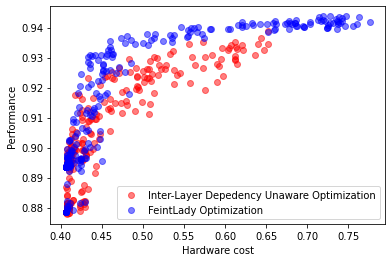

In [106]:
plt.scatter(naive_size,naive_acc,color='red',alpha=0.5,label='Inter-Layer Depedency Unaware Optimization')
plt.scatter(feint_size,feint_acc,color='blue',alpha=0.5,label='FeintLady Optimization')
plt.xlabel('Hardware cost')
plt.ylabel('Performance')
plt.legend()
# plt.imshow(X_std,cmap='hot')
# plt.xlabel('layer index')
# plt.ylabel('layer index')
plt.savefig('resnet56FeintEffecacy.pdf',transparent=True, bbox_inches='tight', pad_inches=0)

In [ ]:
plt.scatter(naive_size,naive_acc,color='red',alpha=0.5,label='naive')
# plt.scatter(naive_size,naive_acc,color='blue',alpha=0.5,label='feint')
plt.xlabel('hardware cost')
plt.ylabel('performance')
plt.legend()
plt.show()